**PROJET TIME SERIES**

**Payen Jérôme Robert Valentin Tu Vinh hoa**

**Source des données:**  
Angelis, G.-F., *Regional Datasets for Air Quality Monitoring in European Cities*, IEEE International Geoscience and Remote Sensing Symposium (IEEE IGARSS-24), Athens, Greece, 2024.

**Variables d'étude :**  
- **Date**  
- **NO2**  
- **O3**  
- **PM10**  
- **PM2.5**  
- **Latitude**  
- **Longitude**  
- **station_name**  
- **Wind-Speed (U)**  
- **Wind-Speed (V)**  
- **Dewpoint Temp**  
- **Temp**  
- **Vegitation (Low)**  
- **Vegitation (High)**  
- **Soil Temp**  
- **Total Percipitation**  
- **Relative Humidity**  
- **Code**  
- **id**

**Objectif :**  
Proposer des modèles de prédiction de la concentration à un horizon 48h.

# Import des librairies

In [ ]:
# Import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV, ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.ensemble import RandomForestRegressor
from matplotlib.ticker import MaxNLocator
from statsmodels.stats.stattools import durbin_watson
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import random as rn
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Dropout, GRU, Input
from scipy.stats import uniform, randint 

# Fonctions et classes utiles

In [106]:
class mm_scaler:
    '''min-max scaler avec la règle du 90% du min et 110% du max'''
    def __init__(self):
        self.quantitatives = None
        self.mini = {}
        self.maxi = {}

    def fit(self, data, quantitatives=None):
        if quantitatives:
            self.quantitatives = quantitatives
        
            for column in quantitatives:
                self.mini[column] = min(data[column])*0.9
                self.maxi[column] = max(data[column])*1.1
        else:
                self.mini = min(data)*0.9
                self.maxi = max(data)*1.1
        
    def transform(self, data):
        df_copy = data.copy()

        if self.quantitatives:
            # On scale les colonnes quantitatives
            for column in self.quantitatives:
                df_copy[column] = (df_copy[column] - self.mini[column]) / \
                                  (self.maxi[column]-self.mini[column])
        else:
            df_copy = (df_copy - self.mini) / (self.maxi-self.mini)

        return df_copy
    
    def transform_inverse(self, data):
        df_copy = data.copy()

        if self.quantitatives:
            # On retransforme les données quantitatives
            for column in self.quantitatives:
                df_copy[column] = df_copy[column]*(self.maxi[column]-self.mini[column]) + \
                                self.mini[column]
        else:
            df_copy = df_copy*(self.maxi-self.mini) + self.mini

        return df_copy
    
def generate_holiday_dates(holiday_periods):
    all_dates = []
    for start_date, end_date in holiday_periods:
        start = datetime.strptime(start_date, "%Y-%m-%d")
        end = datetime.strptime(end_date, "%Y-%m-%d")
      
        # On ajoute
        while start <= end:
            all_dates.append(start.strftime("%Y-%m-%d"))  # Only date
            start += timedelta(days=1)
    return all_dates

def plot_all(data, column, target="O3"):
    '''Fonction pour faire un plot de comparaison sur toute la durée d'un dataframe'''
    plt.plot(data["Date"], data[target], label="Vraies valeurs", color="blue")
    plt.plot(data["Date"], data[column], label="Prévisions", color="orange", alpha=0.9)
    plt.legend()
    plt.xlabel("Temps (h)")
    if target=="O3":
        plt.ylabel(r"$O_3$ ($\mu g.m^{-3}$)")
    else:
        plt.ylabel("Erreur")
    plt.show()

def plot_test_week(data, column, target="O3"):
    '''Fonction pour faire un plot sur une semaine particulière du set de test'''
    plt.plot(data.loc[17620:17787, "Date"], data.loc[17620:17787, target], label="Vraies valeurs", color="blue")
    plt.plot(data.loc[17620:17787, "Date"], data.loc[17620:17787, column], label="Prévisions", color="orange", alpha=0.9)
    plt.legend()
    plt.xlabel("Temps (h)")
    if target=="O3":
        plt.ylabel(r"$O_3$ ($\mu g.m^{-3}$)")
    else:
        plt.ylabel("Erreur")
    plt.gca().xaxis.set_major_locator(MaxNLocator(6))
    plt.show()

def mape(y, y_hat, eps=1e-5):
    '''Calcule la MAPE'''
    return 100 * np.mean(np.abs((y_hat - y) / (np.abs(y) + eps)))

def rmse(y, y_hat):
    '''Calcule la RMSE'''
    return np.sqrt(mean_squared_error(y, y_hat))

def print_metrics(data, column, target="O3", type="estimation"):
    '''Affiche les métriques'''
    print(f"MAPE en {type} : {round(mape(data[target], data[column]),2)}%")
    print(f"RMSE en {type} : {round(rmse(data[target], data[column]),2)}")

def plot_importance(model, features):
    '''Affiche le plot des features importances pour les arbres de décisions et les modèles d'ensemble associés'''
    # On récupère les features importances
    feature_importances = model.feature_importances_

    # On les stocke dans un dataframe
    features_df = pd.DataFrame({
        "Feature": features,
        "Importance": feature_importances
    })

    # On sélectionne les 10 plus importantes
    top_features = features_df.sort_values(by="Importance", ascending=False).head(10)

    # On affiche le barplot
    sns.barplot(x="Importance", y="Feature", data=top_features, hue="Feature", palette="Blues_r")
    plt.xlabel("Contribution à la réduction d'impureté")
    plt.ylabel(None)
    plt.tight_layout()
    plt.show()

    
def prepare_RNN(train, test, target, lag_size, h):
    '''Prépare les bases de données pour l'entraînement et le test des réseaux de neurones récurrents (RNN, LSTM, GRU)'''
    # On normalise les données
    scaler = mm_scaler()
    scaler.fit(train[target])
    scaled_train = np.reshape(scaler.transform(train[target]).values, (-1,1))
    scaled_test = np.reshape(scaler.transform(test[target]).values, (-1,1))

    # taille des dataset
    n_train = len(scaled_train)
    n_test = len(scaled_test)

    # création des jeux de test et train X 
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    # On construit le train 
    for i in range(lag_size+h, n_train+1):
        X_train.append(scaled_train[i-lag_size-h :i-h, 0])
        y_train.append(scaled_train[i-1, 0])

    # On construit le test
    # D'abord on prend tous les inputs qui sont complètement dans le train
    for i in range(h):
        X_test.append(scaled_train[n_train-lag_size-h+1+i:n_train-h+1+i, 0])
        y_test.append(scaled_test[i, 0])

    # Ensuite on prend tous les inputs qui sont à la fois dans le train et le test
    for i in range(lag_size-1):
        X_test.append(np.concatenate([scaled_train[n_train-lag_size+1+i:n_train,0], scaled_test[:i+1,0]]))
        y_test.append(scaled_test[h+i,0])

    # Enfin on prend tous les inputs qui sont complètement dans le test
    for i in range(lag_size+h, n_test+1):    
        X_test.append(scaled_test[i-lag_size-h:i-h, 0])
        y_test.append(scaled_test[i-1, 0])
    
    X_train, y_train = np.array(X_train), np.array(y_train)
    # reshaping
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    y_train = np.reshape(y_train, (y_train.shape[0],1))

    X_test, y_test = np.array(X_test), np.array(y_test)
    # reshaping
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    y_test = np.reshape(y_test, (y_test.shape[0],1))

    return X_train, y_train, X_test, y_test, scaler

def EWA_update(eta, p, l):  
    '''Fait la mise à jour des poids dans l'algorithme EWA pour l'agrégation d'experts'''
    numerator = np.exp(-eta*l)
    denominator = np.sum(numerator)
    return numerator/denominator

def loss_gradient(y,p,predictions):
    '''Calcule le gradient de la perte L2'''
    return -predictions*(y-np.dot(p,predictions))

def EG(experts, target, eta):
    '''Algorithme EG pour la mise à jour des poids dans l'agrégation d'experts'''
    # On récupert les dimensions du tableau des prévisions
    T, d = experts.shape

    # On initialise la matrice des poids
    p = np.zeros((T+1, d))
    p[0,:] = np.full(d, 1/d)

    # On initialise le vecteur des prédictions aggrégées des experts
    pred = np.zeros(T)

    # On initialise le vecteur des pertes
    loss_pred = np.zeros(T)

    # On initialise le vecteur des gradients cumulés des poids
    loss_grad = np.zeros(d)

    for hour in range(T):
        # On calcule la prédiction comme combinaison pondérée des experts
        pred[hour] = np.dot(p[hour], experts.loc[17520+hour].values)
        loss_pred[hour] = 0.5*(pred[hour]-target.loc[17520+hour])**2
        # On ajoute le gradient de la perte pour cette prédiction
        loss_grad += loss_gradient(y=target.loc[17520+hour], p=p[hour], predictions=experts.loc[17520+hour].values)
        # On met à jour les poids
        p[hour+1] = EWA_update(eta, p=p[hour], l=loss_grad)

    return pred, p, loss_pred

def EWA(experts, target, eta):
    '''Algorithme EWA pour la mise à jour des poids dans l'agrégation d'experts'''
    # On récupert les dimensions du tableau des prévisions
    T, d = experts.shape

    # On initialise la matrice des poids
    p = np.zeros((T+1, d))
    p[0,:] = np.full(d, 1/d)

    # On initialise le vecteur de prédiction de l'agrégation des experts
    pred = np.zeros(T)

    # On initialise la perte cumulée des experts
    loss_experts = 0

    # On initialise le vecteurs des pertes cumulées des experts
    loss_pred = np.zeros(T)

    for hour in range(T):
        # On calcule la prédiction comme somme pondérée des experts
        pred[hour] = np.dot(p[hour], experts.loc[17520+hour].values) 
        loss_pred[hour] = 0.5*(pred[hour]-target.loc[17520+hour])**2
        # On ajoute le vecteur des pertes de experts pour cette heure là
        loss_experts += (0.5*(experts.loc[17520+hour]-target.loc[17520+hour])**2).values  
        # On met à jour les poids
        p[hour+1] = EWA_update(eta, p=p[hour], l=loss_experts) 
    
    return pred, p, loss_pred

def plot_weight(p,T,labels):
    '''Affiche la distribution des poids au cours du temps pour l'algorithme EG ou EWA'''
    plt.figure(figsize=(10,5))
    plt.stackplot(range(T+1), p.T, labels=labels, alpha=0.8)
    plt.legend(loc="upper right")
    plt.xlabel("Itération")
    plt.ylabel("Poids")
    plt.show()

# Import des données et prétraitement

On importe les données et on ne garde que les observations pour la station choisie (*PANACEA_021*). On retravaille légèrement les colonnes.

In [ ]:
# Import du csv
df_source = pd.read_csv("../Data/athens_data.csv")

# On se restreint à une seule station pour le moment
df = df_source[df_source["station_name"]=="PANACEA_021"]

# On supprime les colonnes qui servent seulement à l'identification de la station
df.reset_index(drop=True, inplace=True)
df = df.drop(columns=["station_name", "code", "id", "Latitude", "Longitude"])

# On renomme correctement les variables
mapper = {
    "Wind-Speed (U)" : "WindSpeedU",
    "Wind-Speed (V)" : "WindSpeedV",
    "Dewpoint Temp" : "DewpointTemp",
    "Soil Temp" : "SoilTemp",
    "Total Percipitation" : "TotalPrecipitation",
    "Vegitation (High)" : "VegitationHigh",
    "Vegitation (Low)" : "VegitationLow",
    "Relative Humidity" : "RelativeHumidity"
}
df = df.rename(columns=mapper)

# Conversion de la colonne date dans le bon format
df["Date"] = pd.to_datetime(df["Date"])


On a 48 lignes consécutives (2 jours) avec des valeurs manquantes.

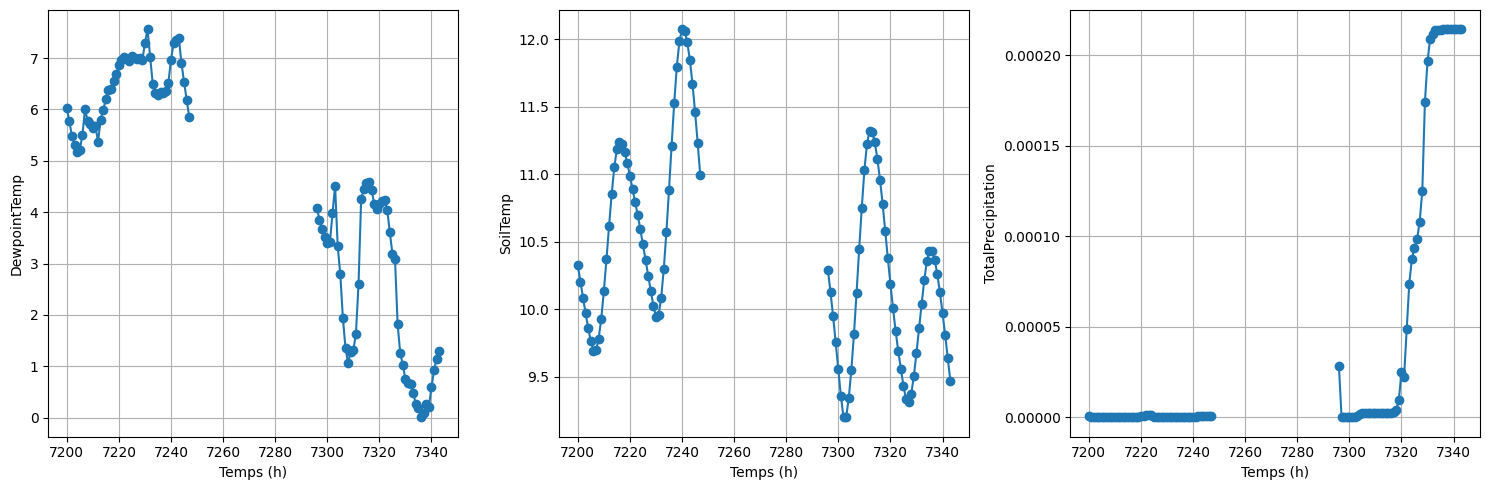

In [ ]:
# Sélection de l'intervalle des données
df_interval = df.loc[7200:7343]

# Colonnes à tracer
colonnes_exemples = ["DewpointTemp", "SoilTemp", "TotalPrecipitation"]

# Créer une figure avec 3 subplots (1 ligne, 3 colonnes)
plt.figure(figsize=(15, 5))

for i, column in enumerate(colonnes_exemples):
    plt.subplot(1, 3, i + 1)  # 1 ligne, 3 colonnes, i+1 pour l'index du subplot
    plt.plot(df_interval.index, df_interval[column], marker="o")
    plt.xlabel("Temps (h)")
    plt.ylabel(f"{column}")
    plt.grid(True)

# Ajuster l'espacement entre les subplots
plt.tight_layout()
plt.show()

Pour la reconstruction : on fait une interpolation linéaire heure par heure pour toutes les variables à l'exception de *TotalPrecipiation* qu'on met simplement à 0.

In [10]:
# Reconstruction des valeurs manquantes 
to_interpolate = [iter for iter in list(df.columns) if iter not in ["Date", "PM10", "PM2.5", "TotalPrecipitation"]]

for i in range(24):
    # premier jour
    df.loc[7248+i,to_interpolate] = (df.loc[7248+48+i,to_interpolate] - df.loc[7248-24+i,to_interpolate])/3 + \
                                    df.loc[7248-24+i,to_interpolate]
    # deuxième jour
    df.loc[7248+24+i,to_interpolate] = 2*(df.loc[7248+48+i,to_interpolate] - df.loc[7248-24+i,to_interpolate])/3 + \
                                       df.loc[7248-24+i,to_interpolate]

df.loc[7248:7295, "TotalPrecipitation"] = 0


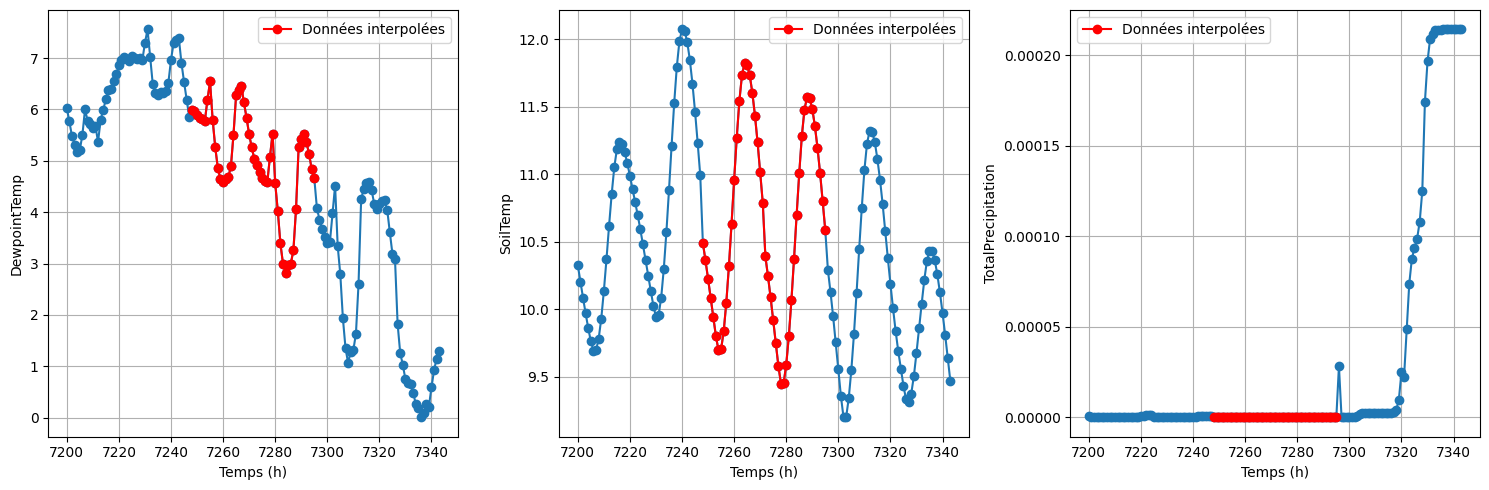

In [ ]:
# Sélection de l'intervalle des données
df_interval = df.loc[7200:7343]

# Colonnes à tracer
colonnes_exemples = ["DewpointTemp", "SoilTemp", "TotalPrecipitation"]

# Définition de l'intervalle à mettre en rouge
interval_rouge = df_interval.loc[7248:7295]

# Créer une figure avec 3 subplots (1 ligne, 3 colonnes)
plt.figure(figsize=(15, 5))

for i, column in enumerate(colonnes_exemples):
    plt.subplot(1, 3, i + 1)  # 1 ligne, 3 colonnes, i+1 pour l'index du subplot
    plt.plot(df_interval.index, df_interval[column], marker="o")
    plt.plot(interval_rouge.index, interval_rouge[column], marker="o", color="red", label="Données interpolées")
    plt.xlabel("Temps (h)")
    plt.ylabel(f"{column}")
    plt.grid(True)
    plt.legend()

# Ajuster l'espacement entre les subplots
plt.tight_layout()
plt.show()

La reconstruction semble satisfaisante.

On étoffe notre jeu de données avec de nouvelles variables.

In [ ]:
# On ajoute la variable catégorielle correspondant aux jours fériés grecs 
greece_public_holidays = [
    datetime.strptime(date, "%d/%m/%Y").date() for date in [
        "01/05/2020", "08/06/2020", "15/08/2020", "28/10/2020", "25/12/2020", 
        "26/12/2020", 
        "01/01/2021", "06/01/2021", "15/03/2021", "25/03/2021", "30/04/2021", 
        "01/05/2021", "03/05/2021", "04/05/2021", "21/06/2021", "15/08/2021", 
        "28/10/2021", "25/12/2021", "26/12/2021", 
        "01/01/2022", "06/01/2022", "07/03/2022", "25/03/2022", "22/04/2022", 
        "25/04/2022", "02/05/2022", "13/06/2022", "15/08/2022", "28/10/2022", 
        "25/12/2022", "26/12/2022", 
        "01/01/2023", "06/01/2023", "27/02/2023", "25/03/2023", "14/04/2023", 
        "17/04/2023", "01/05/2023"
    ]
]
df["PublicHolidays"] = df["Date"].dt.date.isin(greece_public_holidays)

# Ajout des variables temporelles
df["Hour"] = df["Date"].dt.hour
df["Day"] = df["Date"].dt.day_name()
df["Month"] = df["Date"].dt.month

# Ajout d'une variable binaire IsRaining
df["TotalPrecipitation"] = df["TotalPrecipitation"]*1000
df["IsRaining"] = df["TotalPrecipitation"].apply(lambda x: 0 if x < 0.5 else 1)

# Ajout d'une variable de vacances scolaires
holidays = [
   ("2020-06-18", "2020-09-11"), 
   ("2020-12-24", "2021-01-07"), 
   ("2021-04-26", "2021-05-07"), 
   ("2021-06-15", "2021-09-10"), 
   ("2021-12-24", "2022-01-07"), 
   ("2022-04-18", "2022-04-29"),
   ("2022-06-16", "2022-09-09"), 
   ("2022-12-23", "2023-01-06"), 
   ("2023-04-10", "2023-04-21"), 
]
holiday_dates = generate_holiday_dates(holidays)
df["SchoolHolidays"] = df["Date"].dt.date.astype(str).isin(holiday_dates)

# Ajout d'une variable position dans l'année (jour de l'année prenant en compte l'heure)
Position_2020 = np.arange(2904,8784)/8784
Position_2021 = np.arange(8760)/8760
Position_2022 = np.arange(8760)/8760
Position_2023 = np.arange(3576)/8760

df["YearPosition"] = np.concatenate((Position_2020,Position_2021,Position_2022,Position_2023))
df["YearSeasonality"] = np.cos(2 * np.pi * df["YearPosition"])

Position_2020 = Position_2020*366
Position_2021 = Position_2021*365
Position_2022 = Position_2022*365
Position_2023 = Position_2023*365

df["YearPosition"] = np.concatenate((Position_2020,Position_2021,Position_2022,Position_2023))
df["DaySeasonality"] = np.cos(2 * np.pi * df["YearPosition"])

# Ajout d'une variable Feu qui prend en compte le feu
fires = pd.read_csv("../Data/fires.csv")
fires["initialdat"] = pd.to_datetime(fires["initialdat"]) + pd.Timedelta(days=2)
fires["finaldate"] = pd.to_datetime(fires["finaldate"]) + pd.Timedelta(days=2)
fires["initialdat"] = fires["initialdat"].apply(lambda x: x.replace(hour=10))
fires["finaldate"] = fires["finaldate"].apply(lambda x: x.replace(hour=18))
fires["Fires"] = fires["area_ha"]*10000 / fires["dist"]**2

# Initialisation de la colonne Fires
df["Fires"] = 0.0

# Pour chaque ligne de df, vérifier si la date est dans l'intervalle de dates des incendies et sommer les scores
for index, row in df.iterrows():
    date_df = row["Date"]
   
    # Sélectionner les incendies dont les dates sont comprises entre 'initialdat' et 'finaldate'
    mask = (fires["initialdat"] <= date_df) & (fires["finaldate"] >= date_df)

    # Somme des coefficients des incendies correspondant à cette date
    df.at[index, "Fires"] = fires.loc[mask, "Fires"].sum()

# Stacking et Persistance
alpha = 0.96 #persistance
beta = 0.01 #stacking
for i in range(1,df.shape[0]):
    if (df.loc[i-1, "Fires"] == 0) & (df.loc[i, "Fires"]!=0):
        continue
    elif (df.loc[i-1, "Fires"]!=0) & (df.loc[i, "Fires"]!=0):
        if (df.loc[i-1, "Fires"]%df.loc[i, "Fires"]!=0):
            df.loc[i, "Fires"] += df.loc[i-1, "Fires"]
    else:
        df.loc[i, "Fires"] = df.loc[i-1, "Fires"] * alpha + df.loc[i, "Fires"] * (1-alpha+beta)
    
    if df.loc[i, "Fires"] < 0.00001:
        df.loc[i, "Fires"] = 0

# Encodage des variables catégorielles temporelles en one hot encoding
df = pd.get_dummies(df, columns = ["Day", "Hour", "Month"])

# On retire les variables qu'on n'utilisera pas pour la régression
df.drop(columns = ["PM10", "PM2.5", "NO2", "YearPosition"], inplace=True)

On divise le jeu de données en un set d'entraînement et un set de test :
- le train est constitué des deux premières années, du 1er mai 2020 au 30 avril 2022 (inclu)
- le test est constitué de la dernière année, du 1er mai 2022 au 29 mai 2023 (inclu)

In [13]:
data_train = df[:17520].copy()
data_test = df[17520:].copy()

# Représentation graphiques

Nous affichons la série temporelle de la concentration d'ozone à travers le temps. Au premier coup d'oeil nous remarquons une saisonnalité et une légère tendance, les valeurs varient entre 0 et 250.

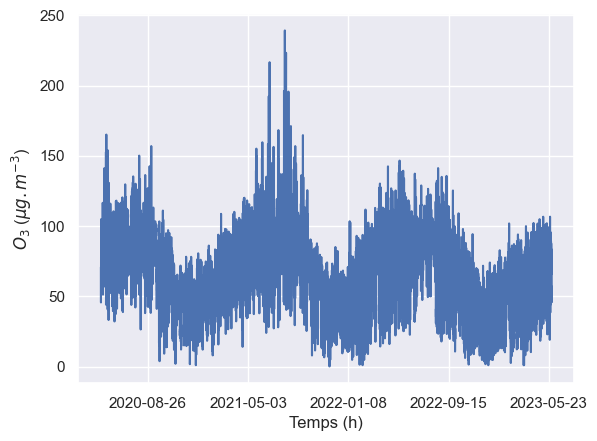

In [98]:
# plot de la concentration d'O3 
sns.set_theme()
plt.plot(df["Date"], df["O3"])
plt.xlabel("Temps (h)")  # Label de l'axe X
plt.ylabel(r"$O_3$ ($\mu g.m^{-3}$)")  # Label de l'axe Y
plt.gca().xaxis.set_major_locator(MaxNLocator(6))
#plt.title("Concentration d'O3 à travers le temps")
plt.show()

Les boxplots permettent de détecter des valeurs aberrantes. Nous remarquons que les données n'ont pas ces anomalies. Nous remarquons que la variable "TotalPrecipitation" contient beaucoup de données nulles voir proches de 0. Cela justifie la création d'une variable binaire "IsRaining".

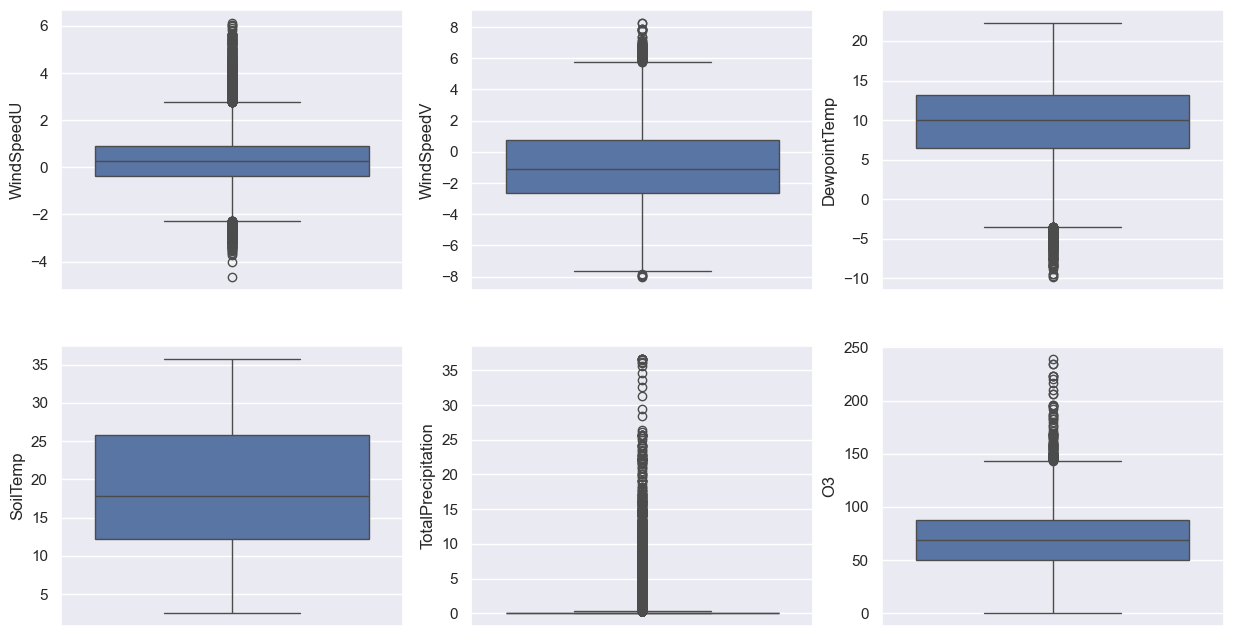

In [107]:
# Boxplots
sns.set_theme()
fig, axs = plt.subplots(ncols = 3, nrows =2)
fig.set_figheight(8)
fig.set_figwidth(15)
sns.boxplot(data = df, y = "WindSpeedU", ax=axs[0][0])
sns.boxplot(data = df, y = "WindSpeedV", ax=axs[0][1])
sns.boxplot(data = df, y = "DewpointTemp", ax=axs[0][2])
sns.boxplot(data = df, y = "SoilTemp", ax=axs[1][0])
sns.boxplot(data = df, y = "TotalPrecipitation", ax=axs[1][1])
sns.boxplot(data = df, y = "O3", ax=axs[1][2])
plt.show()

La metrice des corrélations affiche les valeurs de corréalation linéaire entre deux variables. Dans le cas d'une modélisation avec une régréssion linéaire multiple, il faut éviter d'avoir des variables trop corrélées entre elles. Nous notons la présence d'une valeur de corrélation linéaire supérieur presque égale à 1 pour "VegitationHigh" et "VegitationLow" et supérieur à 0.9 pour "SoilTemp" et "Temp".

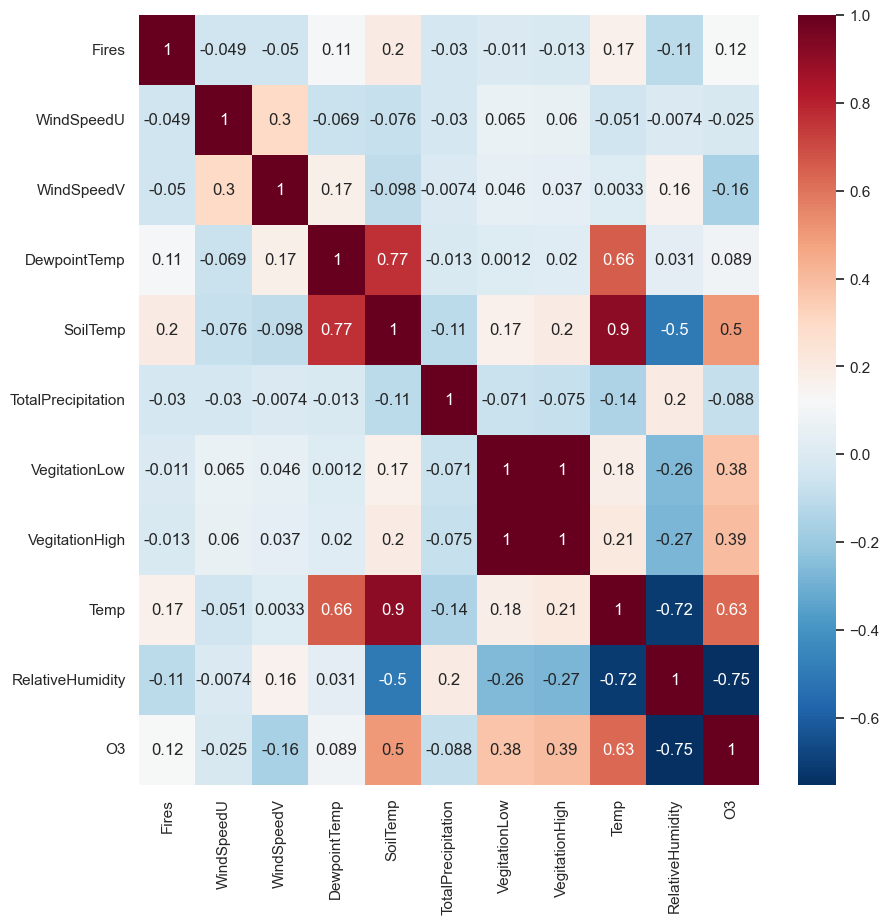

In [108]:
# Matrice des corrélations
quantitatives = ["Fires","WindSpeedU","WindSpeedV", "DewpointTemp", "SoilTemp", "TotalPrecipitation", "VegitationLow", "VegitationHigh", "Temp","RelativeHumidity", "O3",]
sns.set_theme()
plt.figure(figsize=(10, 10))
sns.heatmap(df[quantitatives].corr(), cmap = "RdBu_r", annot =True)
plt.show()

On confirme graphiquement les fortes corrélations.

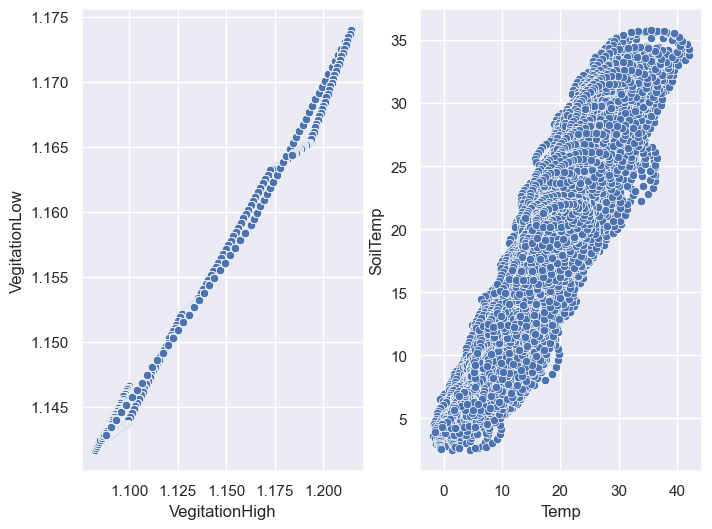

In [109]:
# Nuage de points entre les variables fortement corrélées.
fig, ax =plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.scatterplot(data=df, x="VegitationHigh", y="VegitationLow", ax = ax[0])
sns.scatterplot(data=df, x="Temp", y="SoilTemp", ax = ax[1])
plt.show()

On va maintenant se concentrer sur l'$O_3$

In [110]:
# Création d'un dataframe facilitant l'affichage de graphiques 
dfplot = df[["Date","O3"]].copy()
dfplot["Jour"]=dfplot["Date"].dt.day_name()
dfplot["Année"]=dfplot.loc[:, "Date"].dt.year
dfplot["Heure"]=dfplot.loc[:, "Date"].dt.hour
dfplot["Mois"]=dfplot.loc[:, "Date"].dt.month_name()
dfplotdays = dfplot.drop(columns = ["Mois"]).groupby(["Jour"]).mean().reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
dfplothours = dfplot.drop(columns=["Jour", "Mois"]).groupby(["Heure"]).mean()

Nous affichons la concentration d'$O_3$ moyenne par jour pour observer si les jours jouent un rôle sur la concentration d'ozone. Effectivement, en semaine la concentration est basse mais est élevée le dimanche, le jour de moindre activité.

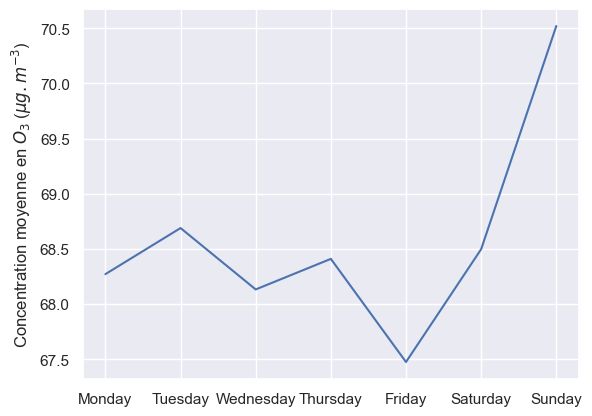

In [113]:
# Courbe de l'O3 par moyen par jour
plt.plot(dfplotdays.iloc[:,1])
#plt.title("Concentration d'$O_3$ moyenne par jour")
#plt.xlabel("Jour de la semaine")
plt.ylabel(r"Concentration moyenne en $O_3$ ($\mu g.m^{-3}$)")
plt.show()

Par la suite, nous affichons la concentration d'$O_3$ par heure et l'influence de l'heure de la journée sur notre polluant est frappante.

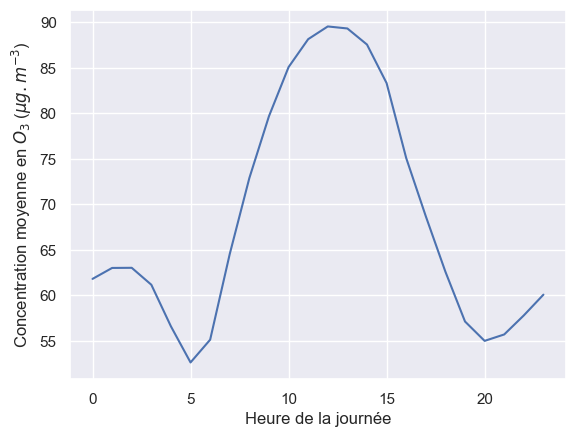

In [115]:
# Courbe de l'O3 par moyen par heure
plt.plot(dfplothours.iloc[:,1])
#plt.title("Concentration d'$O_3$ moyenne par heure")
plt.xlabel("Heure de la journée")
plt.ylabel(r"Concentration moyenne en $O_3$ ($\mu g.m^{-3}$)")
plt.show()

On regarde maintenant la semaine entière.

In [116]:
# Création d'un dataframe pour l'affiche du graphique dans la prochaine cellule
mydfjours = pd.DataFrame()
dftemp = dfplot[dfplot["Jour"]=="Monday"]
mydfjours["Monday"] = dftemp.drop(columns=["Année","Jour","Mois","Date"]).groupby(["Heure"]).mean()
dftemp = dfplot[dfplot["Jour"]=="Tuesday"]
mydfjours["Tuesday"] = dftemp.drop(columns=["Année","Jour","Mois","Date"]).groupby(["Heure"]).mean()
dftemp = dfplot[dfplot["Jour"]=="Wednesday"]
mydfjours["Wednesday"] = dftemp.drop(columns=["Année","Jour","Mois","Date"]).groupby(["Heure"]).mean()
dftemp = dfplot[dfplot["Jour"]=="Thursday"]
mydfjours["Thursday"] = dftemp.drop(columns=["Année","Jour","Mois","Date"]).groupby(["Heure"]).mean()
dftemp = dfplot[dfplot["Jour"]=="Friday"]
mydfjours["Friday"] = dftemp.drop(columns=["Année","Jour","Mois","Date"]).groupby(["Heure"]).mean()
dftemp = dfplot[dfplot["Jour"]=="Saturday"]
mydfjours["Saturday"] = dftemp.drop(columns=["Année","Jour","Mois","Date"]).groupby(["Heure"]).mean()
dftemp = dfplot[dfplot["Jour"]=="Sunday"]
mydfjours["Sunday"] = dftemp.drop(columns=["Année","Jour","Mois","Date"]).groupby(["Heure"]).mean()

mydfjours2 = pd.concat([mydfjours["Monday"],mydfjours["Tuesday"],mydfjours["Wednesday"],
                        mydfjours["Thursday"],mydfjours["Friday"],mydfjours["Saturday"],
                        mydfjours["Sunday"]],ignore_index=True)

Rien de flagrant, on peut peut-être noter que la concentration est légèrement plus grande le dimanche.

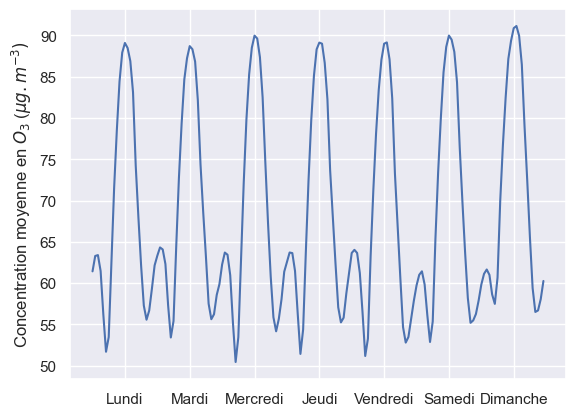

In [121]:
# Courbe de l'O3 par heure par jour
plt.plot(mydfjours2)
#plt.title("Concentration d'$O_3$ moyenne par heure par jour de la semaine")
#plt.xlabel("Heure")
plt.ylabel(r"Concentration moyenne en $O_3$ ($\mu g.m^{-3})$")
plt.xticks([12, 36, 60, 84, 108, 132, 156], ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"])
plt.show()

Pour illustrer la potentielle influence de l'ensoleillement sur la concentration en ozone dans l'atmosphère, on compare la concentration d'ozone moyenne sur un jour du mois de juin avec un jour de décembre. Il y a bien une grande différence.  

In [122]:
# Création d'un dataframe facilitant l'affichage du graphique de la cellule suivante
mydfjuin = dfplot[dfplot["Mois"]=="June"]
mydfdecembre = dfplot[dfplot["Mois"]=="December"]
mydfj1 = mydfjuin.drop(columns = ["Jour","Date","Mois","Année"]).groupby(["Heure"]).mean()
mydfj1["Mois"]="juin"
mydfd1 = mydfdecembre.drop(columns = ["Jour", "Date","Mois","Année"]).groupby(["Heure"]).mean()
mydfd1["Mois"]="décembre"
mydfmois = pd.concat([mydfj1, mydfd1])

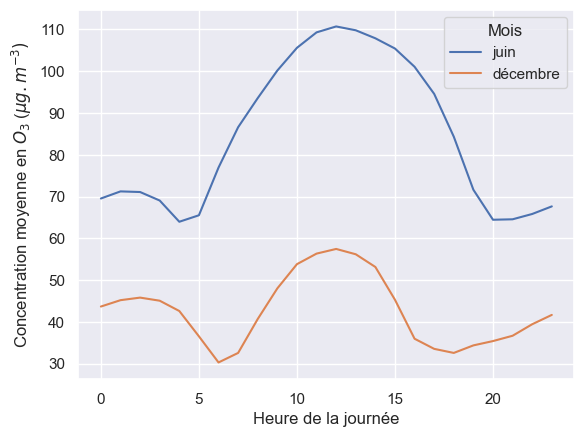

In [124]:
# courbe de l'O3 par heure sur 2 mois différents
sns.lineplot(data= mydfmois, x= mydfmois.index, y = "O3", hue = "Mois")
plt.ylabel(r"Concentration moyenne en $O_3$ ($\mu g.m^{-3})$")
plt.xlabel("Heure de la journée")
#plt.title("Concentration d'$O_3$ moyenne par heure les mois de juin et décembre")
plt.show()

On peut aussi construire des boxplots pour tous les mois de l'année.

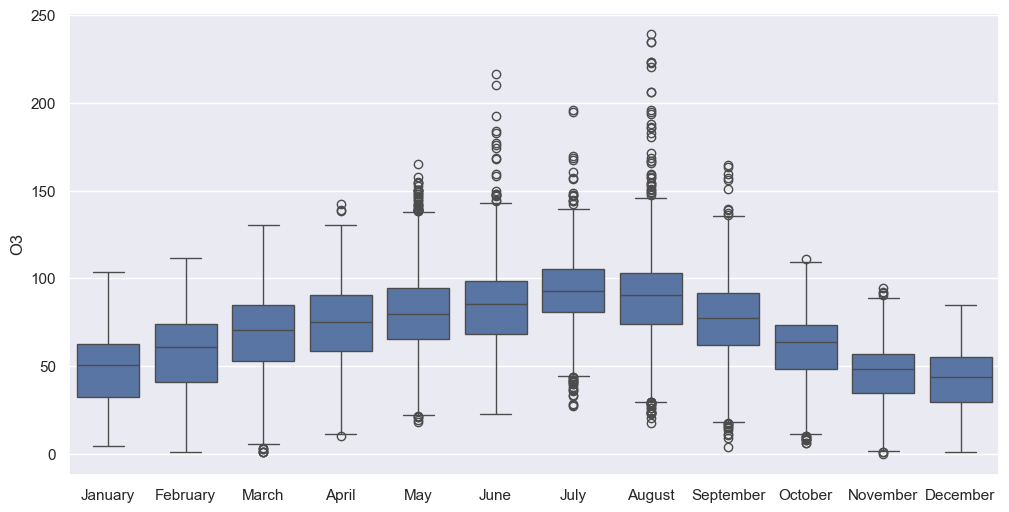

In [126]:
# boxplots par mois
ordre = ["January","February","March","April","May","June","July","August","September","October","November","December"]
plt.figure(figsize=(12, 6))
sns.boxplot(data= dfplot, x = "Mois", y = "O3", order = ordre)
plt.xlabel(None)
#plt.title("Boxplot par mois de la concentration d'ozone")
plt.show()

# Modélisation

## Les benchmarks

1) Cadre de la régression : la moyenne
2) Cadre des modèles de séries temporelles : la moyenne mobile

### La moyenne

On calcule la moyenne sur le train, on pourrai mettre à jour la moyenne à chaque nouvelle heure mais ça ne vaut pas vraiment le coup.

In [7]:
# La moyenne
data_train["mean_O3"] = data_train["O3"].mean()
data_test["mean_O3"] = data_train["O3"].mean()

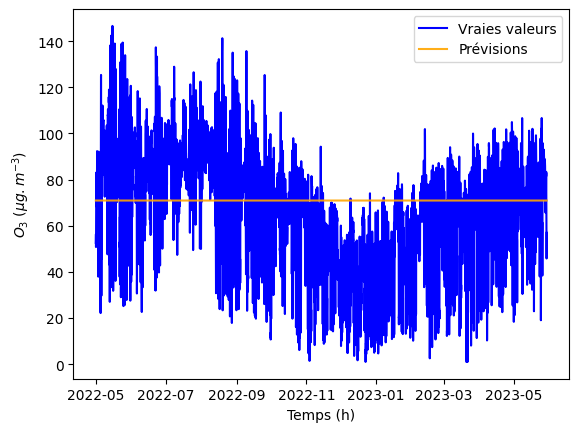

In [8]:
# Plot annuel
plot_all(data_test, "mean_O3")

In [9]:
# On affiche les métriques
print_metrics(data_train, "mean_O3")
print_metrics(data_test, "mean_O3", type="prédiction")

MAPE en estimation : 52.4%
RMSE en estimation : 26.77
MAPE en prédiction : 72.12%
RMSE en prédiction : 27.57


### La moyenne mobile
On fait la moyenne de la semaine passée avec un décalage de 48 pour respecter le décalage qu'on va s'imposer pour la modélisation plus tard.

In [10]:
# La moyenne mobile
MA = df["O3"].shift(48).rolling(window=168).mean().bfill()

data_train["MA_O3"] = MA[:17520]
data_test["MA_O3"] = MA[17520:]


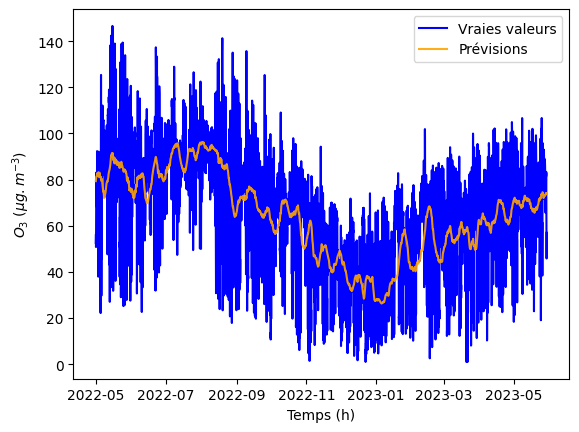

In [11]:
# Plot annuel
plot_all(data_test, "MA_O3")

In [12]:
# On affiche les métriques
print_metrics(data_train, "MA_O3")
print_metrics(data_test, "MA_O3", type="prediction")

MAPE en estimation : 38.22%
RMSE en estimation : 21.29
MAPE en prediction : 47.5%
RMSE en prediction : 21.47


C'est assez étonnant, on a des performances plutôt différentes entre le train et le test alors que le modèle ne dépend pas des données du train (en MAPE seulement).

## Régression linéaire

### Modèle 1 (saisonnalités)
D'abord on fait un régression linéaire avec les variables *YearSeasonality* et *DaySeasonality* pour confirmer l'intuition qui nous a conduit à construire ces variables.

In [ ]:
features = ["DaySeasonality","YearSeasonality"]

# Régression linéaire multiple
reglin_season = LinearRegression()
reglin_season.fit(data_train[features], data_train["O3"])

# Stockage des prédiction
data_train.loc[:,"P_reglin_season"] = reglin_season.predict(data_train[features])
data_test.loc[:,"P_reglin_season"]  = reglin_season.predict(data_test[features])

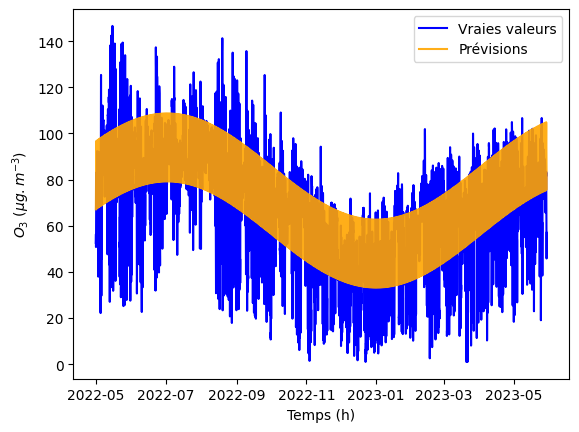

In [ ]:
# Plot sur l'année test
plot_all(data_test, "P_reglin_season")

On colle bien au motif annuel.

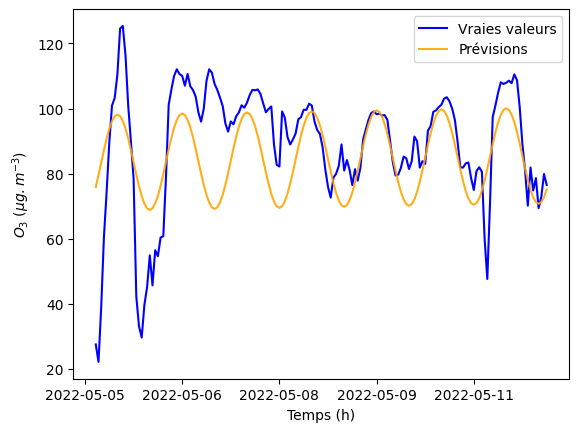

In [ ]:
# Plot sur une semaine choisie
plot_test_week(data_test, "P_reglin_season")

On retrouve bien une partie du motif journalier (jour haut, nuit basse).

In [16]:
# On affiche les métriques
print_metrics(data_train, "P_reglin_season")
print_metrics(data_test, "P_reglin_season", type="prédiction")

MAPE en estimation : 34.85%
RMSE en estimation : 18.53
MAPE en prédiction : 49.04%
RMSE en prédiction : 19.37


En plus, avec un modèle très simple, on a déjà une meilleure MAPE et RMSE que la moyenne, on peut ajouter cette régression au benchmark.

### Modèle 2 (simple)

Cette fois-ci, on utilise toutes les variables à l'exception d'une modalité par variable catégorielle, de la variable *Date* et des variables *VegitationLow* (car très correlée avec *VegitationHigh*) et *SoilTemp* (car très correlée avec *Temp*). Ces deux couples sont des paires de variables très semblable donc on ne perd pas trop d'information.

In [ ]:
# features utilisées pour la régression
features = [feature for feature in df.columns 
            if feature not in ["Date", "Month_1", "Hour_0", "O3", 
                               "Day_Monday", "VegitationLow", "SoilTemp"]]

reglin_all = LinearRegression()
reglin_all.fit(data_train[features], data_train["O3"])

data_train.loc[:,"P_reglin_all"] = reglin_all.predict(data_train[features])
data_test.loc[:,"P_reglin_all"]  = reglin_all.predict(data_test[features])

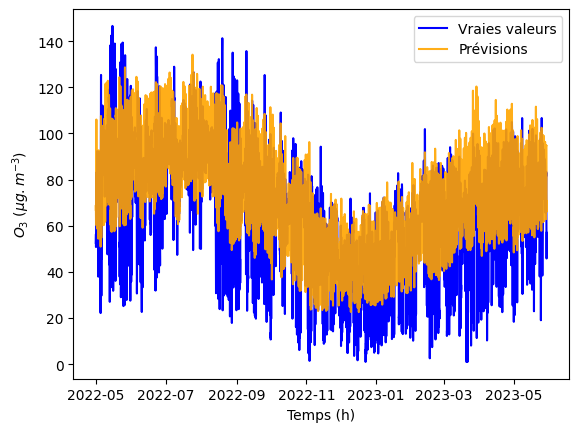

In [ ]:
# Plot sur l'année test
plot_all(data_test, "P_reglin_all")

Le modèle semble bien capter le motif de l'année mais il manque beaucoup de pics, l'étendue des valeurs prises par les prévisions est nettement plus petite que pour les vraies valeurs.

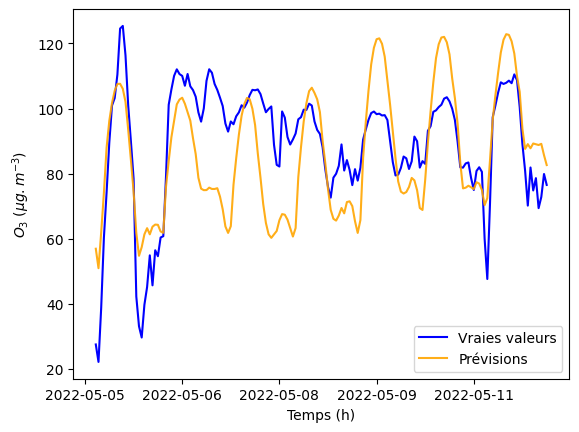

In [ ]:
# Plot sur l'année test
plot_test_week(data_test, "P_reglin_all")

On retrouve bien l'alternance jour-nuit avec un sursaut durant la nuit. Sur cette semaine, la prévision est déjà plutôt satisfaisante. Toutefois, il s'agit d'une semaine prise au début du set de test là où globalement les prévisions semblent les meilleures.

In [20]:
# On affiche les métriques
print_metrics(data_train, "P_reglin_all")
print_metrics(data_test, "P_reglin_all")

MAPE en estimation : 26.72%
RMSE en estimation : 14.43
MAPE en estimation : 39.82%
RMSE en estimation : 16.4


On fait mieux que le benchmark, en particulier sur la MAPE.

In [21]:
# On affiche les coefficients de la régressions
reglin_all.coef_

array([-1.08326038e+00,  1.17320965e-01, -1.21741476e+00,  5.99765981e-01,
        7.58161927e+01,  1.22523292e+00, -4.58980735e-01, -1.70091558e-02,
        5.90801401e+00, -7.44811574e-01, -1.22229215e+01,  1.43038987e+12,
        3.44720133e-02, -6.91747045e-01,  1.66393375e-01,  3.42303818e+00,
        9.23375935e-01,  8.40520042e-01,  4.56173339e-01,  4.87393530e+10,
        1.91635906e+11,  4.18951494e+11,  7.15194936e+11,  1.06017773e+12,
        1.43038987e+12,  1.80060201e+12,  2.14558481e+12,  2.44182825e+12,
        2.66914384e+12,  2.81204039e+12,  2.86077974e+12,  2.81204039e+12,
        2.66914384e+12,  2.44182825e+12,  2.14558481e+12,  1.80060201e+12,
        1.43038987e+12,  1.06017773e+12,  7.15194936e+11,  4.18951494e+11,
        1.91635906e+11,  4.87393530e+10,  4.33325195e+00,  3.66015625e+00,
       -4.12664795e+00, -1.14477539e+01, -8.27786255e+00, -8.30761719e+00,
       -3.72766113e+00,  5.49316406e-02, -5.27087402e+00, -8.38745117e+00,
       -1.21337891e+00])

Même si on a éliminé une modalité par variable catégorielle et les variables très corrélées, les coefficients explosent (ordre de grandeur $10^{12}$).

### Modèle 2 résidus

On cherche à voir si on peut compléter le modèle 2 en faisant de la prédiction sur les résidus.

#### Propriétés

In [22]:
# On stocke les résidus
data_train["E_reglin_all"] = data_train["O3"] - data_train["P_reglin_all"]
data_test["E_reglin_all"] = data_test["O3"] - data_test["P_reglin_all"]

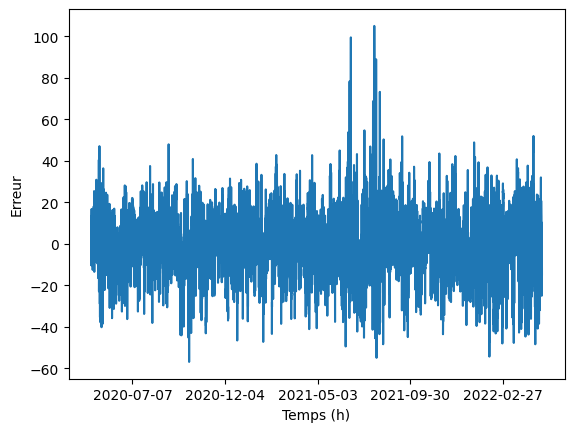

In [23]:
# plot erreur
plt.plot(data_train["Date"], data_train["E_reglin_all"])
plt.xlabel("Temps (h)")
plt.ylabel("Erreur")
plt.gca().xaxis.set_major_locator(MaxNLocator(6))
plt.show()

La variance des résidus semble augmenter sur une courte période et il semble y avoir de la corrélation entre les résidus : les hypothèses d'homosédasticité et de indépendance des résidus ne seraient pas respectées.

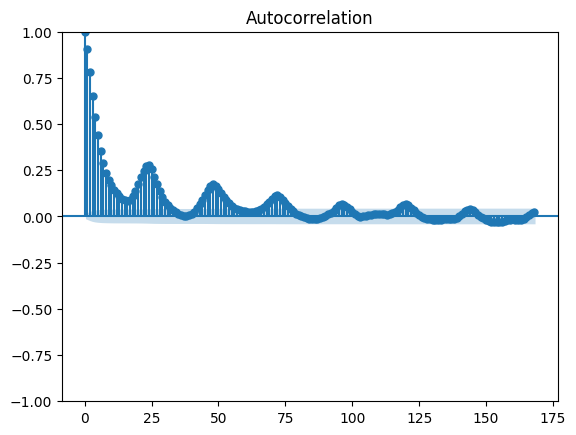

In [24]:
# Autocorrélation des résidus
plot_acf(data_train["E_reglin_all"], lags=168)
plt.show()

On a un corrélation des données et on remarque même un motif de période 24h.

In [25]:
# On regarde la statistique de Durbin Watson
durbin_watson(data_train["E_reglin_all"])

0.18937080006153506

La statistique de Durbin Watson $\frac{\sum_{t=2}^T(e_t-e_{t-1})^2}{\sum_{t=1}^T e_t^2}$, avec $(e_t)_{t \geq 1}$ la série des résidus sur le set de train, est très proche de 0 : les résidus sont corrélés positivement.

Il pourrait être intéressant d'utiliser un modèle de série temporelle pour prédire les résidus. Toutefois, si on veut pouvoir faire des prédictions à un horizon de deux jours, on doit utiliser des données avec au moins un lag de 48. Les modèles ARMA sont dès lors à écarter. On peut toutefois songer à des réseaux de neurones récurrents (LSTM, GRU).

On peut aussi penser à un simple arbre de décision utilisant les mêmes features que la régression linéaire (qui comprend des variables liées à la saisonnalité). Dans la même veine, il y a également les méthodes de boosting, les forêts aléatoires ou bien les PMC qui pourraient venir compléter notre régression linéaire.

On essaiera naturellement de faire mieux que prédire les résidus par 0.

In [26]:
# On affiche les métriques pour une prévision des résidus par 0
data_train["P_zeros"] = 0.
data_test["P_zeros"] = 0.
print_metrics(data_train, "P_zeros", target="E_reglin_all")
print_metrics(data_test, "P_zeros", target="E_reglin_all", type="prediction")

MAPE en estimation : 100.0%
RMSE en estimation : 14.43
MAPE en prediction : 100.0%
RMSE en prediction : 16.4


Il faudra néanmoins faire attention à la MAPE car les résidus sont centrés et les valeurs proches de 0 pourraient faire exploser l'erreur.

#### Arbre de décision

En entraînant un arbre de décision sur les résidus et en essayant de tuner quelques hyperparamètres, on obtient des des arbres très élagués.

Nous avons essayé de modifier les paramètres de pruning, le score pour choisir la meilleur combinaison d'hyperparamètres, le nombre d'observations par feuille, la profondeur maximale, etc. mais on obtenait toujours des arbres peu developpés.

In [ ]:
# On définit le modèle et la grille de recherche 
cart = DecisionTreeRegressor(random_state=42)
param_grid = {"ccp_alpha": np.arange(0.1,1.1,0.1)}

# On recherche le meilleur paramètre par validation croisée
grid_search = GridSearchCV(cart, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(data_train[features], data_train["E_reglin_all"])

# Meilleurs hyperparamètres
print("Meilleur ccp_alpha :", grid_search.best_params_["ccp_alpha"])
print("Meilleur score :", grid_search.best_score_)

# Meilleur estimateur
cart_reglin_all = grid_search.best_estimator_

# On stocke les résultats
data_train["CPE_reglin_all"] = cart_reglin_all.predict(data_train[features])
data_test["CPE_reglin_all"] = cart_reglin_all.predict(data_test[features])

Meilleur ccp_alpha : 0.9
Meilleur score : -186.30473036642093


Le meilleur ccp_alpha est grand !

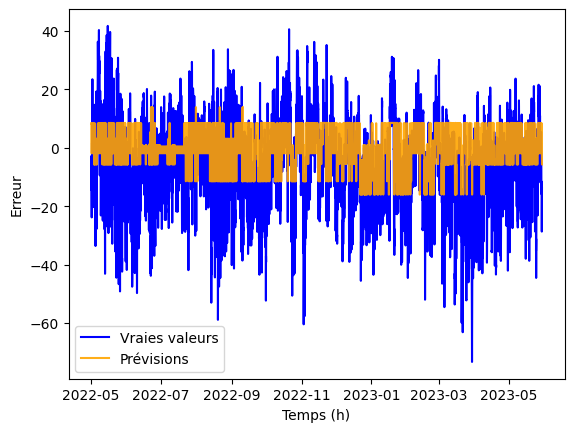

In [28]:
# Plot annuel
plot_all(data_test, "CPE_reglin_all", target="E_reglin_all")

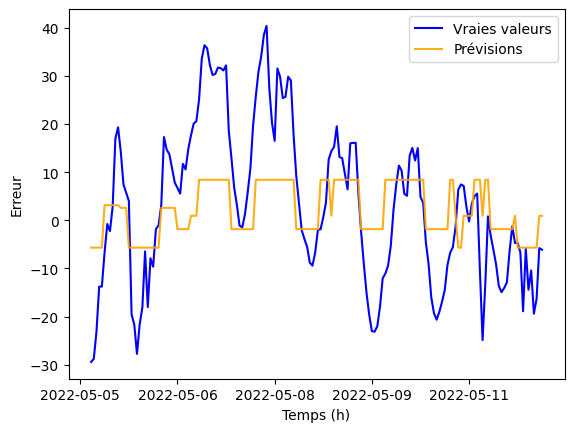

In [29]:
# Plot sur une semaine
plot_test_week(data_test, "CPE_reglin_all", target="E_reglin_all")

In [30]:
# On affiche les métriques pour l'erreur
print_metrics(data_train, "CPE_reglin_all", target="E_reglin_all")
print_metrics(data_test, "CPE_reglin_all", target="E_reglin_all", type="prediction")

MAPE en estimation : 337.86%
RMSE en estimation : 12.4
MAPE en prediction : 243.43%
RMSE en prediction : 14.58


Le prédicteur n'est pas vraiment ambitieux et se contente de prédire une alternance de petites valeurs positives et négatives selon une certaine saisonalité journalière.

On n'améliore pas nos performances, quelque soit le tuning de l'arbre, on ne fait pas mieux que ne rien prédire. Un arbre de seul est trop simple pour pouvoir prédire les résidus.

In [31]:
# On affiche les métriques pour la prévision de l'ozone corrigée
data_train["CP_reglin_all"] = data_train["P_reglin_all"] + data_train["CPE_reglin_all"]
data_test["CP_reglin_all"] = data_test["P_reglin_all"] + data_test["CPE_reglin_all"]

print_metrics(data_train, "CP_reglin_all")
print_metrics(data_test, "CP_reglin_all", type="prediction")

MAPE en estimation : 21.39%
RMSE en estimation : 12.4
MAPE en prediction : 33.34%
RMSE en prediction : 14.58


On gagne 6% de MAPE et 2 point de RMSE.

#### XGBOOST

On prend beaucoup d'estimateurs faibles mais un petit pas d'apprentissage.

In [57]:
# On utilise le gradient boosting avec des arbres sur les résidus
xgb = XGBRegressor(random_state=42, n_estimators=1000, learning_rate=0.05)

xgb.fit(data_train[features], data_train["E_reglin_all"])

# On stocke les prévisions
data_train["XGBPE_reglin_all"] = xgb.predict(data_train[features])
data_test["XGBPE_reglin_all"] = xgb.predict(data_test[features])


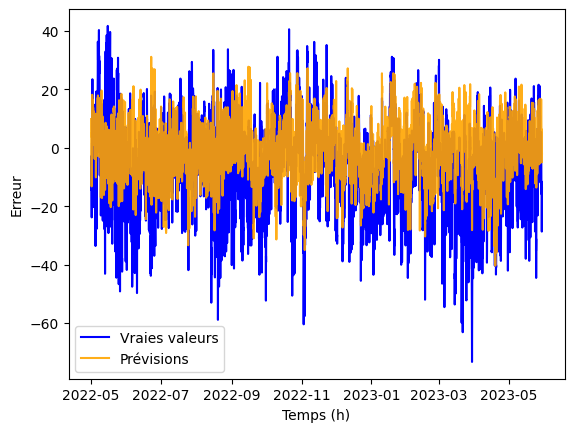

In [33]:
# Plot annuel
plot_all(data_test, "XGBPE_reglin_all", target="E_reglin_all")

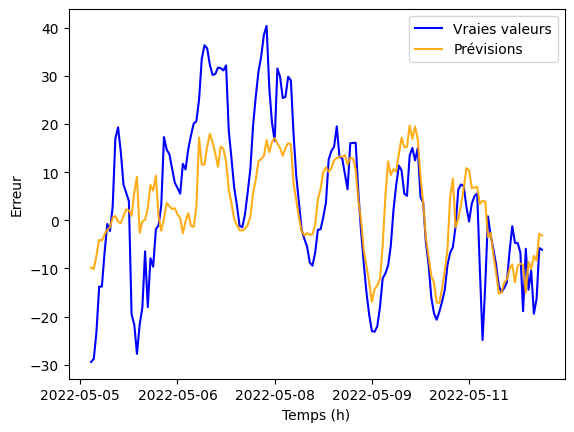

In [34]:
# Plot sur une semaine
plot_test_week(data_test, "XGBPE_reglin_all", target="E_reglin_all")

In [35]:
# On affiche les métriques
print_metrics(data_train, "XGBPE_reglin_all", target="E_reglin_all")
print_metrics(data_test,"XGBPE_reglin_all", target="E_reglin_all", type="prediction")

MAPE en estimation : 145.46%
RMSE en estimation : 4.47
MAPE en prediction : 348.78%
RMSE en prediction : 14.39


Les graphiques laissent penser qu'on fait mieux, les métriques indiquent qu'on fait à peine mieux en RMSE.

In [36]:
# On regarde les métriques pour la prévision d'ozone corrigée
data_train["XGBP_reglin_all"] = data_train["P_reglin_all"] + data_train["XGBPE_reglin_all"]
data_test["XGBP_reglin_all"] = data_test["P_reglin_all"] + data_test["XGBPE_reglin_all"]

print_metrics(data_train, "XGBP_reglin_all")
print_metrics(data_test,"XGBP_reglin_all", type="prediction")

MAPE en estimation : 6.74%
RMSE en estimation : 4.47
MAPE en prediction : 31.36%
RMSE en prediction : 14.39


On gagne 8% de MAPE et 2 points de RMSE par rapport à la régression intiale.

#### Perceptron mulitcouches

In [ ]:
# On prépare les données pour le PMC
PMC_input_scaler = mm_scaler()
PMC_input_scaler.fit(data_train[features], 
               quantitatives= ["WindSpeedU",
                            "WindSpeedV",
                            "DewpointTemp",
                            "TotalPrecipitation",
                            "VegitationHigh",
                            "Temp",
                            "RelativeHumidity",
                            "YearSeasonality",
                            "DaySeasonality",
                            "Fires"])
X_train = PMC_input_scaler.transform(data_train[features])
X_test = PMC_input_scaler.transform(data_test[features])

PMC_output_scaler = mm_scaler()
PMC_output_scaler.fit(data_train["E_reglin_all"])
y_train = PMC_output_scaler.transform(data_train["E_reglin_all"])
y_test = PMC_output_scaler.transform(data_test["E_reglin_all"])

# On entraine le réseau
nn_model = MLPRegressor(hidden_layer_sizes=(256, 128), random_state=42, learning_rate="adaptive", max_iter=100000)

nn_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(256, 128), learning_rate='adaptive',
             max_iter=100000, random_state=42)

In [38]:
# On stocke les prédictions
data_train["NNPE_reglin_all"] = PMC_output_scaler.transform_inverse(nn_model.predict(X_train))
data_test["NNPE_reglin_all"] = PMC_output_scaler.transform_inverse(nn_model.predict(X_test))

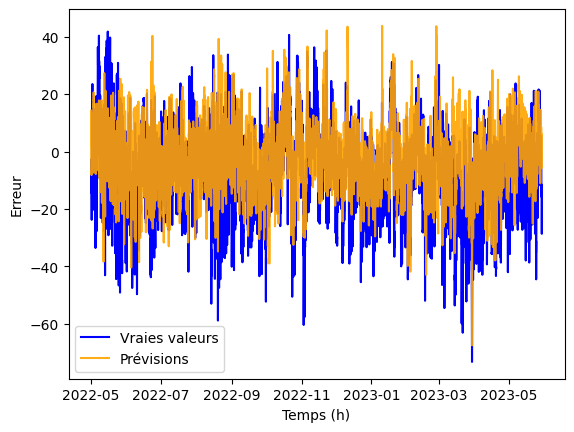

In [39]:
# Plot annuel
plot_all(data_test, "NNPE_reglin_all", target="E_reglin_all")

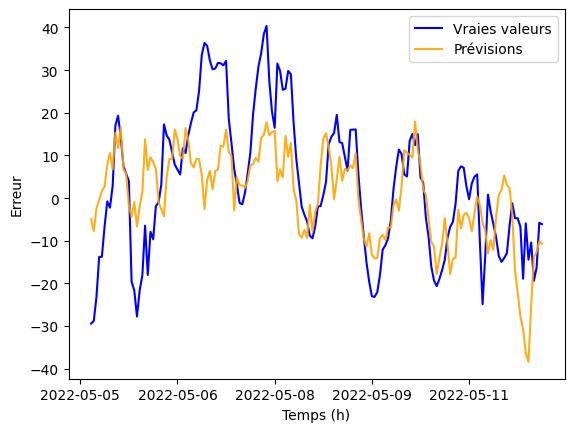

In [40]:
# Plot sur une semaine
plot_test_week(data_test, "NNPE_reglin_all", target="E_reglin_all")

In [41]:
# On affiche les métriques
print_metrics(data_train, "NNPE_reglin_all", target="E_reglin_all")
print_metrics(data_test,"NNPE_reglin_all", target="E_reglin_all", type="prediction")

MAPE en estimation : 332.58%
RMSE en estimation : 8.87
MAPE en prediction : 349.82%
RMSE en prediction : 14.41


On a vraiment l'impression que le PMC pourrait bien prédire les résidus mais on n'améliore que très peu la RMSE pour un modèle plutôt lourd (beaucoup de neurones).

In [42]:
# On affiche les métriques de la prévision d'ozone corrigée
data_train["NNP_reglin_all"] = data_train["P_reglin_all"]+data_train["NNPE_reglin_all"]
data_test["NNP_reglin_all"] = data_test["P_reglin_all"]+data_test["NNPE_reglin_all"]

print_metrics(data_train, "NNP_reglin_all")
print_metrics(data_test, "NNP_reglin_all", type="prediction")

MAPE en estimation : 13.85%
RMSE en estimation : 8.87
MAPE en prediction : 30.67%
RMSE en prediction : 14.41


On gagne 9% de MAPE et 2 point de RMSE (on fait mieux que XGBOOST).

#### LSTM

Cette fois-ci, on n'utilise pas un modèle de régression pour prédire les résidus mais un modèle de séries temporelles. Peut-être parviendra-t-il a capter la composante temporelle qu'il manque au modèle de régression linéaire (c.f. l'acf des résidus, le test de Durbin Watson).

In [ ]:
# Construction des sets d'entraînement et de test
X_train, y_train, X_test, y_test, scaler = prepare_RNN(data_train, data_test, "E_reglin_all", lag_size=4, h=48)

# Pour la reproductibilité
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

# Construction du modèle
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu", return_sequences=False),
    Dense(1, activation="linear")
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse")

# Entraînement initial
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

Epoch 1/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0732
Epoch 2/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0074
Epoch 3/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0074
Epoch 4/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0073
Epoch 5/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0073


In [44]:
# On stocke les résultats
data_train["LSTMPE_reglin_all"] = 0.
data_train.loc[51:,"LSTMPE_reglin_all"] = scaler.transform_inverse(model.predict(X_train))
data_test["LSTMPE_reglin_all"] = scaler.transform_inverse(model.predict(X_test))

546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


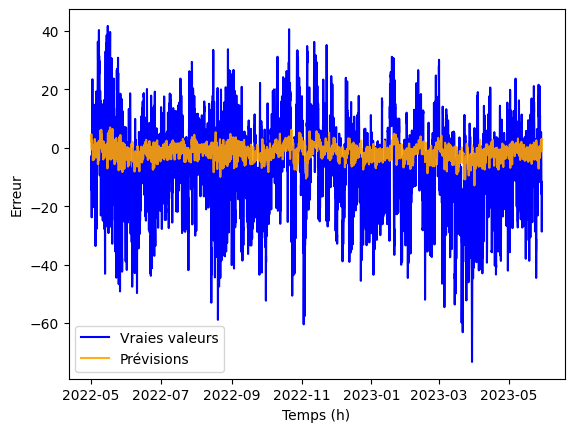

In [45]:
# Plot annuel
plot_all(data_test, "LSTMPE_reglin_all", target="E_reglin_all")

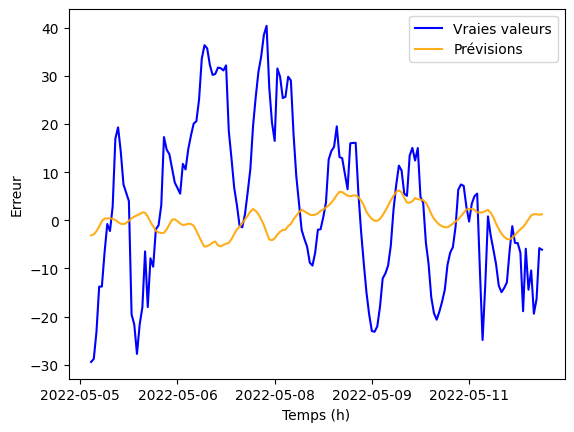

In [46]:
# Plot sur une semaine
plot_test_week(data_test, "LSTMPE_reglin_all", target="E_reglin_all")

In [47]:
# On affiche les métriques
print_metrics(data_train, "LSTMPE_reglin_all", target="E_reglin_all")
print_metrics(data_test, "LSTMPE_reglin_all", target="E_reglin_all", type="prediction")

MAPE en estimation : 171.61%
RMSE en estimation : 14.26
MAPE en prediction : 175.58%
RMSE en prediction : 15.54


Il semblerait que le modèle ne capte pas du tout le comportement des résidus : on ne respecte pas du tout l'amplitude des erreurs mais on va globalement un peu plus au dessus de 0 quand les erreurs sont positive et en dessous de 0 quand les erreurs sont négatives de sorte qu'on fait mieux que de ne simplement pas prédire les résidus. Les métriques restent correctes cependant.

Ces résultats valent pour une quantité d'alternatives que nous avons essayées : nombres de neurones différents, dropout, PMC à la suite, learning rates différents, RNN, GRU. Il est fort possible que des données qui datent de 48h ne suffisent pas à nous apporter assez d'information pour prédire les résidus.

In [48]:
# On affiche les métriques de la prévision d'ozone corrigée
data_train["LSTMP_reglin_all"] = data_train["P_reglin_all"]+data_train["LSTMPE_reglin_all"]
data_test["LSTMP_reglin_all"] = data_test["P_reglin_all"]+data_test["LSTMPE_reglin_all"]

print_metrics(data_train, "LSTMP_reglin_all")
print_metrics(data_test, "LSTMP_reglin_all", type="prediction")

MAPE en estimation : 26.21%
RMSE en estimation : 14.26
MAPE en prediction : 37.19%
RMSE en prediction : 15.54


On n'améliore qu'un peu nos prévisions avec un modèle plutôt lourd.

Si on revient à l'ACF, on voit que l'autocorrélation est plus forte pour des lag plus proches tandis qu'ici on utilise les observations 48h avant la prédiction. Les entrées du modèle ne contiennent probablement pas l'information nécessaire pour faire une bonne prédiction.

Bien qu'il ne s'agisse pas là de notre objectif initial, nous pouvons essayer de prédire sans ajouter de délais entre la prévision et les données en entrée pour nous convaincre de la remarque précédente.

In [ ]:
# Construction des sets d'entraînement et de test
X_train, y_train, X_test, y_test, scaler = prepare_RNN(data_train, data_test, "E_reglin_all", lag_size=4, h=1)

# Pour la reproductibilité
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

# Construction du modèle
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu", return_sequences=False),
    Dense(1, activation="linear")
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse")

# Entraînement initial
model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

Epoch 1/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0517
Epoch 2/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0037
Epoch 3/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0032
Epoch 4/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0025
Epoch 5/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0021
Epoch 6/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0019
Epoch 7/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0019
Epoch 8/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0018
Epoch 9/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0017
Epoch 10/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0016


In [50]:
# On stocke les résultats
data_train["LSTM2PE_reglin_all"] = 0.
data_train.loc[4:,"LSTM2PE_reglin_all"] = scaler.transform_inverse(model.predict(X_train))
data_test["LSTM2PE_reglin_all"] = scaler.transform_inverse(model.predict(X_test))

548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


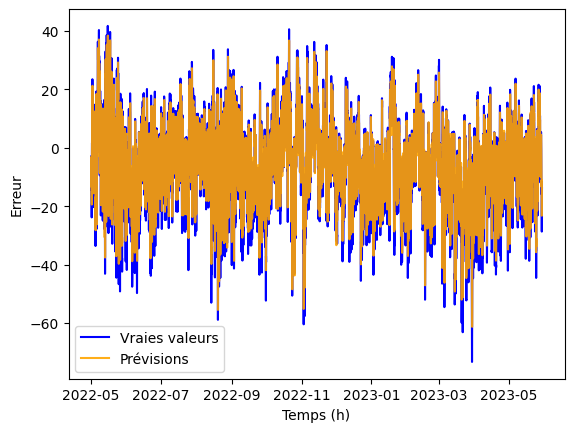

In [51]:
# Plot annuel
plot_all(data_test, "LSTM2PE_reglin_all", target="E_reglin_all")

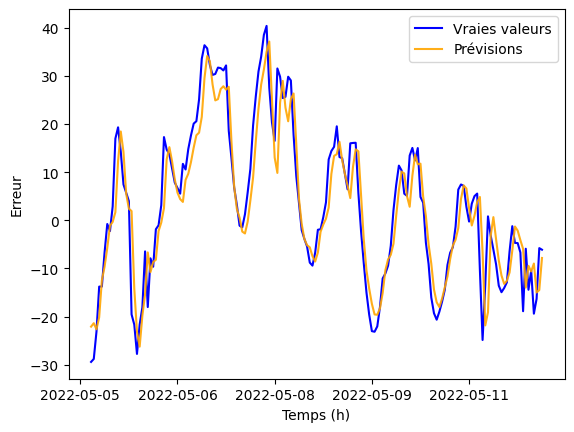

In [52]:
# Plot sur une semaine
plot_test_week(data_test, "LSTM2PE_reglin_all", target="E_reglin_all")

In [53]:
# On affiche les métriques
print_metrics(data_train, "LSTM2PE_reglin_all", target="E_reglin_all")
print_metrics(data_test, "LSTM2PE_reglin_all", target="E_reglin_all", type="prediction")

MAPE en estimation : 239.36%
RMSE en estimation : 6.59
MAPE en prediction : 180.38%
RMSE en prediction : 6.2


Graphiquement on fait vraiment beaucoup mieux, on prédit quasiment parfaitement. La RMSE est vraiement beaucoup plus basses que pour les régressions sur les résidus. Toutefois, on a accès à toutes les valeurs précédentes pour prédire la nouvelle valeur : c'est un peu de la triche !

In [54]:
# On affiche les métriques de la prévision d'ozone corrigée
data_train["LSTM2P_reglin_all"] = data_train["P_reglin_all"]+data_train["LSTM2PE_reglin_all"]
data_test["LSTM2P_reglin_all"] = data_test["P_reglin_all"]+data_test["LSTM2PE_reglin_all"]

print_metrics(data_train, "LSTM2P_reglin_all")
print_metrics(data_test, "LSTM2P_reglin_all", type="prediction")

MAPE en estimation : 9.33%
RMSE en estimation : 6.59
MAPE en prediction : 11.54%
RMSE en prediction : 6.2


Même si la MAPE n'était pas bonne pour les résidus (valeurs proches de 0), on a ici d'excellentes métriques. Si on avait souhaité prédire seulement à un horizon 1h, le modèle aurait été très satisfaisant.

### Modèle 3 (Ridge)

Cette fois-ci, on utilise toutes les variables comme dans le modèle précédent mais on applique une pénalité L2 pour contraindre les coefficients à ne pas exploser (régularisation ridge). 

Il a fallu plusieurs validations croisées pour avoir un meilleur paramètre qui n'était pas sur le bord de la grille. En affinant, on arrive à cette dernière validation croisée.

In [ ]:
# On définit le modèle et la grille de recherche 
ridge = Ridge(random_state=42)
param_grid = {"alpha": np.arange(700,722,2)}

# On recherche le meilleur paramètre par validation croisée
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(data_train[features], data_train["O3"])

# Meilleurs hyperparamètres
print("Meilleur alpha :", grid_search.best_params_["alpha"])
print("Meilleur score :", grid_search.best_score_)

# Meilleur estimateur
best_ridge = grid_search.best_estimator_

Meilleur alpha : 708
Meilleur score : -244.2217353914365


On a trouvé le meilleur paramètre qui permettait de maximiser l'opposé de l'erreur quadratique moyenne.

In [194]:
best_ridge.coef_

array([-0.76326004, -0.01839241, -1.50123823,  0.693538  ,  1.07387038,
        1.41191499, -0.40346039, -0.09852084,  3.6704529 , -0.08534678,
       -9.51592114, -0.16786149,  0.05162582, -1.04254227, -0.23283382,
        2.35753969,  0.30560221,  0.24703615,  0.05909221,  3.80367781,
        4.19335029,  3.64726195,  1.68872935, -1.3445205 , -3.11369722,
       -1.52466337, -0.35271057,  0.60284846,  1.71888238,  2.28179725,
        2.40844673,  2.13151338,  1.54184274,  0.43088219, -1.9237761 ,
       -2.8124174 , -3.9238759 , -4.68114556, -4.56266319, -3.28972669,
       -1.2963737 ,  0.52746505,  2.54404375,  6.15464304,  3.95553647,
       -0.60614662,  0.96031079, -1.10111255,  0.82021464,  1.81175314,
       -3.04366864, -6.34251893, -2.0986688 ])

Les coefficients sont dans des étendues plus raisonnables.

In [195]:
# On stocke les prévisions
data_train["P_ridge_all"] = best_ridge.predict(data_train[features])
data_test["P_ridge_all"] = best_ridge.predict(data_test[features])

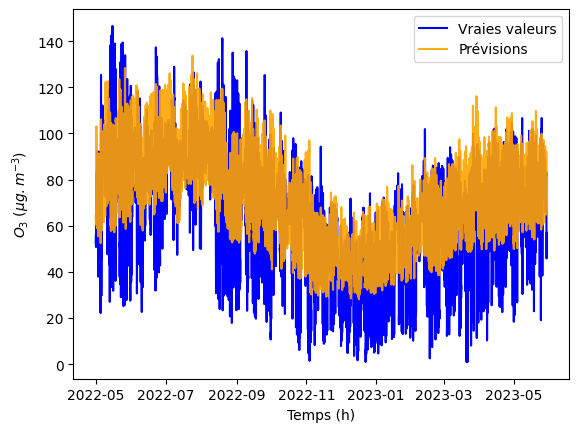

In [196]:
# Plot année
plot_all(data_test, "P_ridge_all")

Les prédictions semblent plus écrasées sur la deuxième partie du set de test.

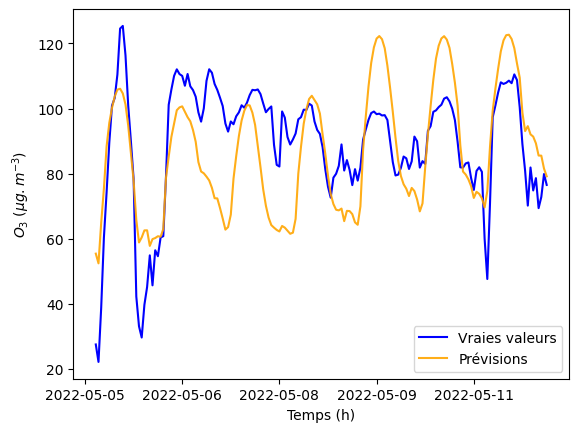

In [197]:
# Plot sur une semaine
plot_test_week(data_test, "P_ridge_all")

Difficile de dire autre chose par rapport aux graphiques du modèle 2.

In [198]:
print_metrics(data_train, "P_ridge_all")
print_metrics(data_test, "P_ridge_all")

MAPE en estimation : 28.47%
RMSE en estimation : 14.82
MAPE en estimation : 41.37%
RMSE en estimation : 16.37


On a naturellement des moins bonnes performances sur le train que le modèle 2. On n'a pas non plus d'amélioration sur le set de test.

En revanche, la différence est vraiment faible : quasiment aucune pour les RMSE et 2% moins bon sur la MAPE.

### Modèle 4 (Lasso)

Cette fois-ci, on garde les mêmes variables mais on applique une pénalisation L1 (régularisation Lasso).

De même que pour Ridge, il a fallu plusieurs validations croisées avant d'arriver à la cellule suivante et cette grille en particulier.

In [ ]:
# On définit le modèle et la grille de recherche 
lasso = Lasso(random_state=42)
param_grid = {"alpha": np.arange(0.02,0.1,0.01)}

# On recherche le meilleur paramètre par validation croisée
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(data_train[features], data_train["O3"])

# Meilleurs hyperparamètres
print("Meilleur alpha :", grid_search.best_params_["alpha"])
print("Meilleur score :", grid_search.best_score_)

# Meilleur estimateur
best_lasso= grid_search.best_estimator_

Meilleur alpha : 0.039999999999999994
Meilleur score : -230.1725764809217


In [200]:
# On affiche les variables dont le coefficient est mis à 0
coefficients_Lasso = best_lasso.coef_
variables = np.array(data_train[features].columns)[np.where([coefficients_Lasso == 0])[1]]
print(coefficients_Lasso)
print(variables)

[ -0.95148559   0.07445286  -1.32060299   0.6097703    0.
   1.26288213  -0.44018035  -0.           5.37528148  -0.05406093
 -11.2129796   -0.           0.04924206  -0.93742569  -0.
   2.80925548   0.18693173   0.07776298   0.           5.36032369
   6.13801114   5.06465805   1.22242353  -2.82038055  -6.24926006
  -3.06408684  -0.70010636   0.           1.59745747   2.7574913
   3.00902236   2.42371773   1.18387499  -0.          -3.99396828
  -5.87152627  -8.15082774  -9.71276441  -9.50880067  -7.01397906
  -3.09008596  -0.           4.61485362   9.16930916   5.27974856
  -1.30626646  -0.          -2.36173314   0.           1.92943885
  -3.63475901  -7.7600602   -1.15266907]
['VegitationHigh' 'PublicHolidays' 'DaySeasonality' 'Day_Saturday'
 'Day_Wednesday' 'Hour_9' 'Hour_15' 'Hour_23' 'Month_6' 'Month_8']


Comme les données sont complexes, le meilleur paramètre est petit et par conséquent, on met à 0 peu de coefficient. Toutefois, on remarque que la variable DaySeasonality est mise à 0 : une partie de son information est probablement contenue dans les modalités *Hour_x*.

In [201]:
# On stocke les prévisions
data_train["P_lasso_all"] = best_lasso.predict(data_train[features])
data_test["P_lasso_all"] = best_lasso.predict(data_test[features])

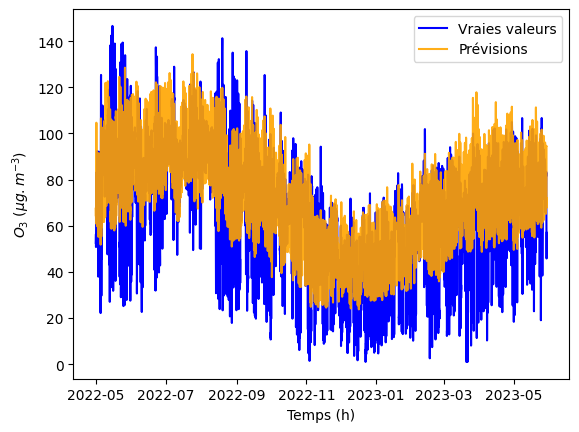

In [202]:
# Plot annuel
plot_all(data_test, "P_lasso_all")

On est un peu moins écrasé sur la fin que Ridge mais visuellement pas de gros changement par rapport aux modèles 2 et 3.

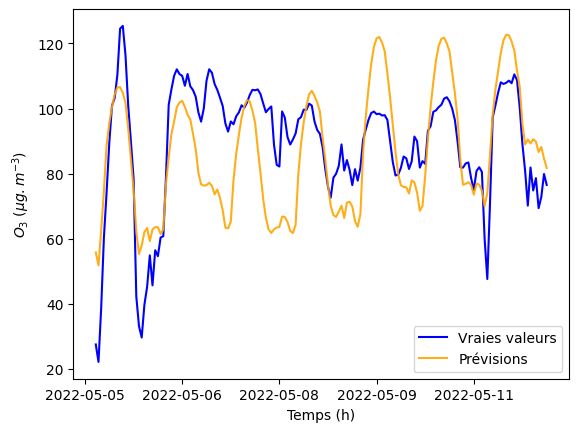

In [203]:
# Plot sur une semaine
plot_test_week(data_test, "P_lasso_all")

Pas de changement notable.

In [204]:
# On affiche les métriques
print_metrics(data_train, "P_lasso_all")
print_metrics(data_test, "P_lasso_all", type="prediction")

MAPE en estimation : 27.1%
RMSE en estimation : 14.5
MAPE en prediction : 40.15%
RMSE en prediction : 16.33


On fait globalement pareil que Ridge.

### Modèle 5 (Elasticnet)

Encore une fois, on garde les mêmes variables mais on utilise les régularisations Rige et Lasso simultanément (ElasticNet).

In [205]:
# On initie le modèle et on cherche la meilleure combinaison d'hyperparamètre par validation croisée
elastic_net_cv = ElasticNetCV(alphas=np.logspace(-4,4,100), l1_ratio=np.linspace(0.1, 1.0, 100), cv=5)

# On entraîne le modèle
elastic_net_cv.fit(data_train[features], data_train["O3"])

# Meilleur couple d'hyperparamètres
print(f"Meilleur alpha : {elastic_net_cv.alpha_}")
print(f"Meilleur l1_ratio (alpha dans Elastic Net) : {elastic_net_cv.l1_ratio_}")


Meilleur alpha : 0.03199267137797385
Meilleur l1_ratio (alpha dans Elastic Net) : 0.8181818181818181


In [206]:
# On stocke les prévisions
data_train["P_elasticnet_all"] = elastic_net_cv.predict(data_train[features])
data_test["P_elasticnet_all"] = elastic_net_cv.predict(data_test[features])

In [207]:
# On affiche les coefficients de la régression et les variables pour lesquels ils sont nuls
coef_en = elastic_net_cv.coef_
variables_en = np.array(data_train[features].columns)[np.where([coef_en == 0])[1]]
print(coef_en)
print(variables_en)


[ -0.92405132   0.06112149  -1.36569781   0.62655286   0.
   1.29893566  -0.42861916  -0.           5.09063178  -0.18731353
 -11.0079057   -0.           0.04876092  -0.97853673  -0.03466444
   2.80562827   0.29713396   0.19263376   0.           5.41145337
   6.09138031   5.14981405   1.77877224  -2.34083332  -5.33597717
  -2.52601772  -0.44053888   0.16774594   2.1587915    3.1734863
   3.39497249   2.88550836   1.80452586   0.          -3.30056477
  -4.94203724  -6.94175122  -8.3156389   -8.14377498  -5.96249449
  -2.52710938   0.           4.10291904   8.47837326   4.96847544
  -1.40653266   0.          -2.24051077   0.12754636   1.88495388
  -3.77418711  -7.74050253  -1.58389594]
['VegitationHigh' 'PublicHolidays' 'DaySeasonality' 'Day_Wednesday'
 'Hour_15' 'Hour_23' 'Month_6']


Ce sont globalement les mêmes variables que pour Lasos qui sont mise à 0. Toutefois, certaines ne l'ont pas été, on a moins de coefficients nuls que pour Lasso.

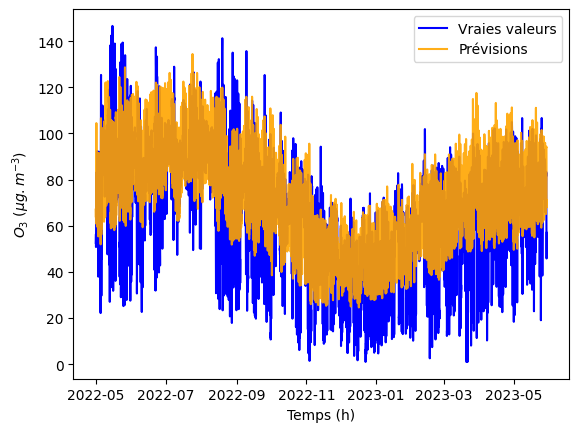

In [208]:
# Plot annuel
plot_all(data_test, "P_elasticnet_all")

Pas de changement manifeste sur l'année par rapport aux autres modèles.

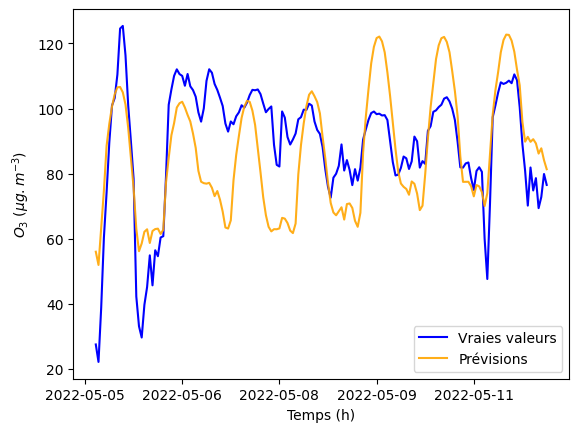

In [209]:
# Plot sur une semaine
plot_test_week(data_test, "P_elasticnet_all")

De même sur une semaine.

In [210]:
# On affiche les métriques
print_metrics(data_train, "P_elasticnet_all")
print_metrics(data_test, "P_elasticnet_all", type="prediction")

MAPE en estimation : 27.31%
RMSE en estimation : 14.53
MAPE en prediction : 40.35%
RMSE en prediction : 16.32


On a globalement les mêmes métriques que pour Ridge et Lasso.

### Modèle 5 résidus

#### Propriétés

In [211]:
# On stocke les résidus
data_train["E_elasticnet_all"] = data_train["O3"] - data_train["P_elasticnet_all"]
data_test["E_elasticnet_all"] = data_test["O3"] - data_test["P_elasticnet_all"]

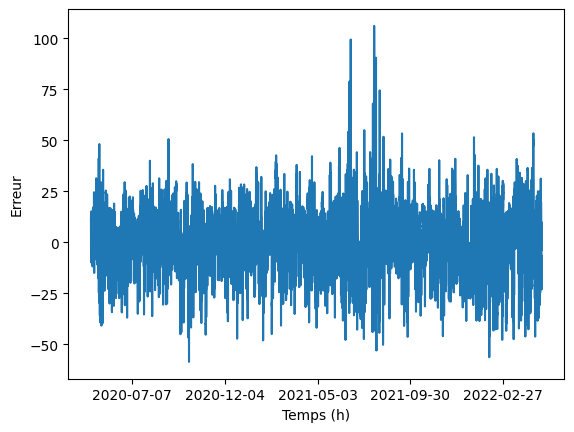

In [212]:
# plot erreur
plt.plot(data_train["Date"], data_train["E_elasticnet_all"])
plt.xlabel("Temps (h)")
plt.ylabel("Erreur")
plt.gca().xaxis.set_major_locator(MaxNLocator(6))
plt.show()

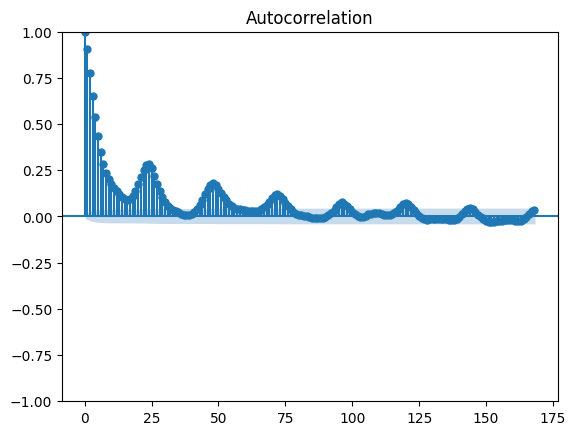

In [213]:
# Autocorrélation des résidus
plot_acf(data_train["E_elasticnet_all"], lags=168)
plt.show()

In [214]:
# On regarde la statistique de Durbin Watson
durbin_watson(data_train["E_elasticnet_all"])

0.18964579359100767

Mêmes conclusions que pour les résidus du modèle 2.

On regarde ce que donne la prévision par 0.

In [215]:
# On affiche les métriques pour une prévision des résidus par 0
data_train["P_zeros"] = 0.
data_test["P_zeros"] = 0.
print_metrics(data_train, "P_zeros", target="E_elasticnet_all")
print_metrics(data_test, "P_zeros", target="E_elasticnet_all", type="prediction")

MAPE en estimation : 100.0%
RMSE en estimation : 14.53
MAPE en prediction : 100.0%
RMSE en prediction : 16.32


#### Arbre de décision

In [ ]:
# On définit le modèle et la grille de recherche 
cart = DecisionTreeRegressor(random_state=42)
param_grid = {"ccp_alpha": np.arange(0.9,1.02,0.02)}

# On recherche le meilleur paramètre par validation croisée
grid_search = GridSearchCV(cart, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(data_train[features], data_train["E_elasticnet_all"])

# Meilleurs hyperparamètres
print("Meilleur ccp_alpha :", grid_search.best_params_["ccp_alpha"])
print("Meilleur score :", grid_search.best_score_)

# Meilleur estimateur
cart_elasticnet = grid_search.best_estimator_

Meilleur ccp_alpha : 0.9600000000000001
Meilleur score : -190.39299289324126


Encore une fois, on a un ccp_alpha très grand : mêmes conclusions que pour les résidus du modèle 2.

In [217]:
# On stocke les résultats
data_train["CPE_elasticnet_all"] = cart_elasticnet.predict(data_train[features])
data_test["CPE_elasticnet_all"] = cart_elasticnet.predict(data_test[features])

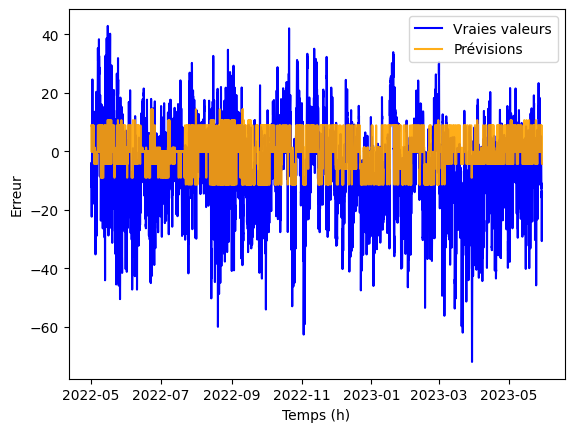

In [218]:
# Plot annuel
plot_all(data_test, "CPE_elasticnet_all", target="E_elasticnet_all")

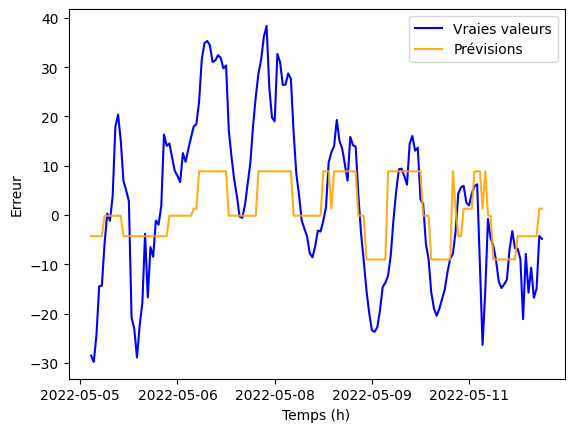

In [219]:
# Plot sur une semaine
plot_test_week(data_test, "CPE_elasticnet_all", target="E_elasticnet_all")

In [220]:
# On affiche les métriques pour l'erreur
print_metrics(data_train, "CPE_elasticnet_all", target="E_elasticnet_all")
print_metrics(data_test, "CPE_elasticnet_all", target="E_elasticnet_all", type="prediction")

MAPE en estimation : 258.33%
RMSE en estimation : 12.64
MAPE en prediction : 260.76%
RMSE en prediction : 14.55


On gagne 2 points de RMSE.

In [221]:
# On affiche les métriques pour la prévision de l'ozone corrigée
data_train["CP_elasticnet_all"] = data_train["P_elasticnet_all"] + data_train["CPE_elasticnet_all"]
data_test["CP_elasticnet_all"] = data_test["P_elasticnet_all"] + data_test["CPE_elasticnet_all"]

print_metrics(data_train, "CP_elasticnet_all")
print_metrics(data_test, "CP_elasticnet_all", type="prediction")

MAPE en estimation : 22.57%
RMSE en estimation : 12.64
MAPE en prediction : 34.57%
RMSE en prediction : 14.55


On gagne 6% de MAPE et 2 points de RMSE.

#### XGBOOST

In [222]:
# On utilise le gradient boosting avec des arbres sur les résidus
xgb = XGBRegressor(random_state=42, n_estimators=1000, learning_rate=0.05)

xgb.fit(data_train[features], data_train["E_elasticnet_all"])

# On stocke les prévisions
data_train["XGBPE_elasticnet_all"] = xgb.predict(data_train[features])
data_test["XGBPE_elasticnet_all"] = xgb.predict(data_test[features])

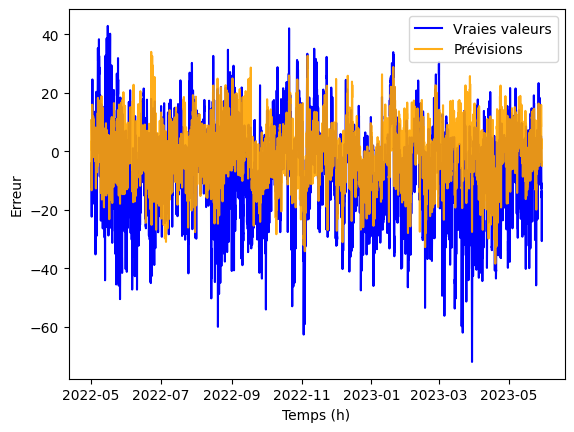

In [223]:
# Plot annuel
plot_all(data_test, "XGBPE_elasticnet_all", target="E_elasticnet_all") 

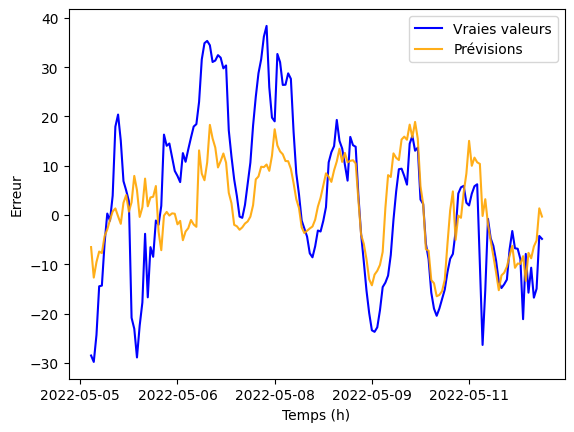

In [224]:
# Plot sur une semaine
plot_test_week(data_test, "XGBPE_elasticnet_all", target="E_elasticnet_all")

In [225]:
# On affiche les métriques
print_metrics(data_train, "XGBPE_elasticnet_all", target="E_elasticnet_all")
print_metrics(data_test,"XGBPE_elasticnet_all", target="E_elasticnet_all", type="prediction")

MAPE en estimation : 148.32%
RMSE en estimation : 4.46
MAPE en prediction : 300.51%
RMSE en prediction : 14.31


On gagne 2 points de RMSE.

In [226]:
# On regarde les métriques pour la prévision d'ozone corrigée
data_train["XGBP_elasticnet_all"] = data_train["P_elasticnet_all"] + data_train["XGBPE_elasticnet_all"]
data_test["XGBP_elasticnet_all"] = data_test["P_elasticnet_all"] + data_test["XGBPE_elasticnet_all"]

print_metrics(data_train, "XGBP_elasticnet_all")
print_metrics(data_test,"XGBP_elasticnet_all", type="prediction")

MAPE en estimation : 6.72%
RMSE en estimation : 4.46
MAPE en prediction : 31.37%
RMSE en prediction : 14.31


On gagne 9% de MAPE et 2 points de RMSE.

#### Perceptron multi-couches

In [ ]:
# On prépare les données pour le PMC
PMC_input_scaler = mm_scaler()
PMC_input_scaler.fit(data_train[features], 
               quantitatives= ["WindSpeedU",
                            "WindSpeedV",
                            "DewpointTemp",
                            "TotalPrecipitation",
                            "VegitationHigh",
                            "Temp",
                            "RelativeHumidity",
                            "YearSeasonality",
                            "DaySeasonality",
                            "Fires"])
X_train = PMC_input_scaler.transform(data_train[features])
X_test = PMC_input_scaler.transform(data_test[features])

PMC_output_scaler = mm_scaler()
PMC_output_scaler.fit(data_train["E_elasticnet_all"])
y_train = PMC_output_scaler.transform(data_train["E_elasticnet_all"])
y_test = PMC_output_scaler.transform(data_test["E_elasticnet_all"])

# On entraine le modèle
nn_model = MLPRegressor(hidden_layer_sizes=(256, 128), random_state=42, learning_rate="adaptive", max_iter=100000)

nn_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(256, 128), learning_rate='adaptive',
             max_iter=100000, random_state=42)

In [228]:
# On stocke les prédictions
data_train["NNPE_elasticnet_all"] = PMC_output_scaler.transform_inverse(nn_model.predict(X_train))
data_test["NNPE_elasticnet_all"] = PMC_output_scaler.transform_inverse(nn_model.predict(X_test))

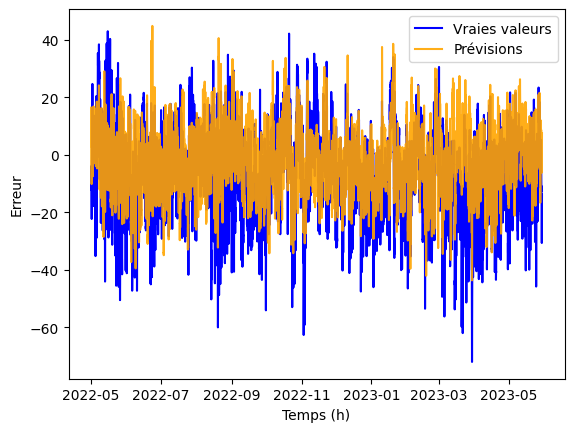

In [229]:
# Plot annuel
plot_all(data_test, "NNPE_elasticnet_all", target="E_elasticnet_all")

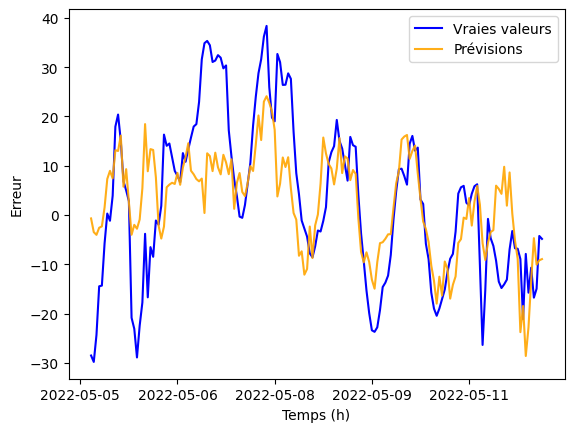

In [230]:
# Plot sur une semaine
plot_test_week(data_test, "NNPE_elasticnet_all", target="E_elasticnet_all")

In [231]:
# On affiche les métriques
print_metrics(data_train, "NNPE_elasticnet_all", target="E_elasticnet_all")
print_metrics(data_test,"NNPE_elasticnet_all", target="E_elasticnet_all", type="prediction")

MAPE en estimation : 301.45%
RMSE en estimation : 8.97
MAPE en prediction : 347.97%
RMSE en prediction : 14.43


On gagne 2 points de RMSE.

In [232]:
# On affiche les métriques de la prévision d'ozone corrigée
data_train["NNP_elasticnet_all"] = data_train["P_elasticnet_all"]+data_train["NNPE_elasticnet_all"]
data_test["NNP_elasticnet_all"] = data_test["P_elasticnet_all"]+data_test["NNPE_elasticnet_all"]

print_metrics(data_train, "NNP_elasticnet_all")
print_metrics(data_test, "NNP_elasticnet_all", type="prediction")

MAPE en estimation : 14.22%
RMSE en estimation : 8.97
MAPE en prediction : 31.09%
RMSE en prediction : 14.43


On gagne 9% de MAPE (un petit peu plus que XGBOOST) et 2 points de RMSE par rapport à la régression initiale.

#### LSTM

In [ ]:
# Construction des sets d'entraînement et de test
X_train, y_train, X_test, y_test, scaler = prepare_RNN(data_train, data_test, "E_elasticnet_all", lag_size=4, h=48)

# Pour la reproductibilité
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

# Construction du modèle
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu", return_sequences=False),
    Dense(1, activation="linear")
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse")

# Entraînement initial
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

Epoch 1/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0755
Epoch 2/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0073
Epoch 3/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0072
Epoch 4/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0072
Epoch 5/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0072


In [234]:
# On stocke les résultats
data_train["LSTMPE_elasticnet_all"] = 0.
data_train.loc[51:,"LSTMPE_elasticnet_all"] = scaler.transform_inverse(model.predict(X_train))
data_test["LSTMPE_elasticnet_all"] = scaler.transform_inverse(model.predict(X_test))

546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


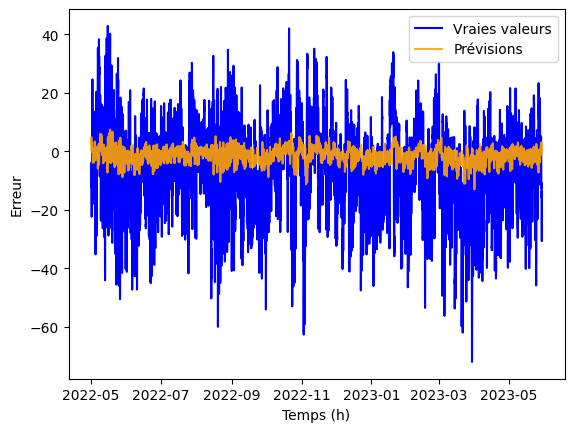

In [235]:
# Plot annuel
plot_all(data_test, "LSTMPE_elasticnet_all", target="E_elasticnet_all")

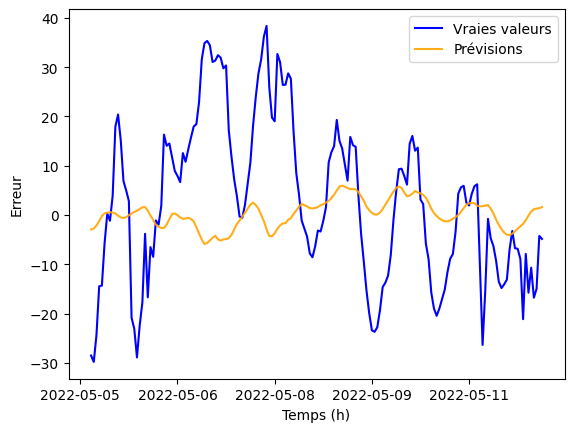

In [236]:
# Plot sur une semaine
plot_test_week(data_test, "LSTMPE_elasticnet_all", target="E_elasticnet_all")

In [237]:
# On affiche les métriques
print_metrics(data_train, "LSTMPE_elasticnet_all", target="E_elasticnet_all")
print_metrics(data_test, "LSTMPE_elasticnet_all", target="E_elasticnet_all", type="prediction")

MAPE en estimation : 176.21%
RMSE en estimation : 14.33
MAPE en prediction : 146.4%
RMSE en prediction : 15.51


Mêmes conclusions que pour les résidus du modèle 2 : LSTM ne semble pas en mesure de pouvoir prédire les résidus avec un lag de deux jours.

On a par ailleurs testé avec des batch_size plus petits et un nombre d'epochs plus grands mais le réseau converge toujours vers la même erreur (entre 0.070 et 0.080). 

In [238]:
# On affiche les métriques de la prévision d'ozone corrigée
data_train["LSTMP_elasticnet_all"] = data_train["P_elasticnet_all"]+data_train["LSTMPE_elasticnet_all"]
data_test["LSTMP_elasticnet_all"] = data_test["P_elasticnet_all"]+data_test["LSTMPE_elasticnet_all"]

print_metrics(data_train, "LSTMP_elasticnet_all")
print_metrics(data_test, "LSTMP_elasticnet_all", type="prediction")

MAPE en estimation : 26.71%
RMSE en estimation : 14.33
MAPE en prediction : 37.7%
RMSE en prediction : 15.51


On améliore moins bien les résultats de la régression qu'un arbre de décision, XGBOOST ou un PMC.

In [ ]:
# Construction des sets d'entraînement et de test
X_train, y_train, X_test, y_test, scaler = prepare_RNN(data_train, data_test, "E_elasticnet_all", lag_size=4, h=1)

# Pour la reproductibilité
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

# Construction du modèle
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(64, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(32, activation="relu", return_sequences=False),
    Dense(1, activation="linear")
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse")

# Entraînement initial
model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

Epoch 1/10


c:\Users\Valen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0531
Epoch 2/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0036
Epoch 3/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0032
Epoch 4/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0025
Epoch 5/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0020
Epoch 6/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0019
Epoch 7/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0018
Epoch 8/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0017
Epoch 9/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0016
Epoch 10/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0016


In [241]:
# On stocke les résultats
data_train["LSTM2PE_elasticnet_all"] = 0.
data_train.loc[4:,"LSTM2PE_elasticnet_all"] = scaler.transform_inverse(model.predict(X_train))
data_test["LSTM2PE_elasticnet_all"] = scaler.transform_inverse(model.predict(X_test))

548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


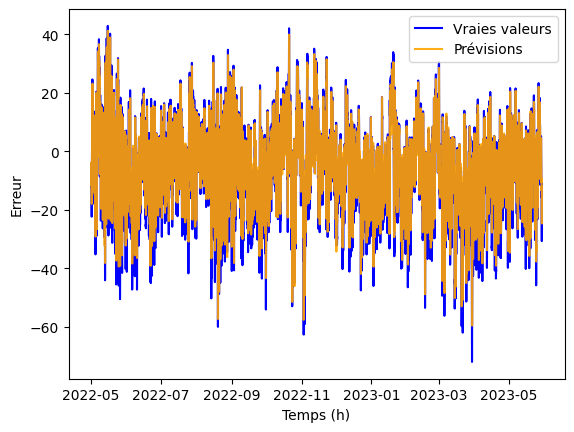

In [242]:
# Plot annuel
plot_all(data_test, "LSTM2PE_elasticnet_all", target="E_elasticnet_all")

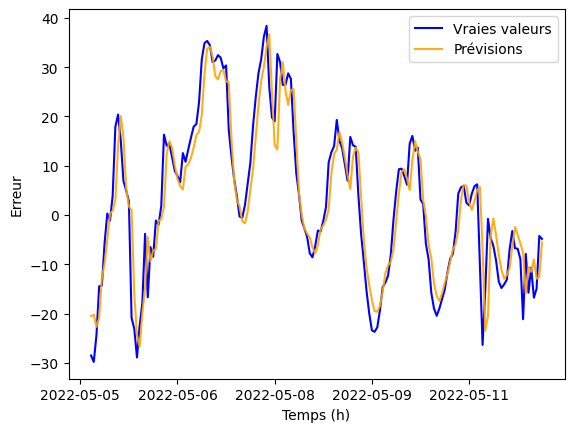

In [243]:
# Plot sur une semaine
plot_test_week(data_test, "LSTM2PE_elasticnet_all", target="E_elasticnet_all")

In [244]:
# On affiche les métriques
print_metrics(data_train, "LSTM2PE_elasticnet_all", target="E_elasticnet_all")
print_metrics(data_test, "LSTM2PE_elasticnet_all", target="E_elasticnet_all", type="prediction")

MAPE en estimation : 204.47%
RMSE en estimation : 6.55
MAPE en prediction : 152.26%
RMSE en prediction : 6.21


In [245]:
# On affiche les métriques de la prévision d'ozone corrigée
data_train["LSTM2P_elasticnet_all"] = data_train["P_elasticnet_all"]+data_train["LSTM2PE_elasticnet_all"]
data_test["LSTM2P_elasticnet_all"] = data_test["P_elasticnet_all"]+data_test["LSTM2PE_elasticnet_all"]

print_metrics(data_train, "LSTM2P_elasticnet_all")
print_metrics(data_test, "LSTM2P_elasticnet_all", type="prediction")

MAPE en estimation : 9.43%
RMSE en estimation : 6.55
MAPE en prediction : 11.71%
RMSE en prediction : 6.21


Sans délai, on améliore effectivement énormément les performances du modèles.

En définitive, on peine à bien prédire nos résidus en régression et les modèles de séries temporelles ont de mauvaises performances avec un horizon trop lointain. Si ne parvient pas bien à prédire nos résidus c'est aussi parce que l'erreur n'est pas la même sur le set de train que sur le set de test (l'erreur est en générale plus petite sur le train et n'a peut-être pas le même comportement que sur le test). Si à l'avenir un modèle devait avoir un trop gros écart entre les deux résidus, nous renoncerions à prédire les résidus. Ou bien, il faudrait avoir un autre set différent du train pour pouvoir entrainer un modèle pour les résidus et comparer nos résultats sur un dernier set de test qui n'aurait été utilisé ni pour la régression sur l'O3, ni pour ses résidus.

### Modèle 2 en ligne

On décide de faire une mise en ligne pondérée du modèle 2 sur le set de test :  la mise à jour du modèles se fait tous les deux jours avec les 48 nouvelles données.

In [ ]:
# Mise en ligne
data_test["POW_reglin_all"] = 0.
mu = 0.999
batch_size = 24 * 2 

for t in range(1, (len(data_test) // batch_size) + 1):
    if t == 1:
        reglinW = reglin_all
    else:
        data_train_online = pd.concat([data_train, data_test.iloc[:(t - 1) * batch_size]]).copy()
        weights = np.power(mu*np.ones(len(data_train_online)), np.arange(len(data_train_online),0,-1))
        reglinW = LinearRegression()
        reglinW.fit(data_train_online[features], data_train_online["O3"], sample_weight=weights)

    start_idx = (t - 1) * batch_size
    end_idx = min(t * batch_size, len(data_test))

    data_test.loc[data_test.index[start_idx:end_idx], "POW_reglin_all"] = reglinW.predict(data_test[features].iloc[start_idx:end_idx])

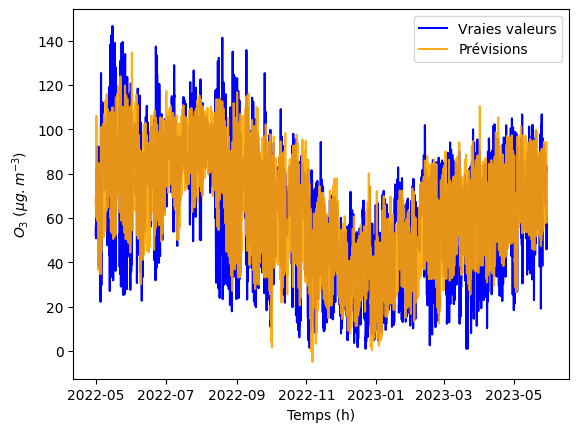

In [247]:
# Plot annuel
plot_all(data_test, "POW_reglin_all")

On voit une vraie différence par rapport aux prévisions initiales : on colle mieux aux vraies données et à leur étendue (de manière locale).

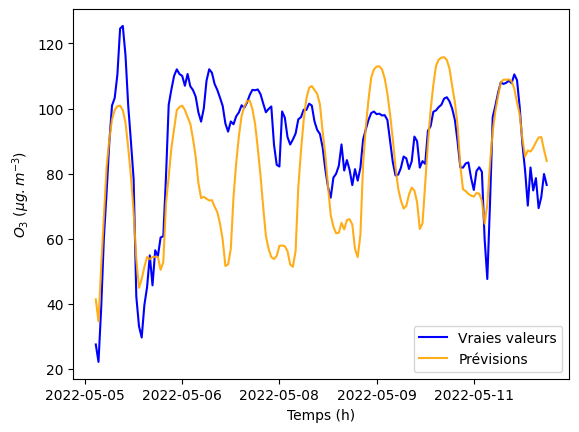

In [248]:
# Plot sur une semaine
plot_test_week(data_test, "POW_reglin_all")

La prédiction est plutôt bonne pour le premier jour et le dernier jour, un peu moins pour les autres jours.

In [249]:
# On affiche les métriques
print_metrics(data_test, "POW_reglin_all", type="prediction")

MAPE en prediction : 30.49%
RMSE en prediction : 15.2


On gagne 9 points en MAPE et 1 en RMSE par rapport à la régression initiale.

### Modèle 2 et résidus (XGBOOST) en ligne

On fait la mise en ligne à la fois de la régression linéaire mais aussi de la prédiction sur les résidus. Avec la regréssion initiale, XGBOOST avait le meilleur rapport qualité de prédiction / temps d'entraînement, on l'utilisera donc ici.

In [ ]:
# Mise en ligne
data_test["RPOW_reglin_all"] = 0.
mu = 0.999
batch_size = 24 * 2 

for t in range(1, (len(data_test) // batch_size) + 1):
    if t == 1:
        reglinW = reglin_all
        xgbW = xgb
    else:
        data_train_online = pd.concat([data_train, data_test.iloc[:(t - 1) * batch_size]]).copy()
        weights = np.power(mu*np.ones(len(data_train_online)), np.arange(len(data_train_online),0,-1))
        
        reglinW = LinearRegression()
        reglinW.fit(data_train_online[features], data_train_online["O3"], sample_weight=weights)
        
        error = data_train_online["O3"] - reglinW.predict(data_train_online[features])
        xgbW = XGBRegressor(random_state=42, n_estimators=1000, learning_rate=0.05)
        xgbW.fit(data_train_online[features],error,sample_weight=weights)

    start_idx = (t - 1) * batch_size
    end_idx = min(t * batch_size, len(data_test))

    data_test.loc[data_test.index[start_idx:end_idx], "RPOW_reglin_all"] = reglinW.predict(data_test[features].iloc[start_idx:end_idx]) + \
                                                                           xgbW.predict(data_test[features].iloc[start_idx:end_idx])

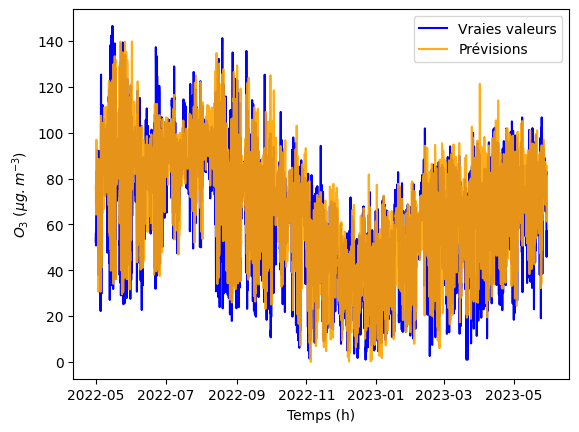

In [62]:
# Plot annuel
plot_all(data_test, "RPOW_reglin_all")

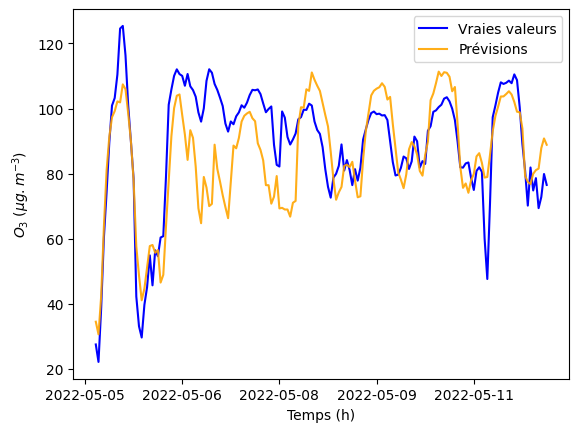

In [63]:
# Plot sur une semaine
plot_test_week(data_test, "RPOW_reglin_all")

In [64]:
print_metrics(data_test, "RPOW_reglin_all", type="prediction")

MAPE en prediction : 23.68%
RMSE en prediction : 12.49


On gagne :
- 16% de MAPE et 4 points de RMSE (-25%) par rapport à la régression initiale 
- 8% de MAPE et 2 points de RMSE par rapport à la régression + prévision sur les résidus 
- 7% de MAPE et 3 points de RMSE par rapport à la régression seule en ligne

### Modèle 5 en ligne

On fait la même chose avec le modèle 5.

In [ ]:
# Mise en ligne
data_test["POW_elasticnet_all"] = 0.
mu = 0.999
batch_size = 24 * 2 

for t in range(1, (len(data_test) // batch_size) + 1):
    if t == 1:
        reglinW = elastic_net_cv
    else:
        data_train_online = pd.concat([data_train, data_test.iloc[:(t - 1) * batch_size]]).copy()
        weights = np.power(mu*np.ones(len(data_train_online)), np.arange(len(data_train_online),0,-1))
        reglinW = ElasticNet(alpha=elastic_net_cv.alpha_, l1_ratio=elastic_net_cv.l1_ratio_)
        reglinW.fit(data_train_online[features], data_train_online["O3"], sample_weight=weights)

    start_idx = (t - 1) * batch_size
    end_idx = min(t * batch_size, len(data_test))

    data_test.loc[data_test.index[start_idx:end_idx], "POW_elasticnet_all"] = reglinW.predict(data_test[features].iloc[start_idx:end_idx])

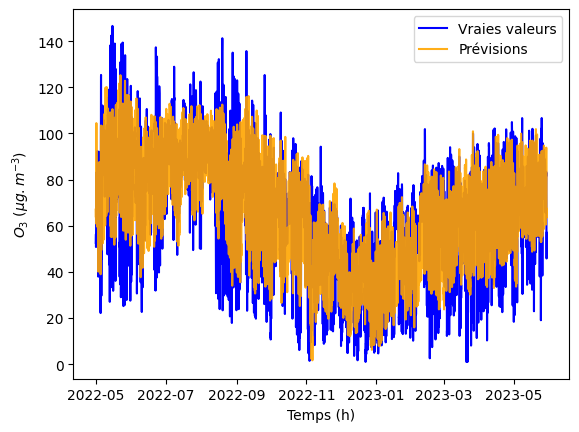

In [251]:
# Plot annuel
plot_all(data_test, "POW_elasticnet_all")

Même chose, on semble mieux coller aux vraies données sur l'ensemble du set de test.

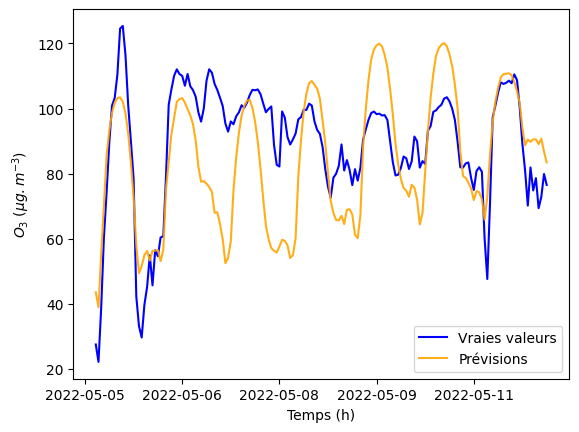

In [252]:
# Plot sur une semaine
plot_test_week(data_test, "POW_elasticnet_all")

Encore une fois, on s'ajuste beaucoup mieux sur le premier et le dernier jour, moins bien sur les autres : ce sont peut-être des jours particulier qui sortent de l'ordinaire (l'alternance jour-nuit est notamment moins marquée).

In [253]:
# On affiche les métriques
print_metrics(data_test, "POW_elasticnet_all", type="prediction")

MAPE en prediction : 30.67%
RMSE en prediction : 14.72


On gagne 10 points en MAPE et 1.5 sur la RMSE. C'est toutefois plus lourd d'entraîner un modèle de régression linéaire avec un régularisation Ridge et Lasso : s'il fait légèrement mieux en RMSE que le modèle 2 bis, la différence n'est pas flagrante.

### Modèle 5 et résidus (XGBOOST) en ligne

In [ ]:
# Mise en ligne
data_test["RPOW_elasticnet_all"] = 0.
mu = 0.999
batch_size = 24 * 2

for t in range(1, (len(data_test) // batch_size) + 1):
    if t == 1:
        reglinW = elastic_net_cv
        xgbW = xgb
    else:
        data_train_online = pd.concat([data_train, data_test.iloc[:(t - 1) * batch_size]]).copy()
        weights = np.power(mu*np.ones(len(data_train_online)), np.arange(len(data_train_online),0,-1))

        reglinW = ElasticNet(alpha=elastic_net_cv.alpha_, l1_ratio=elastic_net_cv.l1_ratio_)
        reglinW.fit(data_train_online[features], data_train_online["O3"], sample_weight=weights)

        error = data_train_online["O3"] - reglinW.predict(data_train_online[features])
        xgbw = XGBRegressor(random_state=42, n_estimators=1000, learning_rate=0.05)
        xgbW.fit(data_train_online[features],error,sample_weight=weights)

    start_idx = (t - 1) * batch_size
    end_idx = min(t * batch_size, len(data_test))

    data_test.loc[data_test.index[start_idx:end_idx], "RPOW_elasticnet_all"] = reglinW.predict(data_test[features].iloc[start_idx:end_idx]) + \
                                                                               xgbW.predict(data_test[features].iloc[start_idx:end_idx])

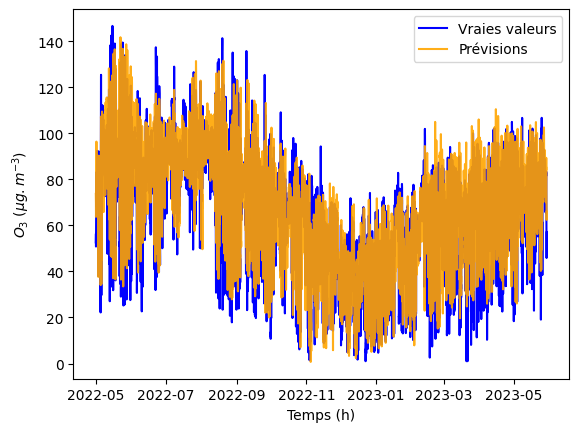

In [177]:
# Plot annuel
plot_all(data_test, "RPOW_elasticnet_all")

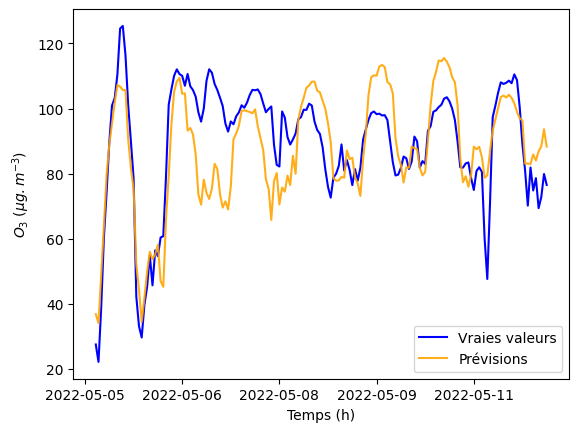

In [178]:
# Plot sur une semaine
plot_test_week(data_test, "RPOW_elasticnet_all")

In [179]:
# On affiche les métriques
print_metrics(data_test, "RPOW_elasticnet_all", type="prediction")

MAPE en prediction : 23.25%
RMSE en prediction : 11.81


## Arbres de décision et forêts aléatoires

In [122]:
features = [feature for feature in df.columns if feature not in ["Date", "O3"]]

### Modèle 1 (Arbre de décision)

On entraîne un arbre de décision avec toutes les variables disponibles (sans considération sur la colinéarité). Pour le premier modèle, on regardera un arbre complètement développé.

In [ ]:
# On entraîne un arbre de décision
cart = DecisionTreeRegressor(random_state=42).fit(data_train[features],data_train["O3"])

data_train["P_tree_all"] = cart.predict(data_train[features])
data_test["P_tree_all"]  = cart.predict(data_test[features])

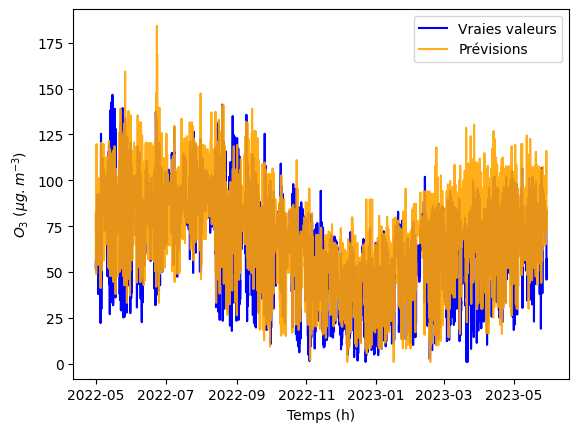

In [256]:
# Plot annuel
plot_all(data_test, "P_tree_all")

On capte bien le motif sur l'année mais contrario de la régression linéaire, on capte aussi l'amplitude locale des vraies données. 

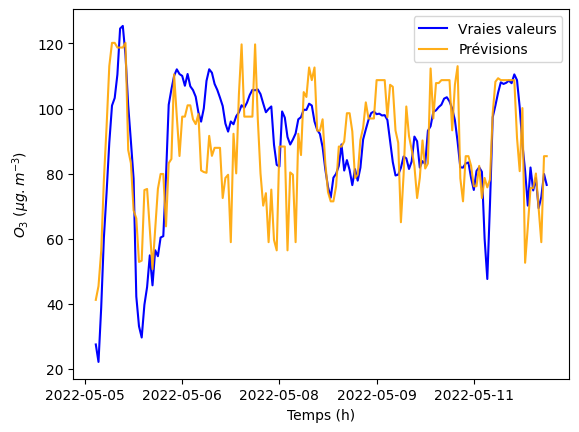

In [257]:
plot_test_week(data_test, "P_tree_all")

La courbe de prévision est très hachée, on remarque bien que l'arbre décision approxime une fonction en escalier. On retrouve bien l'aternance jour nuit et on capte très bien l'amplitude des données. Le premier et le dernier jour sont bien prédits et les autres jours on une amplitude mieux respectée que la régression linéaire.

In [258]:
# On affiche les métriques
print_metrics(data_train, "P_tree_all")
print_metrics(data_test, "P_tree_all", type="prediction")

MAPE en estimation : 0.0%
RMSE en estimation : 0.0
MAPE en prediction : 37.95%
RMSE en prediction : 18.2


Naturellement, on a une erreur de 0 sur le set de train car l'arbre est complètement développé. Avec un simple arbre, on fait mieux que le benchmark et que la régression linéaire (sans la mise à jour du modèle en ligne).

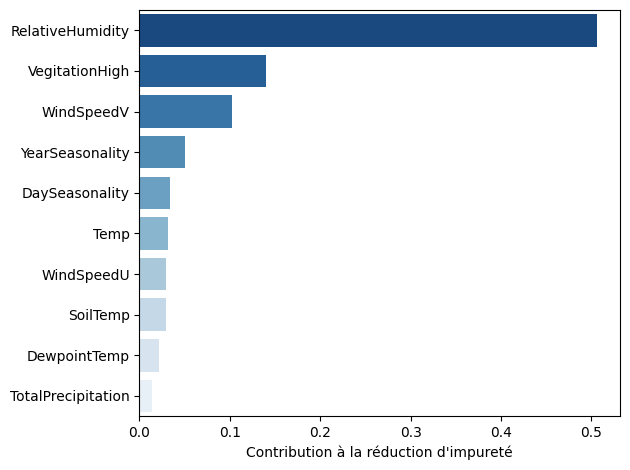

In [259]:
# On affiche les features importances
plot_importance(cart, features)

La moitié de la réduction d'impureté dans les noeuds de l'arbre est due à des coupures dans la direction de *RelativeHumidity*. La concentration en vapeur d'eau dans l'atmosphère doit d'une part avoir un impact sur la chimie de l'air et d'autre part contenir une partie de l'information d'une variable latente importante à savoir l'ensoleillement.

De même pour vegitation high : on a un couvert végétal haut plus important au printemps et en été lorsuqe l'ensoleillement est plus long.

### Modèle 2 (Arbre de décision pruné)

On applique le pruning sur l'arbre complètement développé pour éviter l'overfitting.

In [ ]:
# On initialise le modèle
reg = DecisionTreeRegressor(random_state=42)

# On recherche le meilleur ccp_alpha
param_grid = {"ccp_alpha": np.arange(0.4,1.1,0.1)}
grid_search = GridSearchCV(reg, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(data_train[features], data_train["O3"])

# Meilleur hyperparamètre
print("Meilleur ccp_alpha :", grid_search.best_params_["ccp_alpha"])
print("Meilleure précision :", grid_search.best_score_)

# Meilleur estimateur
cart_pruned = grid_search.best_estimator_


Meilleur ccp_alpha : 0.6
Meilleure précision : -236.5478526440295


In [261]:
data_train["P_tree_pruned"] = cart_pruned.predict(data_train[features])
data_test["P_tree_pruned"] = cart_pruned.predict(data_test[features])

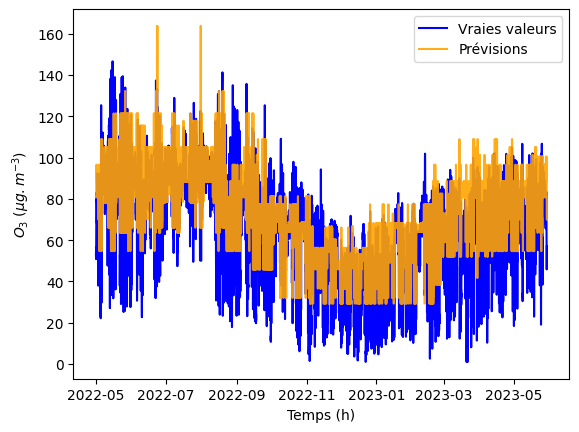

In [262]:
# Plot annuel
plot_all(data_test, "P_tree_pruned")

Le paramètre de pruning est assez élevé, on respecte moins l'amplitude des vraies données.

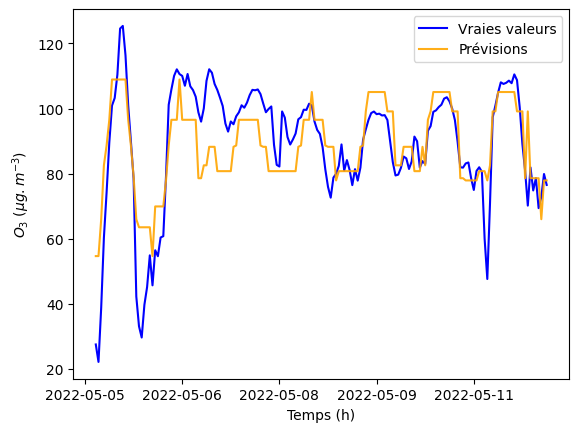

In [263]:
# Plot sur une semaine
plot_test_week(data_test, "P_tree_pruned")

Sur cette semaine, les prédictions sont plutôt bonnes pour un seule arbre.

In [264]:
# On affiche les métriques
print_metrics(data_train, "P_tree_pruned")
print_metrics(data_test, "P_tree_pruned", type="prediction")

MAPE en estimation : 22.21%
RMSE en estimation : 12.41
MAPE en prediction : 37.96%
RMSE en prediction : 15.76


On a la même MAPE par rapport à l'arbre complètement développé mais on gagne plus de 2 points de RMSE.

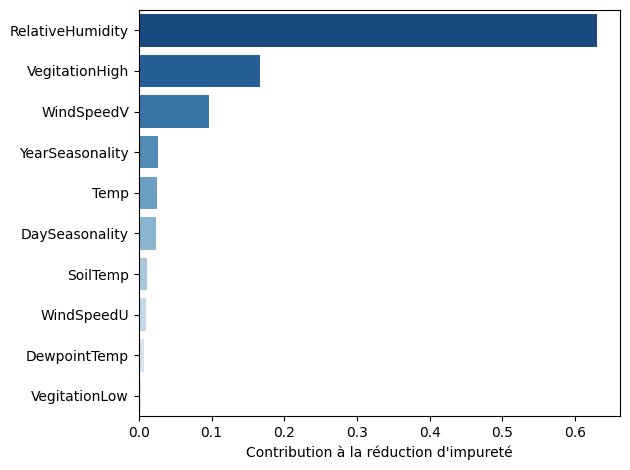

In [265]:
# On affiche les features importances
plot_importance(cart_pruned, features)

Mêmes conclusions que pour l'arbre entièrement développé. Par ailleurs on a trop d'écart entre l'erreur sur le train et le test, on ne tente pas de prédire les résidus.

### Modèle 2 en ligne

In [ ]:
# Mise en ligne
data_test["POW_tree_pruned"] = 0.
mu = 0.999
batch_size = 24 * 2 

for t in range(1, (len(data_test) // batch_size) + 1):
    if t == 1:
        cartW = cart_pruned
    else:
        data_train_online = pd.concat([data_train, data_test.iloc[:(t - 1) * batch_size]]).copy()
        weights = np.power(mu*np.ones(len(data_train_online)), np.arange(len(data_train_online),0,-1))
        cartW = DecisionTreeRegressor(ccp_alpha=grid_search.best_params_["ccp_alpha"], random_state=42)
        cartW.fit(data_train_online[features], data_train_online["O3"], sample_weight=weights)

    start_idx = (t - 1) * batch_size
    end_idx = min(t * batch_size, len(data_test))

    data_test.loc[data_test.index[start_idx:end_idx], "POW_tree_pruned"] = cartW.predict(data_test[features].iloc[start_idx:end_idx])

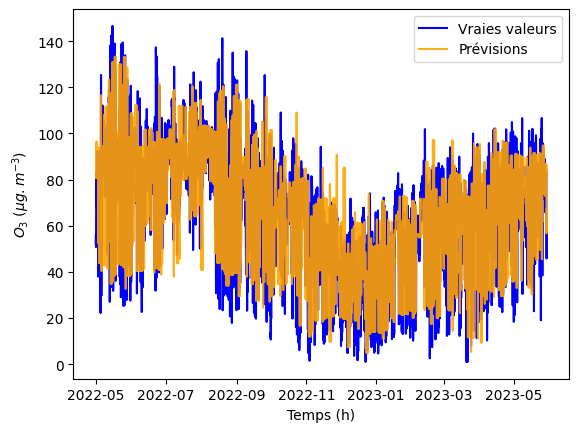

In [297]:
# Plot annuel
plot_all(data_test, "POW_tree_pruned")

C'est visuellement assez impressionnant, on semble très bien coller aux vraies données. En revanche, le set de test contient beaucoup d'observations, on ne peut pas voir le comportement local des prévisions par rapport aux vraies valeurs.

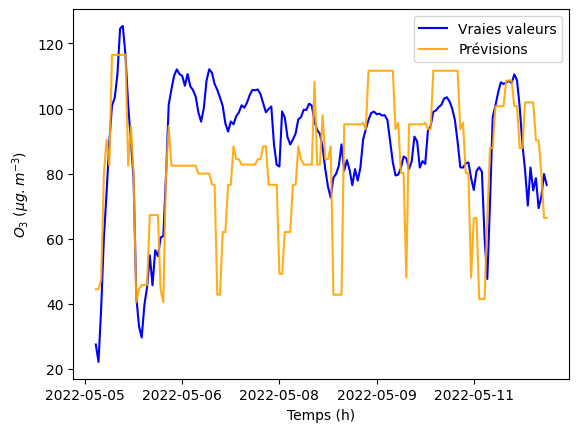

In [298]:
# Plot sur une semaine
plot_test_week(data_test, "POW_tree_pruned")

C'est effectivement moins impressionnant localement, bien qu'on soit très bon sur le premier et le dernier jour.

In [299]:
# On affiche les métriques
print_metrics(data_test, "POW_tree_pruned", type="prediction")

MAPE en prediction : 29.09%
RMSE en prediction : 15.19


On gagne 7 points de MAPE et un peu plus de 1 point de RMSE.

### Modèle 3 (Forêt Aléatoire)

In [ ]:
# Random Forest avec 100 arbres
rf = RandomForestRegressor(random_state=42).fit(data_train[features], data_train["O3"])

# On stocke les prédictions
data_train["P_forest_all"] = rf.predict(data_train[features])
data_test["P_forest_all"]  = rf.predict(data_test[features])

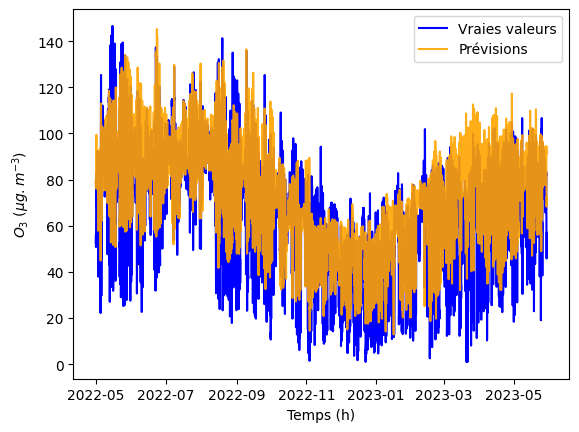

In [294]:
# Plot annuel
plot_all(data_test, "P_forest_all")

On semble manquer une partie de l'amplitude des données sur certaines périodes.

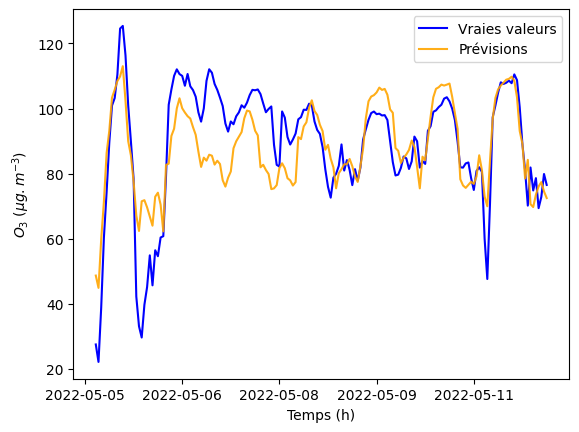

In [295]:
# Plot sur une semaine
plot_test_week(data_test, "P_forest_all")

Cette fois-ci, on est très proche de la forme des vraies valeurs, sur tous les jours de la semaine. La prédiction est vraiment satisfaisante.

In [296]:
# On affiche les métriques
print_metrics(data_train, "P_forest_all")
print_metrics(data_test, "P_forest_all", type="prediction")

MAPE en estimation : 4.46%
RMSE en estimation : 2.91
MAPE en prediction : 33.38%
RMSE en prediction : 14.47


On fait mieux que la régression linéaire et les arbres de décision seuls (sans mise à jour en ligne).

### Modèle 4 (Forêt Aléatoire tunée)

Sur la base des cours sur les forêts aléatoires d'Erwan Scornet, l'hyperparamètre susceptible d'avoir le plus d'influence sur la qualité du modèle est le nombre de directions aléatoires qu'on tire pour chaque coupure. On a souhaité ajouter un petit pruning pour éviter le surapprentissage.

In [ ]:
# Attention : cette cellule met BEAUCOUP de temps à tourner, meilleur combinaison : ccp_alpha=0.05, max_features = 30

# On initialise le modèle
reg = RandomForestRegressor(random_state=42)

# On recherche le meilleur max_features
param_grid = {"max_features": [10, 20, 30, 40, 50, 58], "ccp_alpha":[0.01,0.05,0.1,0.2]}  # Valeurs
grid_search = GridSearchCV(reg, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(data_train[features], data_train["O3"])

In [124]:
# Meilleur hyperparamètre
print("Meilleur max_features :", grid_search.best_params_["max_features"])
print("Meilleur ccp_alpha :", grid_search.best_params_["ccp_alpha"])
print("Meilleure précision :", grid_search.best_score_)

# Meilleur estimateur
rf_tuned = grid_search.best_estimator_

Meilleur max_features : 30
Meilleur ccp_alpha : 0.05
Meilleure précision : -193.43380613702462


In [125]:
# On stocke les prédiction
data_train["P_forest_tuned"] = rf_tuned.predict(data_train[features])
data_test["P_forest_tuned"] = rf_tuned.predict(data_test[features])

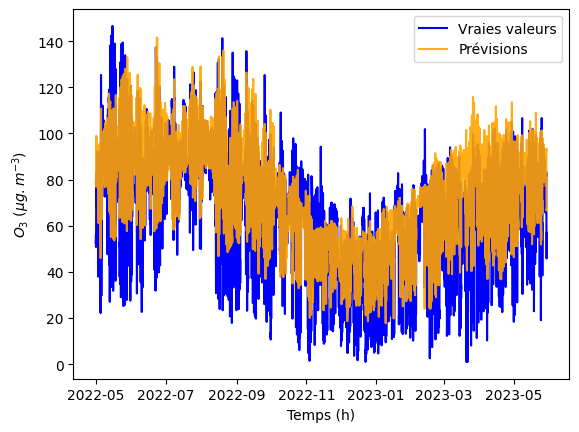

In [126]:
# Plot annuel
plot_all(data_test, "P_forest_tuned")

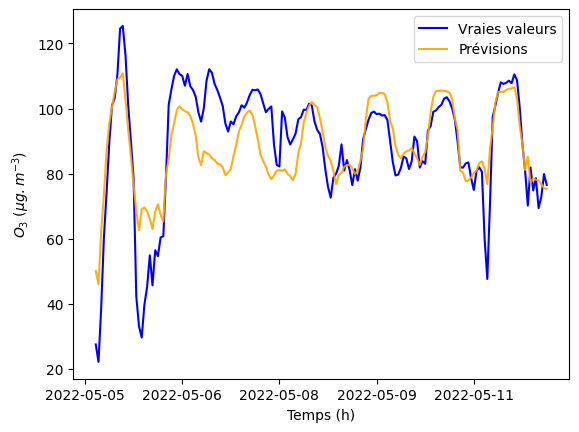

In [127]:
# Plot sur une semaine
plot_test_week(data_test, "P_forest_tuned")

Les prédictions sont plutôt satisfaisantes pour cette semaine.

In [128]:
# On affiche les métriques
print_metrics(data_train, "P_forest_tuned")
print_metrics(data_test, "P_forest_tuned", type="prediction")

MAPE en estimation : 10.32%
RMSE en estimation : 6.12
MAPE en prediction : 34.03%
RMSE en prediction : 14.39


Comme l'erreur en estimation et en prédiction est très différente, on n'essaiera pas de prédire les erreurs.

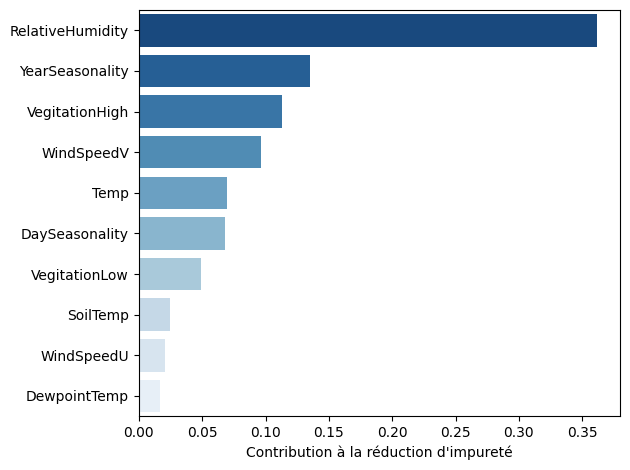

In [129]:
# On regarde les features importance
plot_importance(rf_tuned, features)

On retrouve les mêmes variables que pour l'abre de décision. Toutefois, à l'exception de *RelativeHumidity* (bien que sa contribution soit moins importante), les contributions à la réduction d'impureté  sont plus équilibrées.

### Modèle 5 (XGBOOST)

In [164]:
# On entraîne un modèle par défaut
model1 = XGBRegressor(random_state=42)
model1.fit(data_train[features], data_train["O3"])

# On stocke les prédictions
data_train["P_xgboost"] = model1.predict(data_train[features])
data_test["P_xgboost"] = model1.predict(data_test[features])

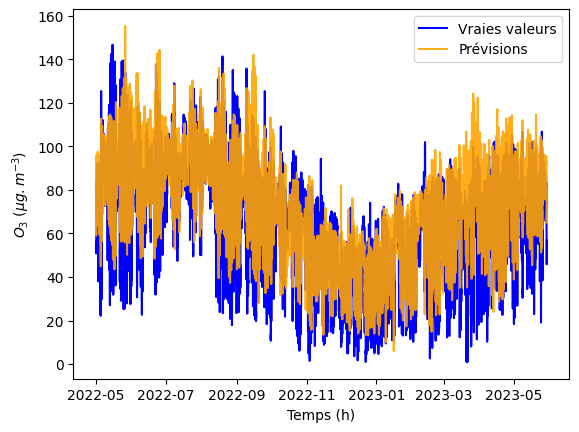

In [165]:
# Plot annuel
plot_all(data_test, "P_xgboost")

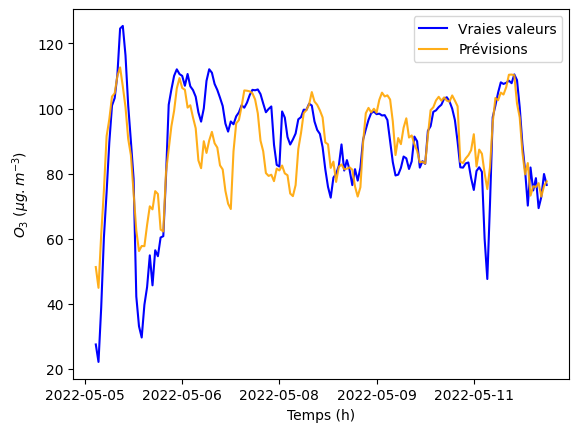

In [166]:
# Plot sur une semaine
plot_test_week(data_test, "P_xgboost")

La prédiction semble vraiment très bonne pour un modèle dont les hyperparamètres sont à leur valeur par défaut.

In [167]:
# On affiche les métriques
print_metrics(data_train, "P_xgboost")
print_metrics(data_test, "P_xgboost", type="prediction")

MAPE en estimation : 8.43%
RMSE en estimation : 5.38
MAPE en prediction : 32.3%
RMSE en prediction : 14.67


On a naturellement un gros écart de performance entre le train et le test : XGBOOST construit séquentiellement des prédicteurs faibles pour diminuer les résidus sur le train.
On peut essayer de diminuer le surapprentissage en ajustant les hyperparamètres du modèle.

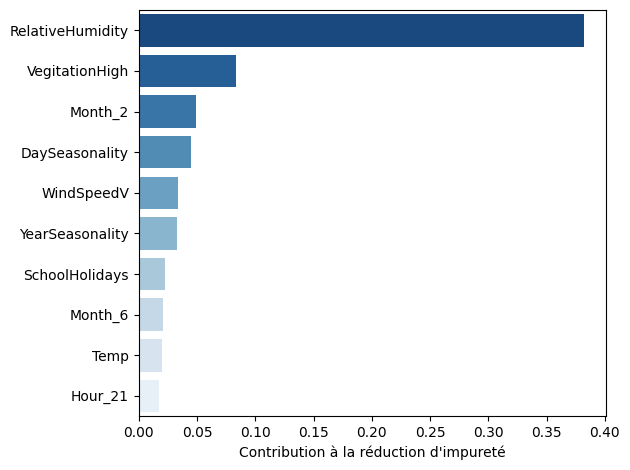

In [162]:
# On affiche les features importance
plot_importance(model1, features)

Encore une fois *RelativeHumidity* est la variable qui contribue le plus à la réduction d'impureté.

### Modèle 6 (XGBOOST tuné)

On souhaite explorer beaucoup d'hyperparamètres simultanément donc on utilisera RandomizedSearchCV au lieu d'une grid search "traditionnelle".

In [ ]:
param_distributions = {
    "n_estimators": randint(50, 500),         
    "max_depth": randint(3, 10),             
    "learning_rate": uniform(0.01, 0.9),     
    "subsample": uniform(0.5, 0.5),   
    "max_leaves" :  randint(1,40),    
}

In [ ]:
# Definir le modele
model = XGBRegressor(random_state=42)

# Definir random search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=100,                
    scoring="neg_mean_squared_error",  
    cv=5,                     
    random_state=42,
    n_jobs=-1,                
    verbose=0                 
)

# Fit randomsearch
random_search.fit(data_train[features], data_train["O3"])

# meilleurs parametres 
print("\n--- Meilleurs hyperparamètres ---")
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


--- Meilleurs hyperparamètres ---
Best Parameters: {'learning_rate': 0.023774086261346274, 'max_depth': 5, 'max_leaves': 32, 'n_estimators': 306, 'subsample': 0.7696887242000312}
Best Score: -180.6697755449487


In [158]:
model2 = random_search.best_estimator_
data_train["P_xgboost_tuned"] = model2.predict(data_train[features])
data_test["P_xgboost_tuned"] = model2.predict(data_test[features])

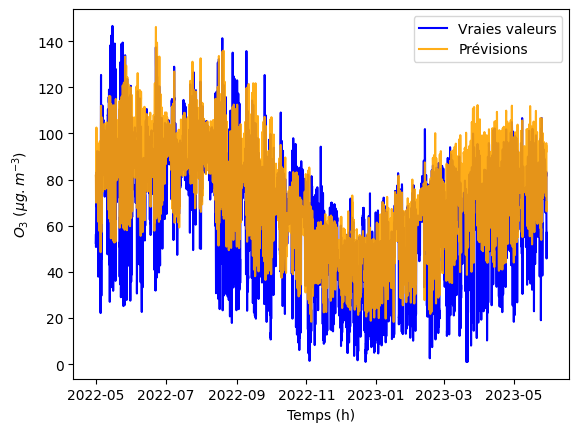

In [159]:
# Plot annuel
plot_all(data_test, "P_xgboost_tuned")

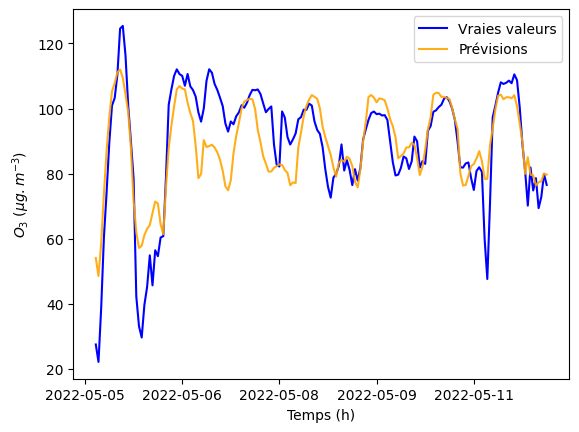

In [160]:
# Plot sur une semaine
plot_test_week(data_test, "P_xgboost_tuned")

In [161]:
# On affiche les métriques
print_metrics(data_train, "P_xgboost_tuned")
print_metrics(data_test, "P_xgboost_tuned", type="prediction")

MAPE en estimation : 17.34%
RMSE en estimation : 9.55
MAPE en prediction : 33.07%
RMSE en prediction : 13.89


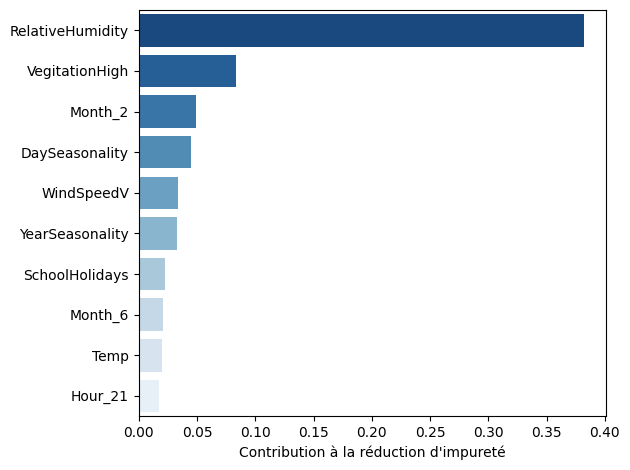

In [163]:
# On affiche les features importances
plot_importance(model1, features)

Mêmes conclusions.

### Modèle 4 en ligne

In [ ]:
# Initialisation des listes pour stocker les prédictions
train_predictions = []
test_predictions = []

# On collecte les prévisions de chaque arbre dans des listes
for tree in range(100):
    train_pred = rf_tuned.estimators_[tree].predict(data_train[features].values)
    test_pred = rf_tuned.estimators_[tree].predict(data_test[features].values)
    
    train_predictions.append(pd.Series(train_pred, index=data_train.index, name=f"tree{tree}"))
    test_predictions.append(pd.Series(test_pred, index=data_test.index, name=f"tree{tree}"))

# On concatène toutes les prédictions d'un coup
data_online_train = pd.concat([data_train[["Date", "O3"]]] + train_predictions, axis=1)
data_online_test = pd.concat([data_test[["Date", "O3"]]] + test_predictions, axis=1)

features_tree = [feature for feature in data_online_train if feature not in ["Date", "O3"]]

In [ ]:
# Online Linear Regression
data_test["POW_forest_tuned"] = 0.
mu = 0.999
batch_size = 24*2

for t in range(1, (len(data_test) // batch_size) + 1):
    if t == 1:
        start_idx = (t - 1) * batch_size
        end_idx = min(t * batch_size, len(data_test))
        data_test.loc[data_test.index[start_idx:end_idx], "POW_forest_tuned"] = rf_tuned.predict(data_test[features].iloc[start_idx:end_idx])

    else:
        data_train_online = pd.concat([data_online_train, data_online_test.iloc[:(t - 1) * batch_size]]).copy()
        
        weights = np.power(mu*np.ones(len(data_train_online)), np.arange(len(data_train_online),0,-1))
        reg_linW = LinearRegression()
        reg_linW.fit(data_train_online[features_tree], data_train_online["O3"], sample_weight=weights)
    
        start_idx = (t - 1) * batch_size
        end_idx = min(t * batch_size, len(data_test))
    
        data_test.loc[data_test.index[start_idx:end_idx], "POW_forest_tuned"] = reg_linW.predict(data_online_test[features_tree].iloc[start_idx:end_idx])

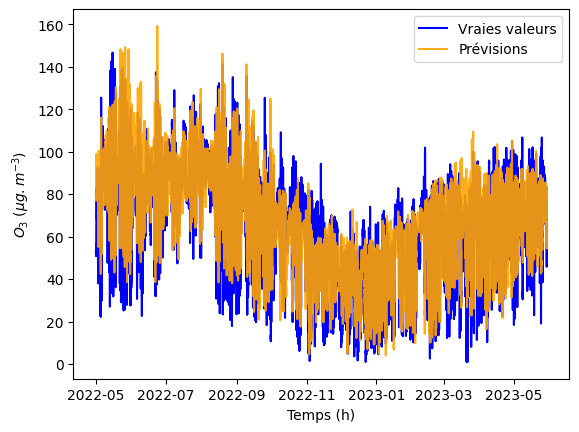

In [132]:
# Plot annuel
plot_all(data_test, "POW_forest_tuned")

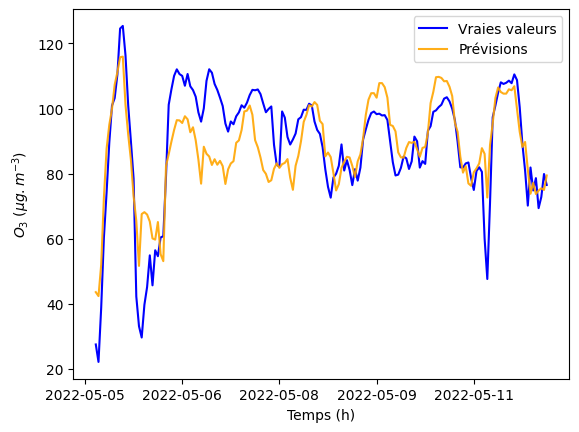

In [133]:
# Plot sur une semaine
plot_test_week(data_test, "POW_forest_tuned")

In [134]:
# On affiche les métriques
print_metrics(data_test, "POW_forest_tuned", type="prediction")

MAPE en prediction : 26.88%
RMSE en prediction : 12.81


On gagne 6.5% en MAPE et presque 1.5 point en RMSE.

### Modèle 6 en ligne

In [173]:
data_test["POW_xgboost_tuned"] = 0.
mu = 0.999
batch_size = 24*2

for t in range(1, (len(data_test) // batch_size) + 2):
    xgbW = model2
    
    if t == 1:
        xgbW.fit(data_train_online[features], data_train_online["O3"])
    
    else:
        data_train_online = pd.concat([data_train, data_test.iloc[:(t - 1) * batch_size]]).copy()
        weights = np.power(mu*np.ones(len(data_train_online)), np.arange(len(data_train_online),0,-1))
        xgbW.fit(data_train_online[features], data_train_online["O3"], sample_weight=weights)
    
    start_idx = (t - 1) * batch_size 
    end_idx = min(t * batch_size, len(data_test))

    data_test.loc[data_test.index[start_idx:end_idx], "POW_xgboost_tuned"] = xgbW.predict(data_test.loc[data_test.index[start_idx:end_idx], features])

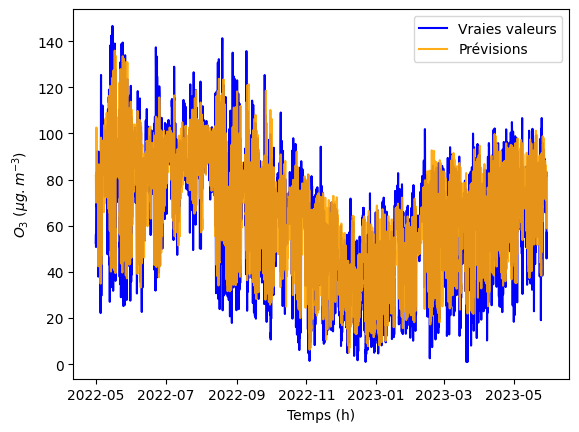

In [175]:
# Plot annuel
plot_all(data_test, "POW_xgboost_tuned")

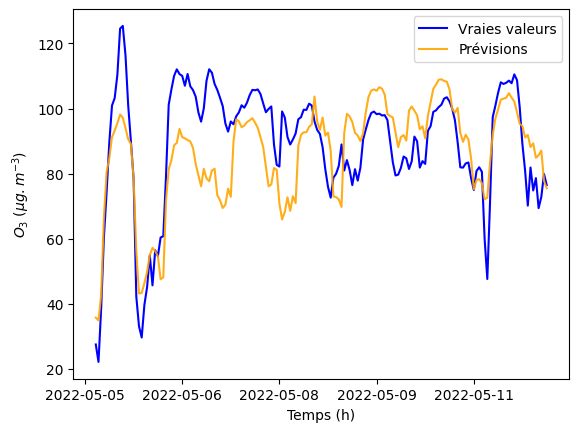

In [176]:
# Plot sur une semaine
plot_test_week(data_test, "POW_xgboost_tuned")

In [ ]:
# On affiche les métriques
print_metrics(data_test, "POW_xgboost_tuned", type="prediction")

MAPE en prediction : 22.69%
RMSE en prediction : 11.7


## Réseaux de neurones pour la régression

### Modèle 1 (PMC)

A la main, nous avons testé plusieurs combinaison pour le nombre de couches et de neurones par couches cachées. Nous avons arrêté notre choix sur 2 couches cachées avec 256 et 128 neurones.

In [ ]:
# On prépare les données pour le PMC
PMC_input_scaler = mm_scaler()
PMC_input_scaler.fit(data_train[features],
               quantitatives= ["WindSpeedU",
                            "WindSpeedV",
                            "DewpointTemp",
                            "TotalPrecipitation",
                            "VegitationHigh",
                            "VegitationLow",
                            "SoilTemp",
                            "Temp",
                            "RelativeHumidity",
                            "YearSeasonality",
                            "DaySeasonality",
                            "Fires"])
X_train = PMC_input_scaler.transform(data_train[features])
X_test = PMC_input_scaler.transform(data_test[features])

PMC_output_scaler = mm_scaler()
PMC_output_scaler.fit(data_train["O3"])
y_train = PMC_output_scaler.transform(data_train["O3"])
y_test = PMC_output_scaler.transform(data_test["O3"])

# On entraine le modèle
nn_model = MLPRegressor(hidden_layer_sizes=(256, 128), random_state=42, learning_rate="adaptive", max_iter=100000)

nn_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(256, 128), learning_rate='adaptive',
             max_iter=100000, random_state=42)

In [279]:
# On stocke les prédictions
data_train["P_mlp"] = PMC_output_scaler.transform_inverse(nn_model.predict(X_train))
data_test["P_mlp"] = PMC_output_scaler.transform_inverse(nn_model.predict(X_test))

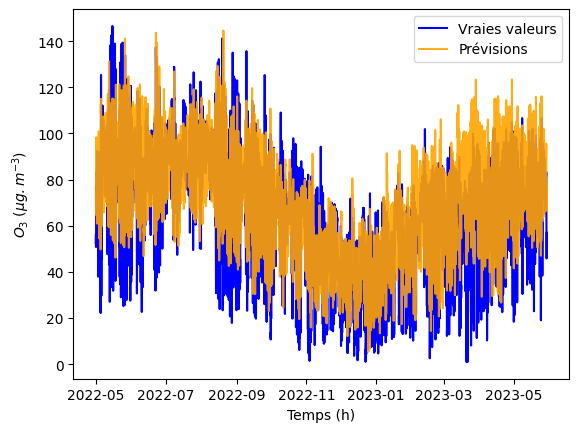

In [280]:
# Plot annuel
plot_all(data_test, "P_mlp")

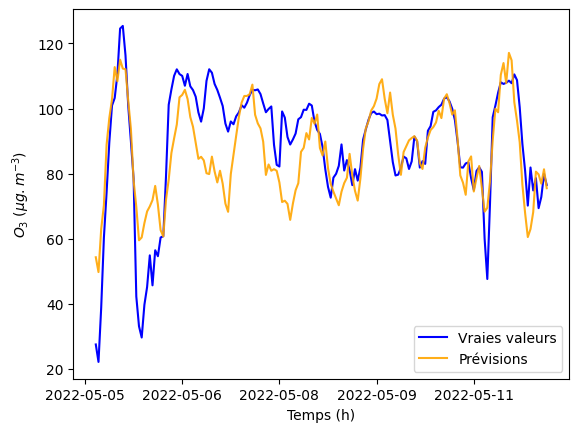

In [281]:
# Plot sur une semaine
plot_test_week(data_test, "P_mlp")

In [282]:
# On affiche les métriques
print_metrics(data_train, "P_mlp")
print_metrics(data_test,"P_mlp", type="prediction")

MAPE en estimation : 17.24%
RMSE en estimation : 10.24
MAPE en prediction : 33.19%
RMSE en prediction : 15.05


Les prédictions avec un PMC semblent être plutôt bonnes. Si la différence d'erreur entre le set de train et le set de test nous a dissuadé d'essayer de prédire les résidus. L'entraînement du réseau est plutôt rapide, nous pouvons essayer de réentrainer en ligne un réseau avec la même architecture.

### Modèle 1 en ligne (non pondéré)

In [ ]:
# Mise en ligne
data_test["PO_mlp"] = 0.
mu = 0.999
batch_size = 24 * 2

for t in range(1, (len(data_test) // batch_size) + 1):
    if t == 1:
        mlpW = nn_model
    else:
        X_train_online = np.concatenate([X_train, X_test[:(t - 1) * batch_size]]).copy()
        y_train_online = np.concatenate([y_train, y_test[:(t - 1) * batch_size]]).copy()
        weights = np.power(mu*np.ones(len(X_train_online)), np.arange(len(X_train_online),0,-1))

        mlpW = MLPRegressor(hidden_layer_sizes=(256, 128), random_state=42, learning_rate="adaptive", max_iter=100000)
        mlpW.fit(X_train_online, y_train_online)

    start_idx = (t - 1) * batch_size
    end_idx = min(t * batch_size, len(data_test))

    data_test.loc[data_test.index[start_idx:end_idx], "PO_mlp"] = PMC_output_scaler.transform_inverse(mlpW.predict(X_test[start_idx:end_idx])) 

c:\Users\Valen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\Valen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\Valen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


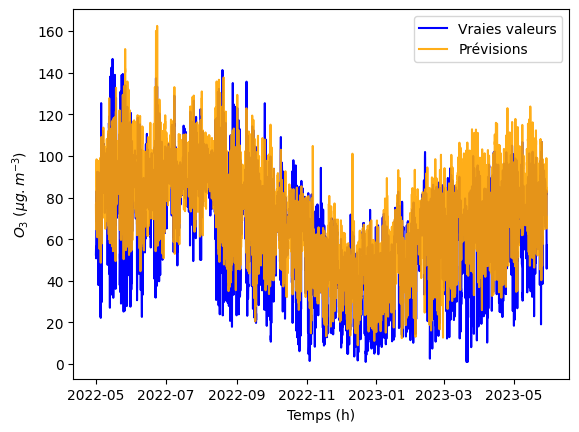

In [287]:
# Plot annuel
plot_all(data_test,"PO_mlp")

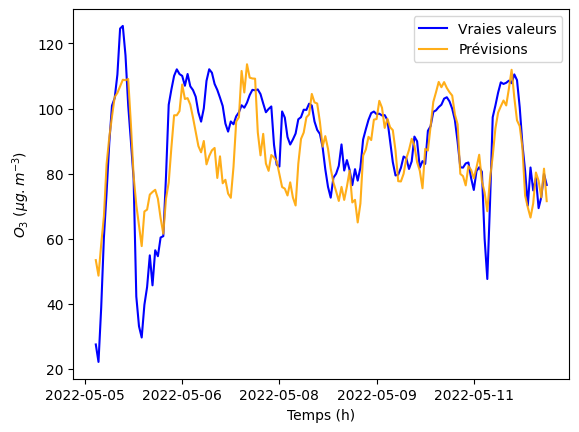

In [288]:
# Plot sur une semaine
plot_test_week(data_test, "PO_mlp")

In [289]:
# On affiche les métriques
print_metrics(data_test, "PO_mlp")

MAPE en estimation : 32.03%
RMSE en estimation : 14.49


On a légèrement gagné en MAPE et en RMSE.

## Réseaux de neurones pour les séries temporelles

Dans cette partie on prédit heure par heure avec un délai de réception des données de 48 heures (heure par heure avec un horizon de prévision de deux jours). On utilisera les 24 dernières observations disponibles en input.

On prépare nos données pour les réseaux de neurones avec des couples (vecteur de taille 24 en entrée, une valeur à prédire de taille 1). On normalise également nos données.

In [14]:
# Construction des sets d'entraînement et de test
X_train, y_train, X_test, y_test, scaler = prepare_RNN(data_train, data_test, "O3", lag_size=24, h=48)

### Modèle 1 (RNN)

In [ ]:
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)
# construction du modèle
regressor = Sequential([
    Input(shape=(X_train.shape[1], 1)),  # Définition explicite de l'entrée
    SimpleRNN(units=50, activation="relu", return_sequences=False),  # RNN
    Dense(units=1, activation="sigmoid")  # Couche de sortie
])
 
# compilation
regressor.compile(optimizer = "adam", 
                  loss = "mean_squared_error")
 
# On fit le modèle
regressor.fit(X_train, y_train,epochs = 5)

Epoch 1/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0143
Epoch 2/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0047
Epoch 3/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0044
Epoch 4/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0043
Epoch 5/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0043


In [ ]:
# Stockage des prédiction
data_train["P_RNN"] = data_train["O3"].mean()
data_train.loc[71:,"P_RNN"] = scaler.transform_inverse(regressor.predict(X_train))
data_test["P_RNN"]  = scaler.transform_inverse(regressor.predict(X_test))

546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


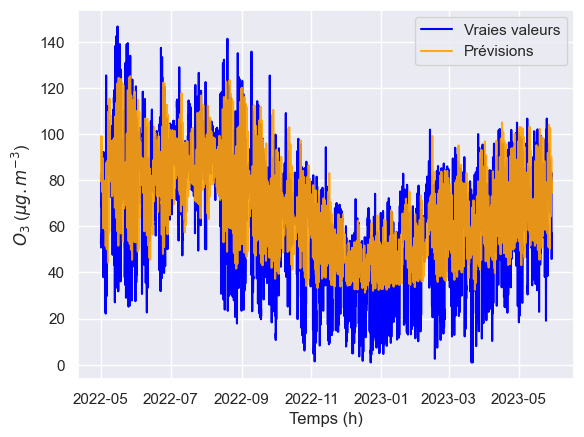

In [ ]:
# Plot sur l'année test
plot_all(data_test, "P_RNN")

On semble manquer toute l'amplitude basse de la période estivale.

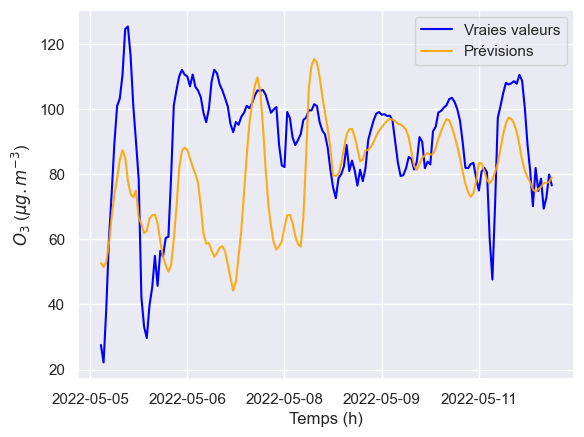

In [ ]:
# Plot sur une semaine choisie
plot_test_week(data_test, "P_RNN")

La prédiction n'est pas très satisfaisante sur les trois premiers jours.

In [140]:
# Affichage des métriques
print_metrics(data_train, "P_RNN")
print_metrics(data_test, "P_RNN", type = "prediction")

MAPE en estimation : 30.84%
RMSE en estimation : 16.97
MAPE en prediction : 41.69%
RMSE en prediction : 17.49


Le modèle est très basique et nous nous attendons à de meilleures performances pour les les modèles GRU et LSTM.

### Modèle 2 (LSTM)

Le LSTM possède des neurones qui gardent en mémoire plus d'informations temporelles que dans un simple RNN. Nous avons 2 couches de neurones LSTM comportant 128 et 64 neurones respectivement. Nous ajoutons des couches de Dropout pour neutraliser 20% des neurones dans l'apprentissage pour éviter l'overfitting. Nous entrainons sur 10 epochs.

In [ ]:
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)
# Construction du modèle
regressorLSTM = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(units=128, activation="tanh", return_sequences=True),
    Dropout(0.2),
    LSTM(units=64, activation="tanh", return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
 
#Compilation du modèle
regressorLSTM.compile(optimizer = "adam",
                      loss = "mean_squared_error")
 
#Fitting
regressorLSTM.fit(X_train, y_train, epochs = 10, batch_size = 16)

Epoch 1/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - loss: 0.0083
Epoch 2/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 64s 59ms/step - loss: 0.0051
Epoch 3/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 70s 64ms/step - loss: 0.0050
Epoch 4/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 66s 61ms/step - loss: 0.0048
Epoch 5/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 73s 66ms/step - loss: 0.0047
Epoch 6/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 55s 50ms/step - loss: 0.0045
Epoch 7/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - loss: 0.0044
Epoch 8/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 0.0042
Epoch 9/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 0.0042
Epoch 10/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - loss: 0.0041


In [ ]:
# Stockage des prédiction
data_train["P_LSTM"] = data_train["O3"].mean()
data_train.loc[71:,"P_LSTM"] = scaler.transform_inverse(regressorLSTM.predict(X_train))
data_test["P_LSTM"]  = scaler.transform_inverse(regressorLSTM.predict(X_test))

546/546 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


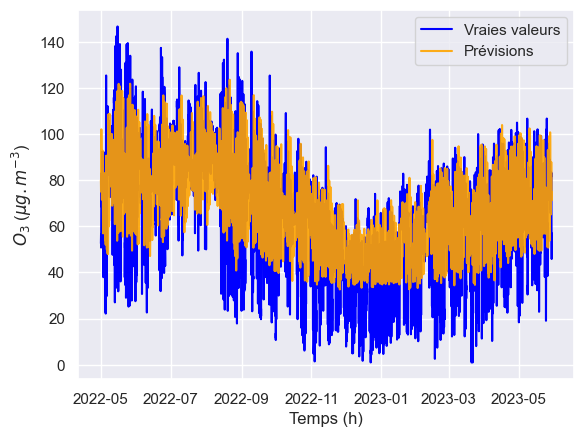

In [ ]:
# Plot sur l'année test
plot_all(data_test, "P_LSTM")

Encore une fois, on ne capte pas toute l'amplitude des données pour la période estivale.

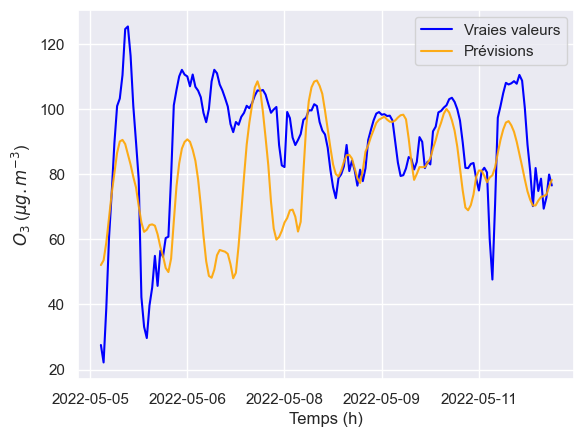

In [ ]:
# Plot sur une semaine choisie
plot_test_week(data_test, "P_LSTM")

Pas de grands changements par rapport au RNN.

In [141]:
# Affichage des métriques
print_metrics(data_train, "P_LSTM")
print_metrics(data_test, "P_LSTM", type = "prediction")

MAPE en estimation : 31.75%
RMSE en estimation : 16.81
MAPE en prediction : 43.9%
RMSE en prediction : 17.73


Encore une fois, les prédictions ne sont pas très satisfaisantes.

### Modèle 3 (GRU)

Les réseaux de neurones GRU fonctionnent comme les LSTM avec des portes mais le principe est simplifié sans pour autant perdre en performance. Nous n'avons pour ce modèle qu'une seule couche de 500 neurones GRU avec la fonction d'activation tanh. Nous entrainons sur 15 epochs.

In [ ]:
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)
#Construction du modèle
regressorGRU = Sequential([
    Input(shape=(X_train.shape[1], 1)),  # Définition explicite de l'entrée
    GRU(units=500, activation="tanh", return_sequences=False),  # GRU
    Dense(1)  # Couche de sortie
])

# Compilation du modèle
regressorGRU.compile(optimizer="adam",             
                     loss="mean_squared_error")
# Fitting
regressorGRU.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 55s 94ms/step - loss: 0.0072
Epoch 2/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 64s 118ms/step - loss: 0.0049
Epoch 3/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 74s 135ms/step - loss: 0.0048
Epoch 4/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 81s 149ms/step - loss: 0.0048
Epoch 5/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 82s 150ms/step - loss: 0.0048
Epoch 6/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 79s 145ms/step - loss: 0.0047
Epoch 7/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 69s 126ms/step - loss: 0.0046
Epoch 8/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 90s 165ms/step - loss: 0.0045
Epoch 9/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 81s 148ms/step - loss: 0.0044
Epoch 10/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 80s 147ms/step - loss: 0.0043


In [67]:
# Stockage des prédiction
data_train["P_GRU"] = data_train["O3"].mean()
data_train.loc[71:,"P_GRU"] = scaler.transform_inverse(regressorGRU.predict(X_train))
data_test['P_GRU']  = scaler.transform_inverse(regressorGRU.predict(X_test))

546/546 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step
296/296 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step


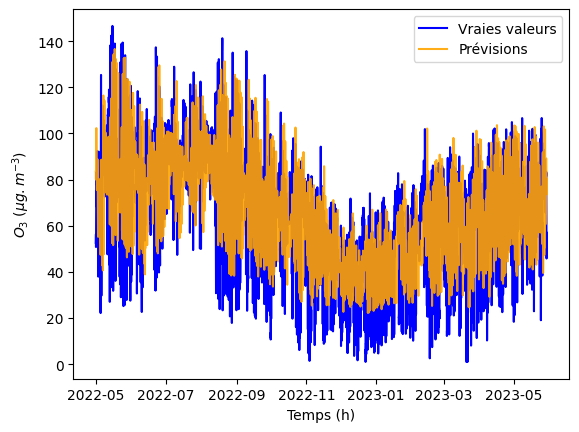

In [68]:
# Plot annuel
plot_all(data_test, "P_GRU")

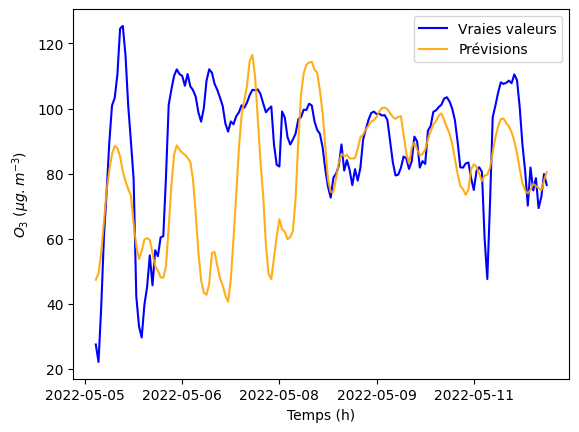

In [69]:
# Plot sur une semaine
plot_test_week(data_test, "P_GRU")

In [70]:
# On affiche les métriques
print_metrics(data_train, "P_GRU")
print_metrics(data_test, "P_GRU", type="prediction")

MAPE en estimation : 30.17%
RMSE en estimation : 17.14
MAPE en prediction : 38.69%
RMSE en prediction : 17.24


C'est un peu mieux.

### Modèle 3 en ligne

On met en ligne en faisant parcourir les nouvelles observations dans le réseau avec un plus petit pas d'apprentissage qu'à l'entraînement initial (0.001 par défaut).

In [107]:
regressorGRU_online = tf.keras.models.clone_model(regressorGRU)
regressorGRU_online.set_weights(regressorGRU.get_weights())

regressorGRU_online.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
# Apprentissage en ligne
def online_learning(model, X, Y):
    predictions = []
    for i in range(0, len(X),48):
        input_seq = X[i:i+48]
        pred = model.predict(input_seq, verbose=0)
        predictions.append(pred.flatten())
        true_values = Y[i:i+48]
        model.fit(input_seq, true_values, epochs=1, verbose=0, batch_size=48, shuffle=False)
    return np.concatenate(predictions)

# Utilisation de la fonction pour calculer les prédictions
predictions_test = online_learning(regressorGRU_online, X_test, y_test)

In [108]:
# Stockage des prédiction
data_test["POW_GRU"]  = scaler.transform_inverse(predictions_test)

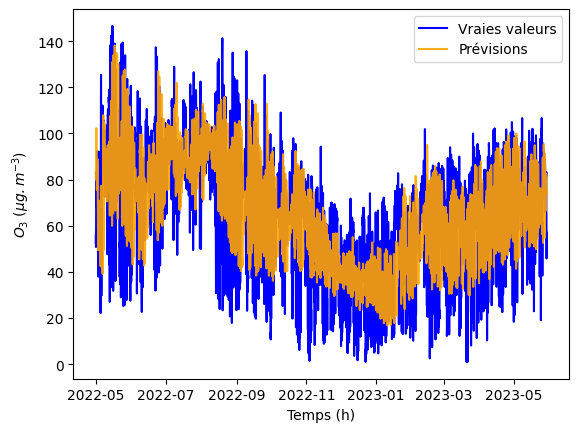

In [109]:
# Plot annuel
plot_all(data_test, "POW_GRU")

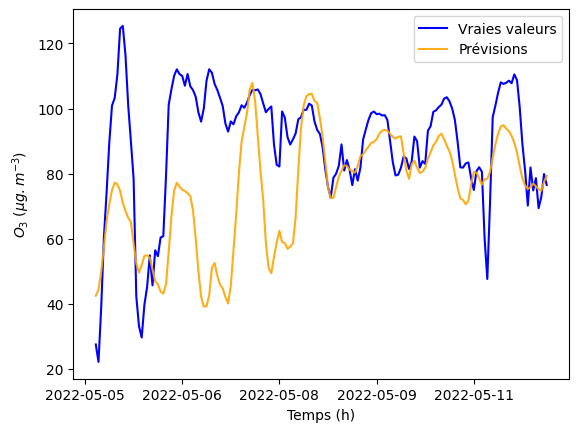

In [110]:
# Plot sur une semaine
plot_test_week(data_test, "POW_GRU")

In [111]:
print_metrics(data_test, "POW_GRU", type="prediction")

MAPE en prediction : 37.74%
RMSE en prediction : 17.2


On n'améliore que très peu les performances, il faut probablement mieux ajuster notre manière de mettre à jour.

## Agrégation d'experts

On procède à l'agrégation d'experts. On choisira sur le set de test le meilleur pas d'apprentissage pour avoir un modèle prêt à l'emploi à l'avenir. On devrait probablement choisir un eta sur un autre set que celui de test mais faute d'un autre set disponible nous avons pris la décision de procéder ainsi (et pour le plaisir d'avoir une erreur qui est plus faible).

In [ ]:
# On sauvegarde les prévisions
prev_names = ["P_forest_tuned", "POW_forest_tuned", "P_tree_pruned", "P_reglin_all", "CP_reglin_all",
              "XGBP_reglin_all", "NNP_reglin_all", "LSTMP_reglin_all", "P_ridge_all", "P_lasso_all", 
              "P_elasticnet_all", "CP_elasticnet_all", "XGBP_elasticnet_all", "NNP_elasticnet_all",
              "LSTMP_elasticnet_all", "POW_reglin_all", "POW_elasticnet_all", "P_tree_all", "CP_tree_pruned",
              "NNP_tree_pruned", "LSTMP_tree_pruned", "POW_tree_pruned", "P_forest_all", "RPOW_reglin_all",
              "RPOW_elasticnet_all", "P_RNN", "P_LSTM", "P_GRU", "POW_GRU", "P_xgboost", "P_xgboost_tuned", 
              "POW_xgboost_tuned", "P_mlp", "PO_mlp"]
experts = data_test[["Date","O3"]+prev_names]
experts.to_csv(r"..\Data\experts.csv")

In [19]:
# On prépare les experts et la target
N = len(experts)

target = experts["O3"].copy()
advice = experts[prev_names].copy()

# On standardise pour éviter d'avoir des trop grandes valeurs dans l'exponentielle
mu = data_train["O3"].mean()
sigma = data_train["O3"].std()

target = (target-mu)/sigma
advice = (advice-mu)/sigma

### Algorithme EG

On procède à plusieurs grid search à la main pour tomber sur une valeur qui n'est pas en bord de grille.

#### Sur tous les modèles (meilleur empirique)

In [22]:
# On procède à une grid search à la main
eta_array = np.arange(2, 4, 0.1)
losses_list = []

for iter in eta_array:
    losses_list.append(np.sum(EG(experts=advice, target=target, eta=iter)[2]))

# On récupère le eta empirique optimal
best_index = losses_list.index(min(losses_list))
best_eta = eta_array[best_index]
print(best_eta)

# On stocke les résultats avec le meilleur eta empirique
pred1, p1, loss_pred1 = EG(experts=advice, target=target, eta=best_eta)

C:\Users\Valen\AppData\Local\Temp\ipykernel_11076\3780597495.py:170: RuntimeWarning: overflow encountered in exp
  numerator = np.exp(-eta*l)
C:\Users\Valen\AppData\Local\Temp\ipykernel_11076\3780597495.py:172: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator


3.6000000000000014


In [ ]:
# On stocke l'agrégation
data_test["EG_opt_all"] = pred1*sigma+mu

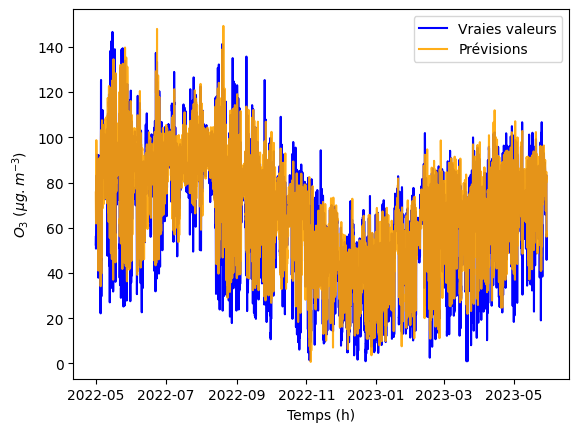

In [27]:
# Plot annuel
plot_all(data_test, "EG_opt_all")

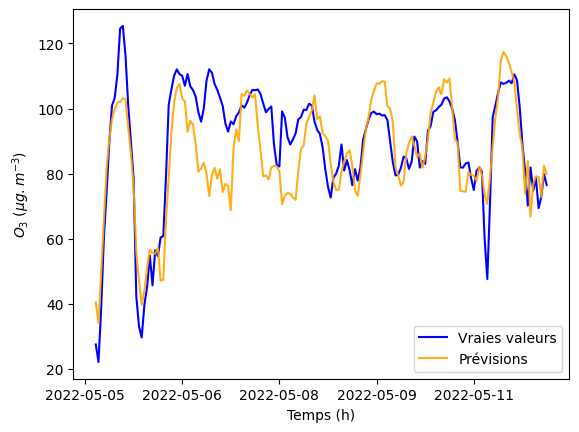

In [29]:
# Plot sur une semaine
plot_test_week(data_test, "EG_opt_all")

In [49]:
# On affiche les métriques 
print_metrics(data_test, "EG_opt_all", type="prediction")

MAPE en prediction : 19.86%
RMSE en prediction : 9.99


Les prédictions et leur métriques sont vraiment très satisfaisantes. Toutefois, le *best_eta* à 3 est vraiment très grand et cause beaucoup d'instabilité dans la répartition des poids.

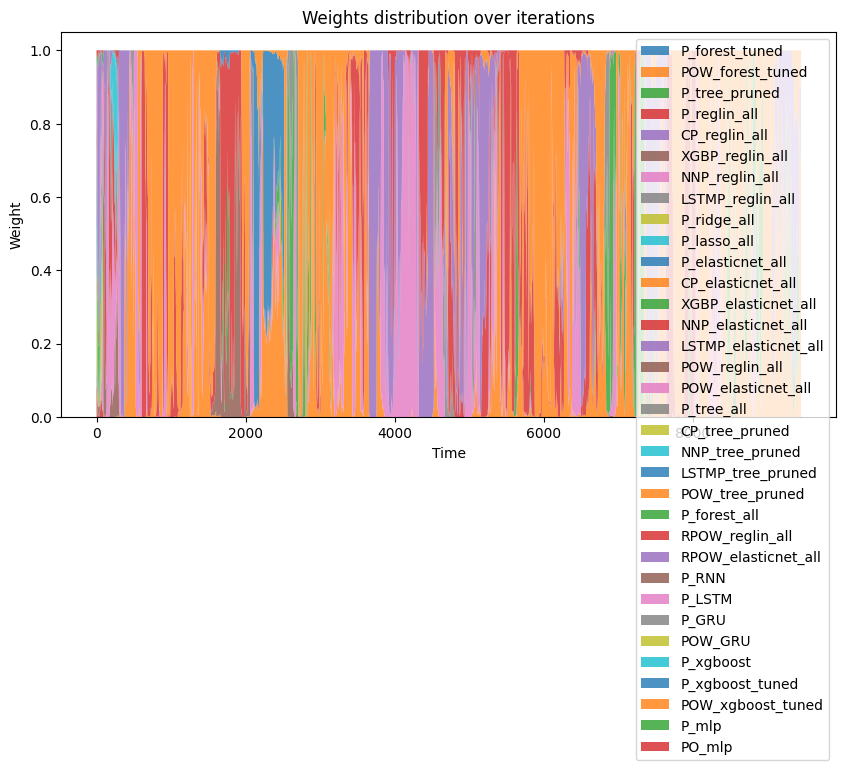

In [ ]:
# On affiche la distribution des poids
plot_weight(p1,N, labels=prev_names)

#### Sur une sélection de modèles (meilleur empirique)

La sélection a été faite sur la base des performances des modèles et dans l'optique d'avoir le plus de diversité (modèles représentés).

In [30]:
selection = ["RPOW_reglin_all", "RPOW_elasticnet_all", "POW_forest_tuned", "POW_tree_pruned", "POW_xgboost_tuned", "POW_GRU", "PO_mlp"]

In [57]:
# On procède à une grid search à la main
eta_array = np.arange(3, 7, 1)
losses_list = []

for iter in eta_array:
    losses_list.append(np.sum(EG(experts=advice[selection], target=target, eta=iter)[2]))

# On récupère le eta empirique optimal
best_index = losses_list.index(min(losses_list))
best_eta = eta_array[best_index]
print(best_eta)

# On stocke les résultats avec le meilleur eta empirique
pred2, p2, loss_pred2 = EG(experts=advice[selection], target=target, eta=best_eta)

C:\Users\Valen\AppData\Local\Temp\ipykernel_11076\3721007407.py:170: RuntimeWarning: overflow encountered in exp
  numerator = np.exp(-eta*l)
C:\Users\Valen\AppData\Local\Temp\ipykernel_11076\3721007407.py:172: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator


5


In [55]:
# On stocke l'agrégation
data_test["EG_opt_sel"] = pred2*sigma+mu

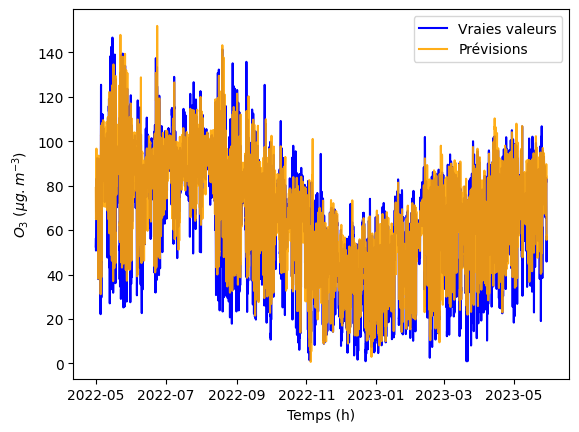

In [47]:
# Plot annuel
plot_all(data_test, "EG_opt_sel")

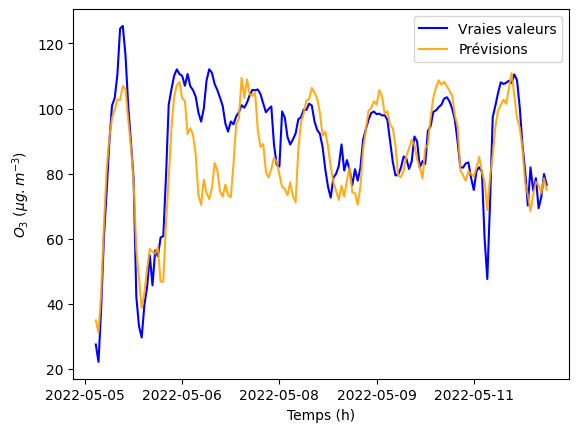

In [48]:
# Plot sur une semaine
plot_test_week(data_test, "EG_opt_sel")

In [51]:
# On affiche les métriques
print_metrics(data_test, "EG_opt_sel", type="prediction")

MAPE en prediction : 19.84%
RMSE en prediction : 10.17


On fait à peu près pareil qu'avec tous les modèles. Encore une fois, *eta_best* est grand (égal à 5) et cause une haute instabilité des poids.

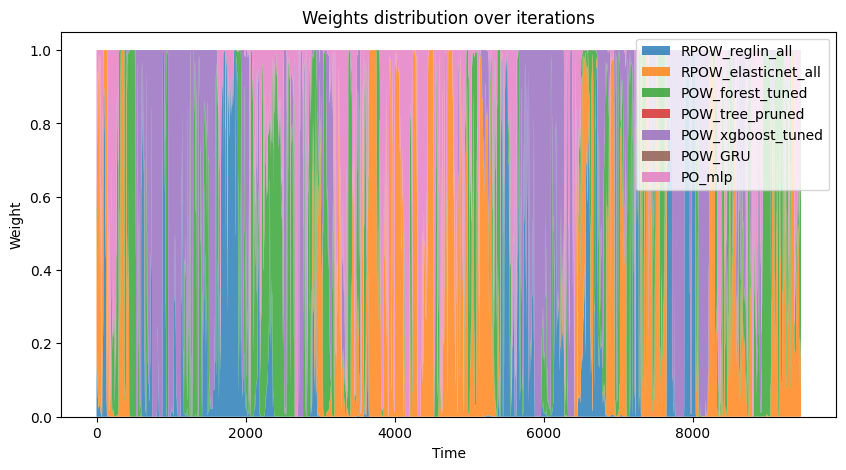

In [58]:
# On affiche la distributions des poids
plot_weight(p2, N, selection)

#### Sur tous les modèles (avec petit pas d'apprentissage arbitraire : 0.1)

In [88]:
# On fait l'agrégation
pred1bis, p1bis, loss_pred1bis = EG(experts=advice, target=target, eta=0.1)

# On stocke l'agrégation
data_test["EG_all"] = pred1bis*sigma+mu

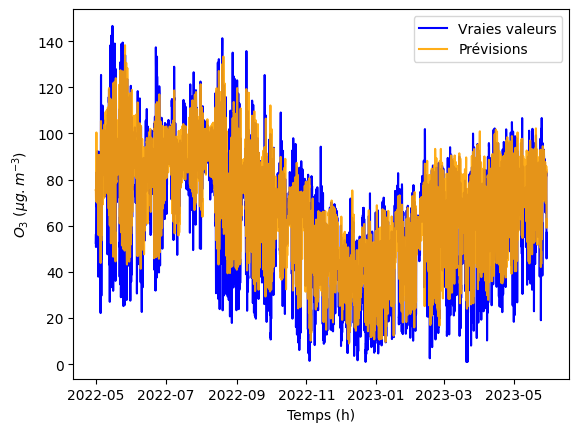

In [89]:
# Plot annuel
plot_all(data_test, "EG_all")

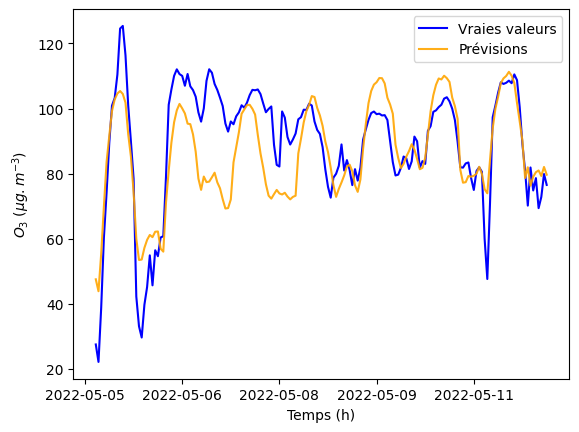

In [90]:
# Plot sur une semaine
plot_test_week(data_test, "EG_all")

In [91]:
# On affiche les métriques 
print_metrics(data_test, "EG_all", type="prediction")

MAPE en prediction : 22.48%
RMSE en prediction : 10.78


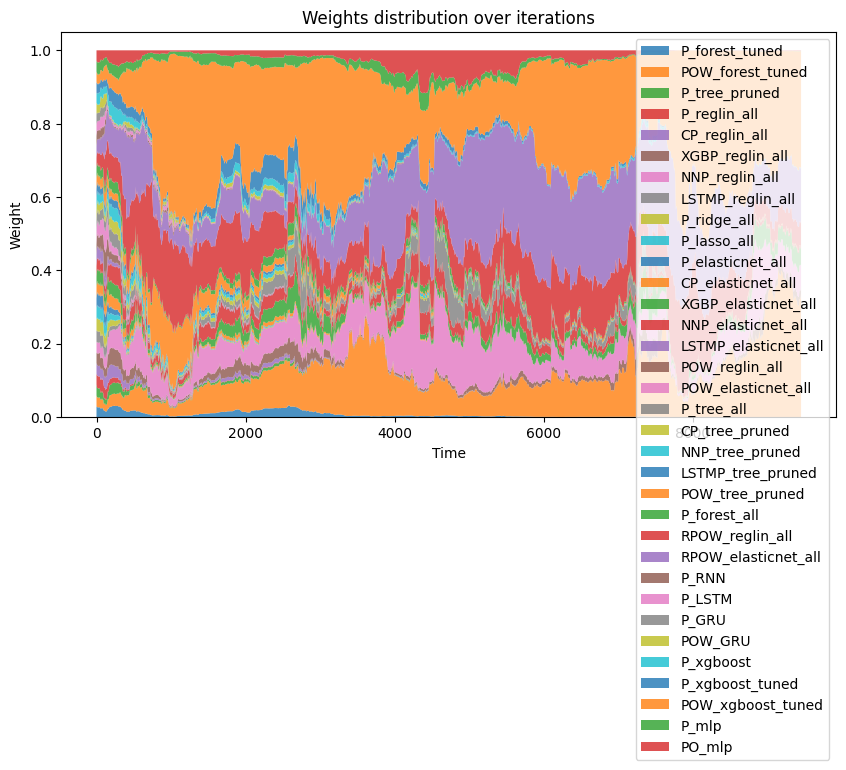

In [92]:
# On affiche la distribution des poids
plot_weight(p1bis,N, labels=prev_names)

Les poids sont plus stables mais on font à peine mieux que notre meilleure modèle.

#### Sur une sélection de modèles (avec petit pas d'apprentissage arbitraire : 0.1)

In [78]:
# On stocke les résultats avec le meilleur eta empirique
pred2bis, p2bis, loss_pred2bis = EG(experts=advice[selection], target=target, eta=0.1)

# On stocke l'agrégation
data_test["EG_sel"] = pred2bis*sigma+mu

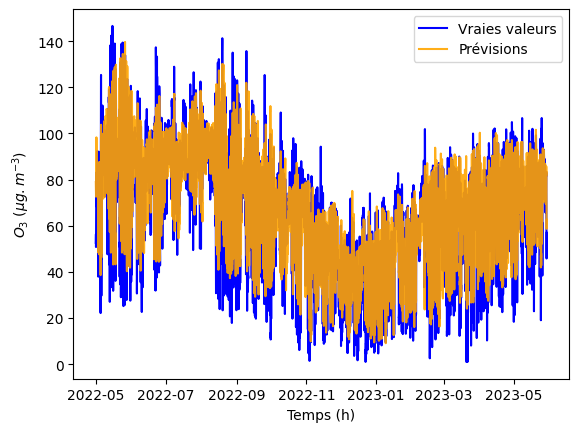

In [79]:
# Plot annuel
plot_all(data_test, "EG_sel")

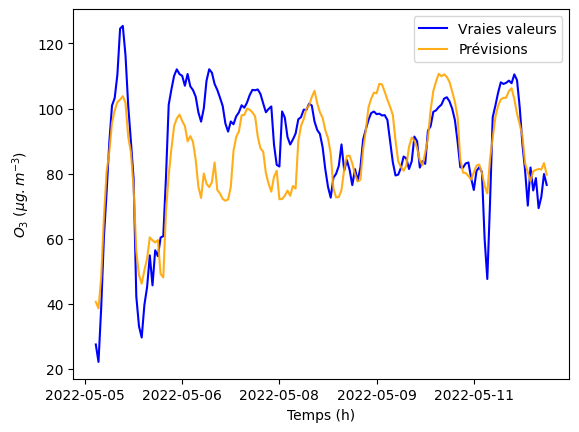

In [80]:
# Plot sur une semaine
plot_test_week(data_test, "EG_sel")

In [81]:
# On affiche les métriques
print_metrics(data_test, "EG_sel", type="prediction")

MAPE en prediction : 22.31%
RMSE en prediction : 10.77


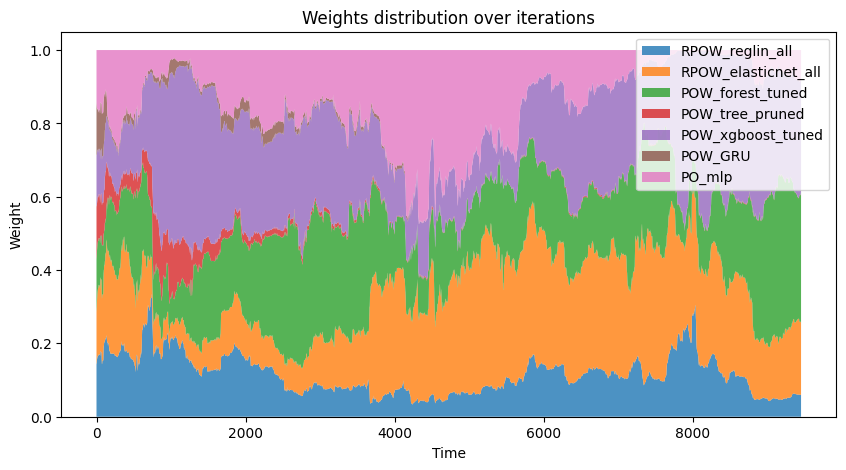

In [82]:
# On affiche la distributions des poids
plot_weight(p2bis, N, selection)

Mêmes conclusions.

### Algorithme EWA

#### Sur tous les modèles (meilleur empirique)

In [97]:
# On procède à une grid search à la main
eta_array = np.arange(0.01, 0.05, 0.01)
losses_list = []

for iter in eta_array:
    losses_list.append(np.sum(EWA(experts=advice, target=target, eta=iter)[2]))

# On récupère le eta empirique optimal
best_index = losses_list.index(min(losses_list))
best_eta = eta_array[best_index]
print(best_eta)

# On stocke les résultats avec le meilleur eta empirique
pred3, p3, loss_pred3 = EWA(experts=advice, target=target, eta=best_eta)

0.02


In [94]:
# On stocke l'agrégation
data_test["EWA_opt_all"] = pred3*sigma + mu


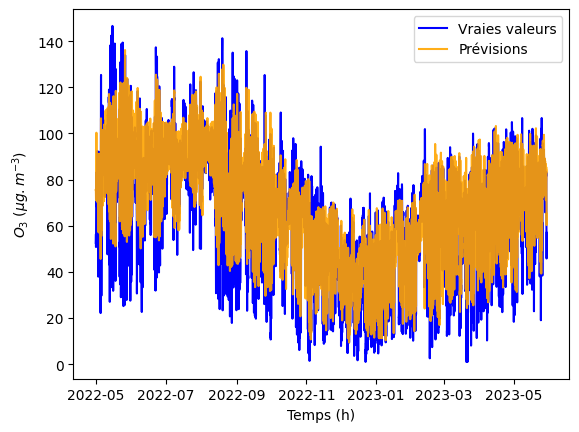

In [95]:
# Plot annuel
plot_all(data_test, "EWA_opt_all")

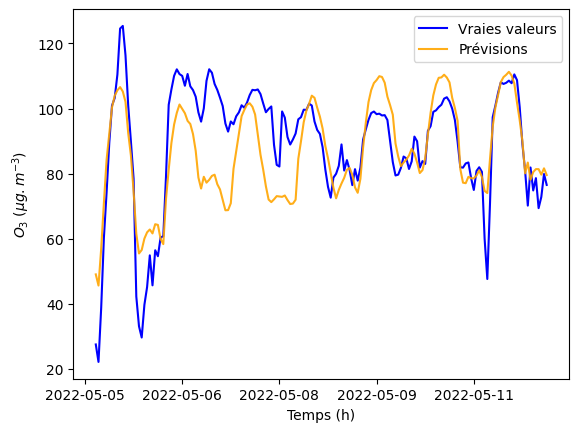

In [96]:
# Plot sur une semaine
plot_test_week(data_test, "EWA_opt_all")

In [98]:
# On affiche les métriques
print_metrics(data_test, "EWA_opt_all")

MAPE en estimation : 23.07%
RMSE en estimation : 11.21


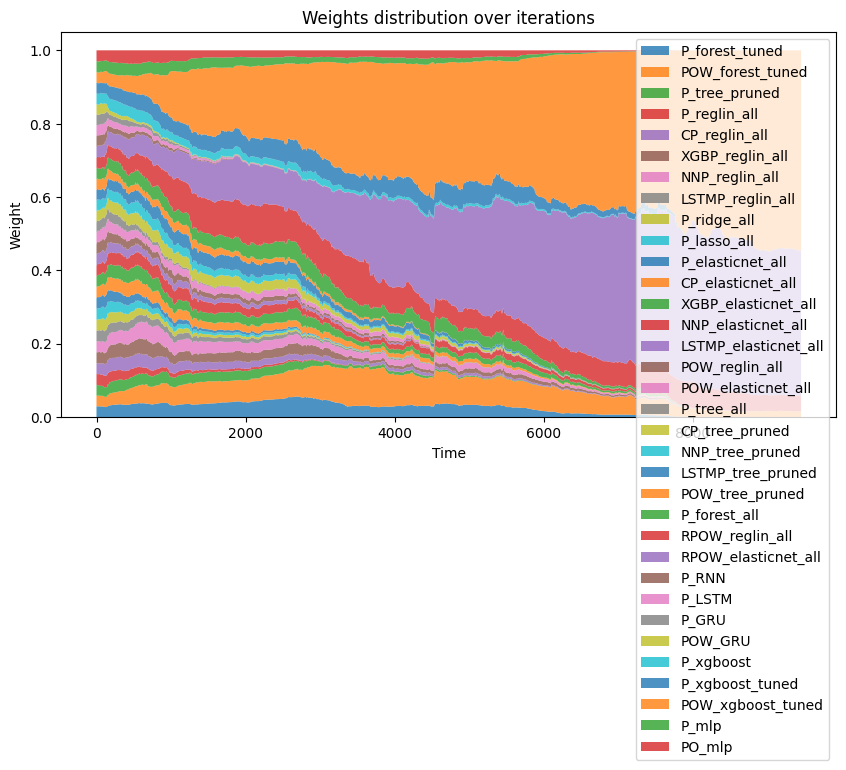

In [99]:
# On affiche la distribution de poids
plot_weight(p3, N, labels=prev_names)

On fait quand même moins bien qu'EG (eta=0.1) alors qu'il s'agit du meilleur résultat empirique.

#### Sur une sélection de modèles (meilleur empirique)

In [100]:
# On procède à une grid search à la main
eta_array = np.arange(0.001, 0.011, 0.001)
losses_list = []

for iter in eta_array:
    losses_list.append(np.sum(EWA(experts=advice[selection], target=target, eta=iter)[2]))

# On récupère le eta empirique optimal
best_index = losses_list.index(min(losses_list))
best_eta = eta_array[best_index]
print(best_eta)

# On stocke les résultats avec le meilleur eta empirique
pred4, p4, loss_pred4 = EWA(experts=advice[selection], target=target, eta=best_eta)

0.006


In [101]:
# On stocke l'agrégation
data_test["EWA_opt_sel"] = pred4*sigma + mu

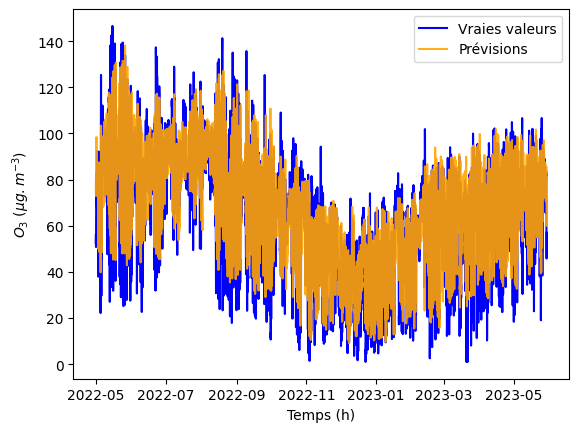

In [102]:
# Plot annuel
plot_all(data_test, "EWA_opt_sel")

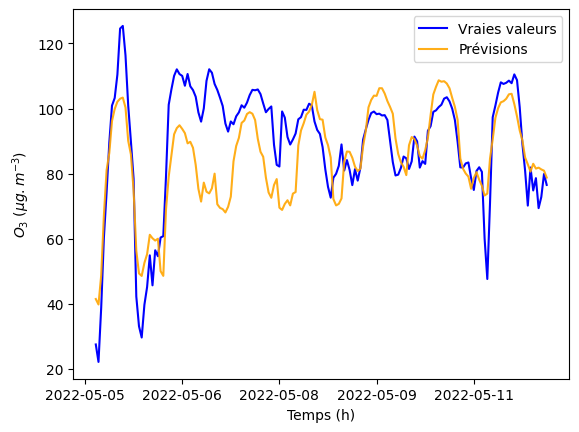

In [103]:
# Plot sur une semaine
plot_test_week(data_test, "EWA_opt_sel")

In [104]:
# On affiche les métriques
print_metrics(data_test, "EWA_opt_sel", type="prediction")

MAPE en prediction : 22.48%
RMSE en prediction : 10.96


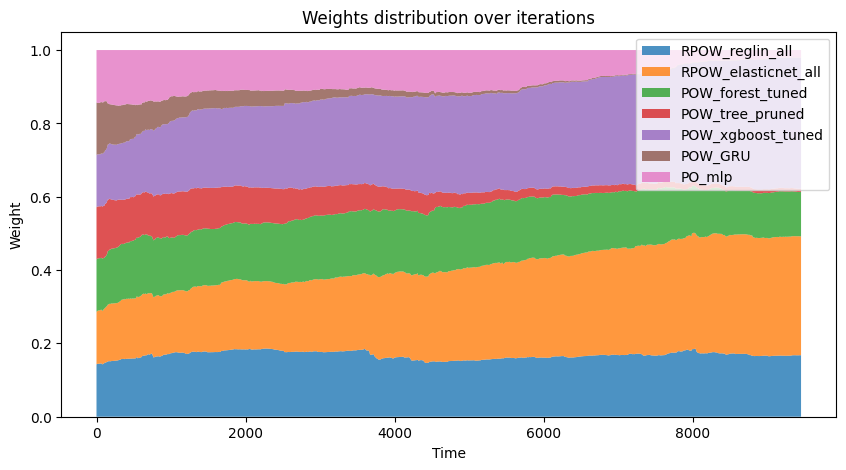

In [105]:
# On affiche la distribution des poids
plot_weight(p4, N, labels=selection)

On a de bonnes métriques et des poids plus stables que l'EG.